# Ross Sea synthetic gravity inversion

Here we try to recover the true bathymetry of the Ross Sea from a synthetic airborne gravity survey. See notebook `Ross_Sea_synthetic_model.ipynb` for the creation of this synthetic gravity data and the low-resolution starting model of bathymetry. 

import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging
import os
import pathlib
import pickle
import string

import numpy as np
import scipy as sp
import verde as vd
import xarray as xr
from polartoolkit import maps, profiles
from polartoolkit import utils as polar_utils

import RIS_gravity_inversion.plotting as RIS_plotting
import RIS_gravity_inversion.synthetic as RIS_synth

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

logging.getLogger().setLevel(logging.INFO)

from invert4geom import inversion, plotting, regional, uncertainty, utils

# Get synthetic model data

INFO:root:converting to be reference to the WGS84 ellipsoid
INFO:root:spacing larger than original, filtering and resampling
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


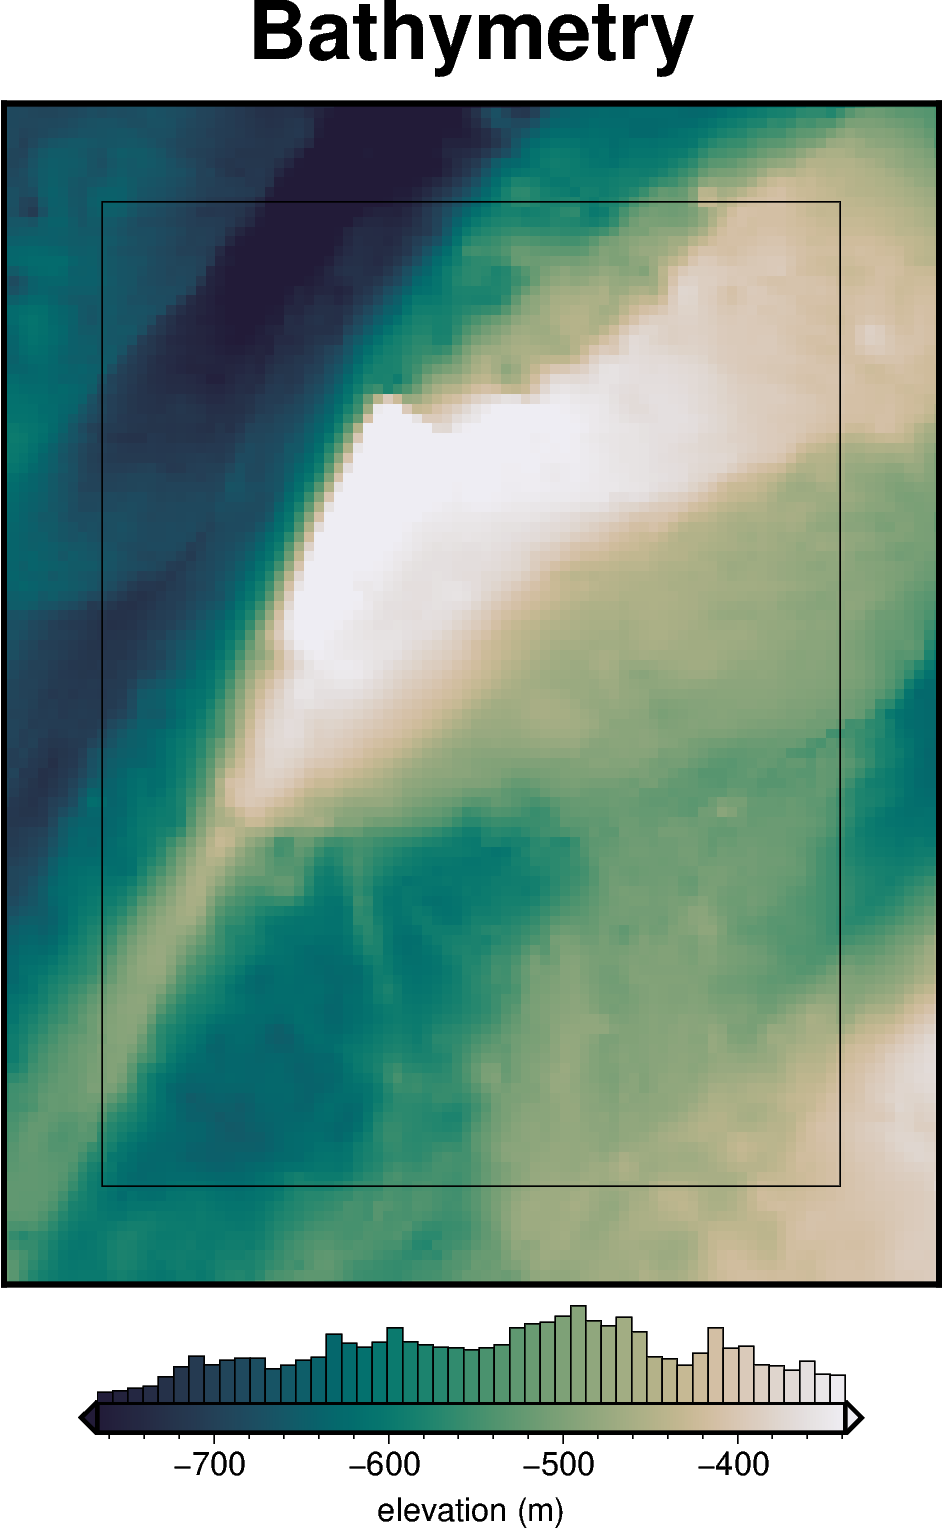

  0%|          | 0/7676 [00:00<?, ?it/s]

INFO:invert4geom:Standard deviation used for noise: [0.5]
INFO:invert4geom:Standard deviation used for noise: [0.5]


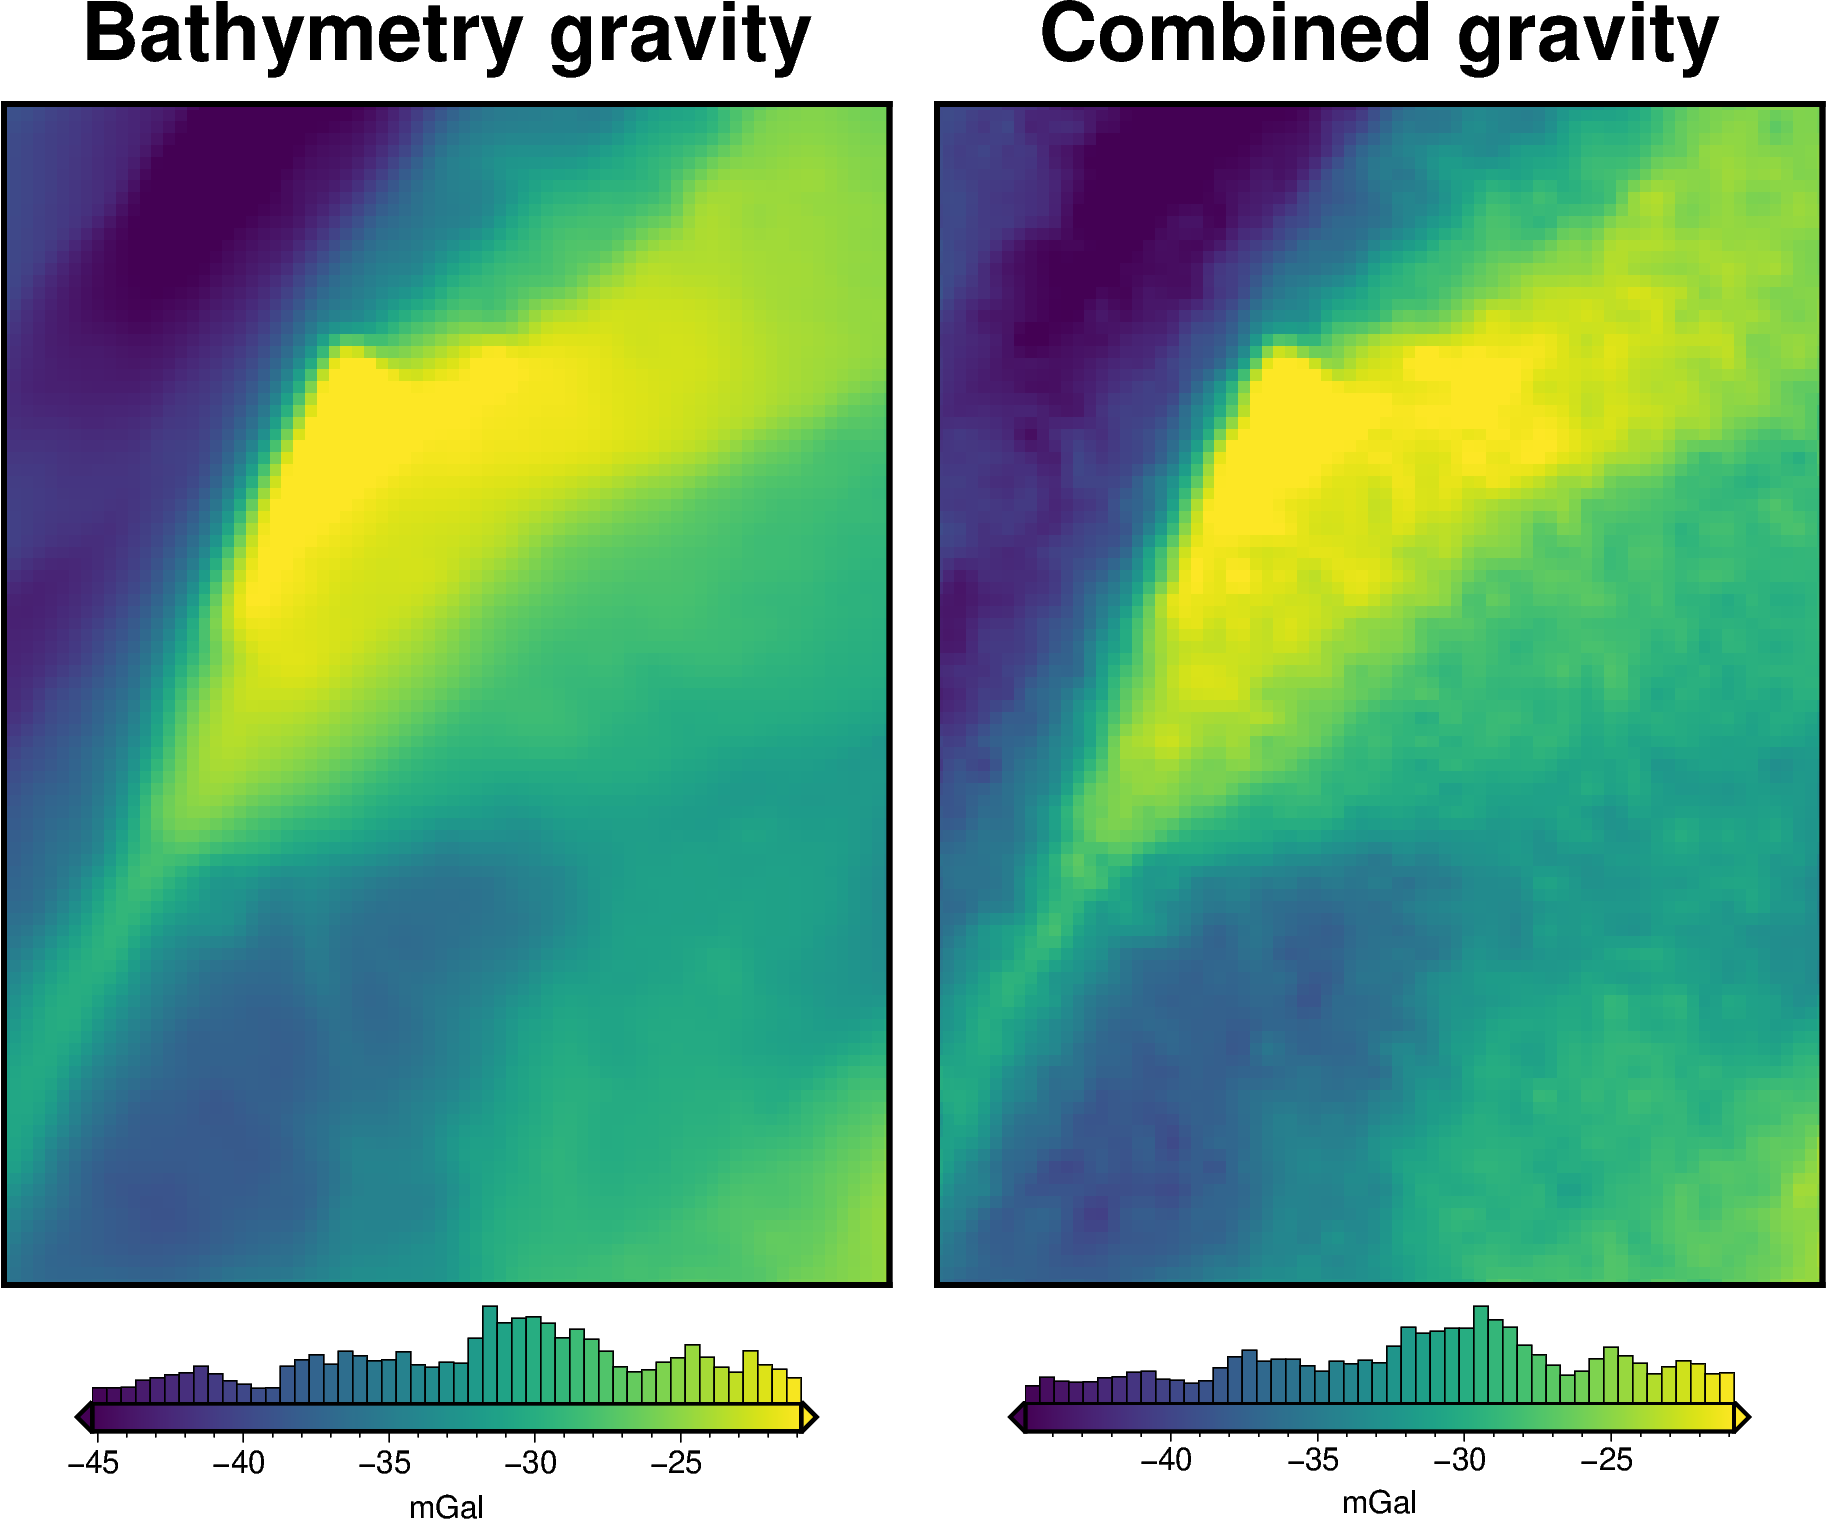

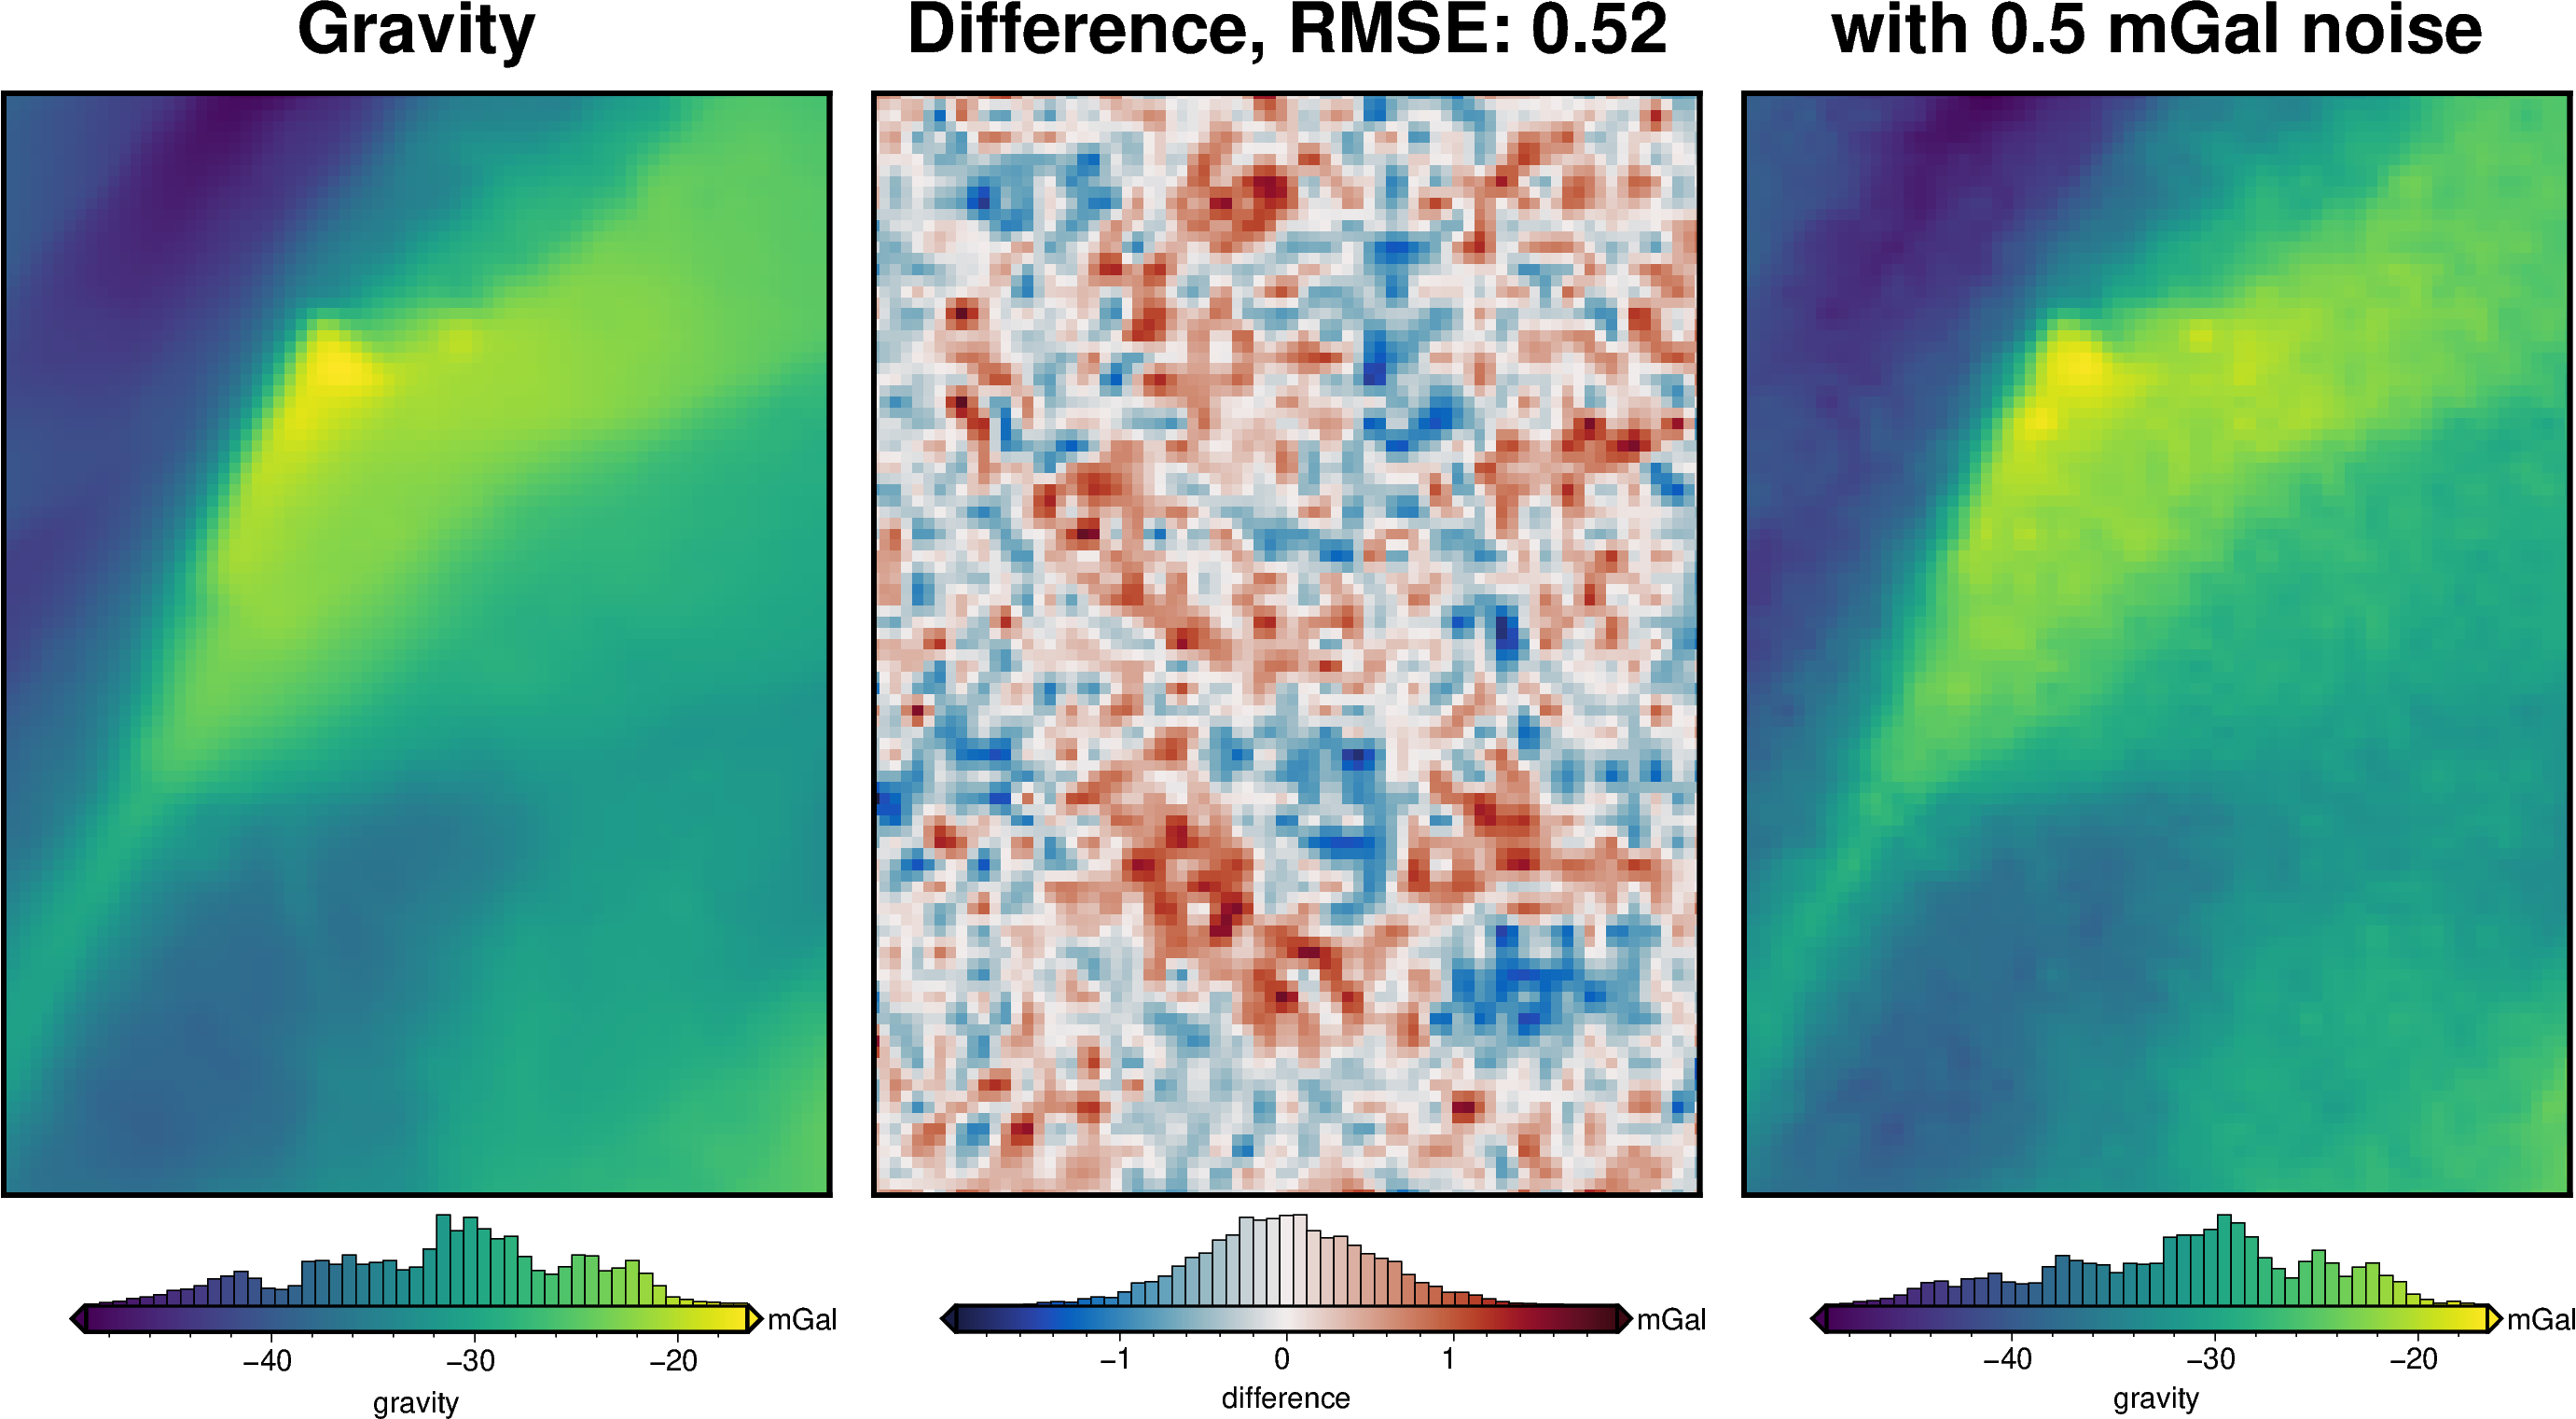

In [2]:
# set grid parameters
spacing = 2e3
inversion_region = (-40e3, 110e3, -1600e3, -1400e3)

true_density_contrast = 1476

bathymetry, basement, grav_df = RIS_synth.load_synthetic_model(
    spacing=spacing,
    inversion_region=inversion_region,
    buffer=spacing * 10,
    gravity_noise=0.5,
    gravity_noise_wavelength=20e3,
    zref=0,
    bathymetry_density_contrast=true_density_contrast,
)
buffer_region = polar_utils.get_grid_info(bathymetry)[1]

In [3]:
# grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()
# filtered_grav = utils.filter_grid(grav_grid.gravity_anomaly, 2*spacing, filt_type="lowpass")

# grav_df_filt = grav_df.copy()
# grav_df_filt["gravity_anomaly"] = filtered_grav.values.ravel()

# grav_grid = grav_df_filt.set_index(["northing", "easting"]).to_xarray()

# _ = polar_utils.grd_compare(
#     grav_grid.noise_free_disturbance,
#     grav_grid.gravity_anomaly,
#     grid1_name="Noise-free",
#     grid2_name="with noise and filtered",
#     region=inversion_region,
#     plot=True,
#     hist=True,
#     inset=False,
# )

In [4]:
# grav_df["gravity_anomaly"] = grav_df_filt.gravity_anomaly

# Make starting bathymetry model

In [5]:
# semi-regularly spaced
constraint_points = RIS_synth.constraint_layout_number(
    shape=(4, 5),
    region=inversion_region,
    padding=-spacing,
    shapefile="../../data/Ross_Sea_outline.shp",
    add_outside_points=True,
    grid_spacing=spacing,
)

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points,
    bathymetry,
    "true_upward",
    coord_names=("easting", "northing"),
)
constraint_points["upward"] = constraint_points.true_upward
constraint_points.head()

northing  easting  inside  true_upward      upward
0 -1600000.0 -40000.0   False  -601.093811 -601.093811
1 -1600000.0 -38000.0   False  -609.216797 -609.216797
2 -1600000.0 -36000.0   False  -616.356018 -616.356018
3 -1600000.0 -34000.0   False  -621.262207 -621.262207
4 -1600000.0 -32000.0   False  -625.510864 -625.510864

In [6]:
# grid the sampled values using verde
starting_topography_kwargs = dict(
    method="splines",
    region=buffer_region,
    spacing=spacing,
    constraints_df=constraint_points,
    dampings=None,
)
starting_bathymetry = utils.create_topography(**starting_topography_kwargs)

starting_bathymetry

<xarray.DataArray 'scalars' (northing: 121, easting: 96)> Size: 93kB
array([[-540.85324708, -544.21519109, -547.59855677, ..., -359.77829766,
        -356.84097116, -353.9671395 ],
       [-542.96903012, -546.47710941, -550.04617896, ..., -362.70499047,
        -359.76544554, -356.90451862],
       [-544.69488138, -548.33638995, -552.08554336, ..., -365.48679147,
        -362.55156299, -359.71215141],
       ...,
       [-591.97428035, -595.54194913, -599.09350427, ..., -440.93897354,
        -440.74704981, -440.46522382],
       [-590.54905826, -594.11158059, -597.66425625, ..., -440.7362303 ,
        -440.47619558, -440.129527  ],
       [-589.18119782, -592.75387759, -596.32448457, ..., -440.56111512,
        -440.22075739, -439.79986662]])
Coordinates:
  * easting   (easting) float64 768B -6e+04 -5.8e+04 ... 1.28e+05 1.3e+05
  * northing  (northing) float64 968B -1.62e+06 -1.618e+06 ... -1.38e+06
Attributes:
    metadata:  Generated by SplineCV(cv=KFold(n_splits=5, random_state=0, shu...
    damping:   None

In [7]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    starting_bathymetry,
    "starting_bathymetry",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.starting_bathymetry)
print(f"RMSE: {rmse:.2f} m")

RMSE: 0.01 m


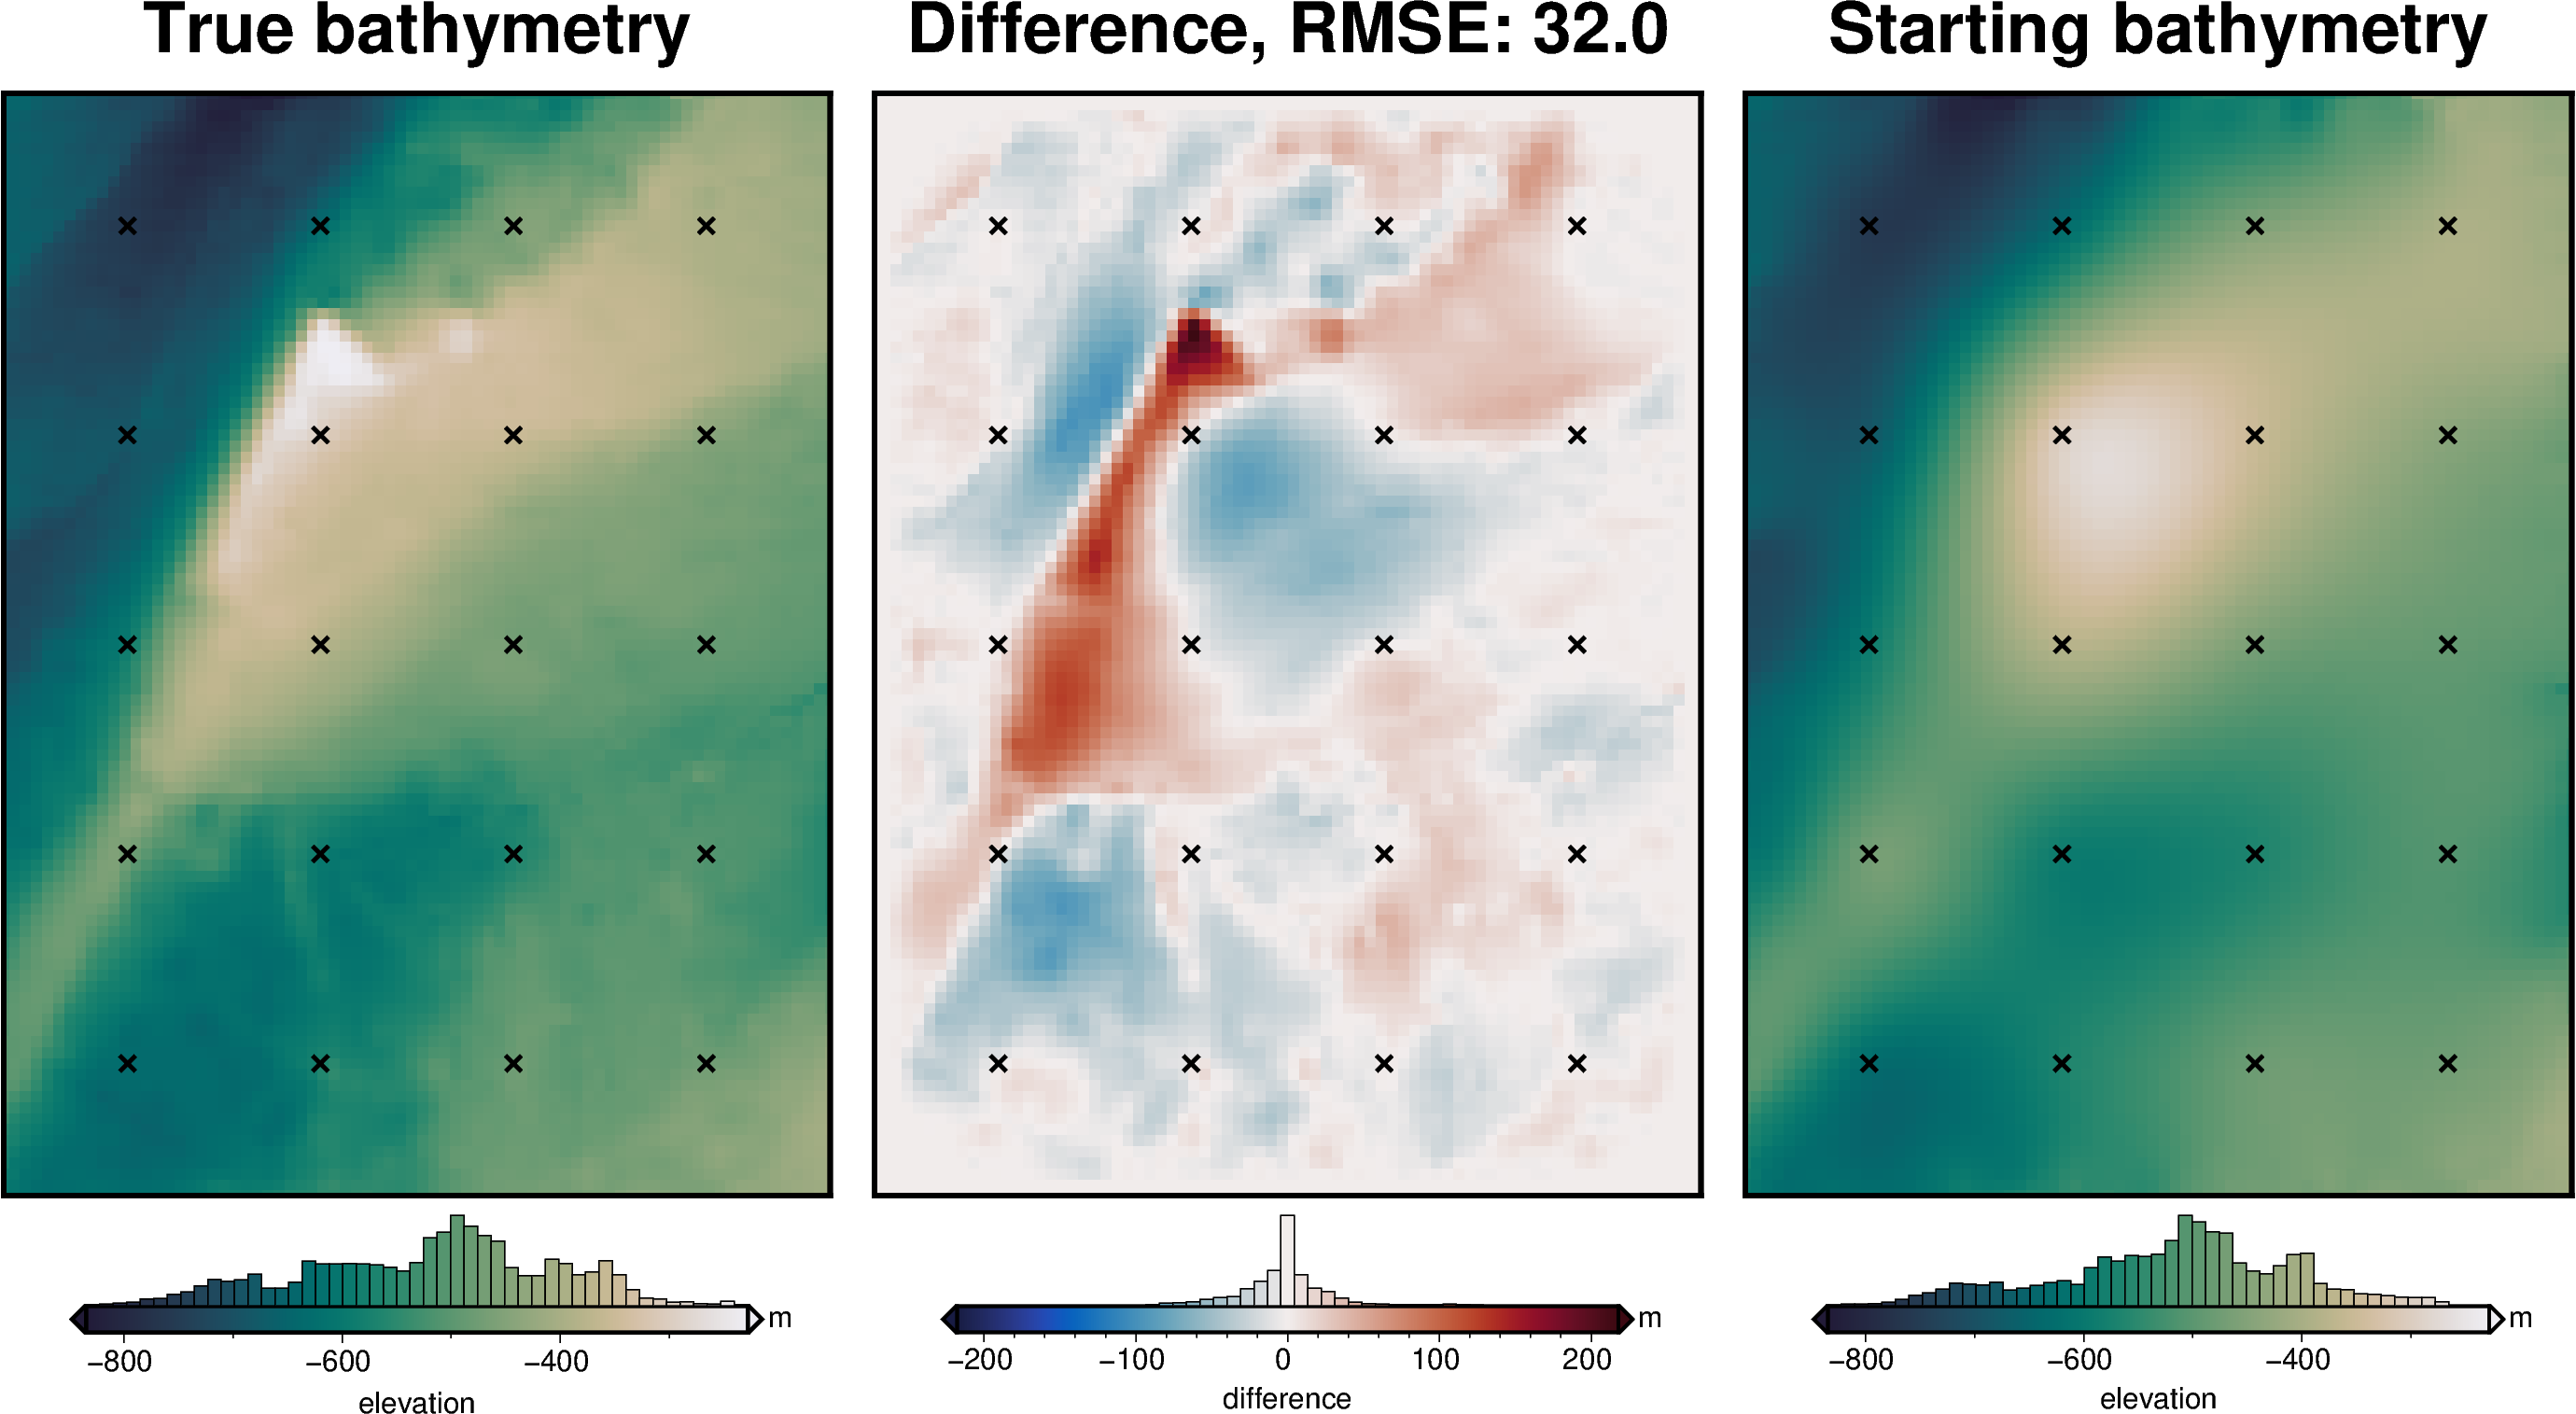

In [8]:
# compare starting and actual bathymetry grids
grids = polar_utils.grd_compare(
    bathymetry,
    starting_bathymetry,
    fig_height=10,
    plot=True,
    plot_type="pygmt",
    cmap="rain",
    reverse_cpt=True,
    diff_cmap="balance+h0",
    grid1_name="True bathymetry",
    grid2_name="Starting bathymetry",
    title="Difference",
    title_font="18p,Helvetica-Bold,black",
    cbar_unit="m",
    cbar_label="elevation",
    RMSE_decimals=0,
    region=inversion_region,
    inset=False,
    hist=True,
    cbar_yoffset=1,
    label_font="16p,Helvetica,black",
    points=constraint_points[constraint_points.inside],
    points_style="x.2c",
)

In [9]:
# the true density contrast is 1476 kg/m3
density_contrast = 1350

# set the reference level from the prisms to 0
zref = 0

density_grid = xr.where(
    starting_bathymetry >= zref,
    density_contrast,
    -density_contrast,
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_bathymetry,
    zref,
    density=density_grid,
)

grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df

  0%|          | 0/7676 [00:00<?, ?it/s]

northing   easting  upward  bathymetry_grav  basement_grav  \
0    -1600000.0  -40000.0  1000.0       -35.551041              0   
1    -1600000.0  -38000.0  1000.0       -36.054652              0   
2    -1600000.0  -36000.0  1000.0       -36.473148              0   
3    -1600000.0  -34000.0  1000.0       -36.755612              0   
4    -1600000.0  -32000.0  1000.0       -36.951032              0   
...         ...       ...     ...              ...            ...   
7671 -1400000.0  102000.0  1000.0       -25.760380              0   
7672 -1400000.0  104000.0  1000.0       -25.911731              0   
7673 -1400000.0  106000.0  1000.0       -26.033127              0   
7674 -1400000.0  108000.0  1000.0       -26.122232              0   
7675 -1400000.0  110000.0  1000.0       -26.206510              0   

      noise_free_disturbance  disturbance  uncert  gravity_anomaly  \
0                 -35.551041   -35.942534     0.5       -35.942534   
1                 -36.054652   -36.625209     0.5       -36.625209   
2                 -36.473148   -37.162006     0.5       -37.162006   
3                 -36.755612   -37.416456     0.5       -37.416456   
4                 -36.951032   -37.446512     0.5       -37.446512   
...                      ...          ...     ...              ...   
7671              -25.760380   -25.284401     0.5       -25.284401   
7672              -25.911731   -25.230549     0.5       -25.230549   
7673              -26.033127   -25.230409     0.5       -25.230409   
7674              -26.122232   -25.384692     0.5       -25.384692   
7675              -26.206510   -25.608360     0.5       -25.608360   

      starting_gravity  
0           -32.531726  
1           -32.955392  
2           -33.336163  
3           -33.631767  
4           -33.825918  
...                ...  
7671        -23.326855  
7672        -23.487013  
7673        -23.610099  
7674        -23.697322  
7675        -23.767655  

[7676 rows x 10 columns]

In [10]:
regional_grav_kwargs = dict(
    method="constant",
    # constant=0,
    constraints_df=constraint_points,
)
grav_df = regional.regional_separation(
    grav_df=grav_df,
    **regional_grav_kwargs,
)

grav_df

INFO:invert4geom:using median gravity misfit of constraint points for regional field: -2.8610037565231323 mGal


northing   easting  upward  bathymetry_grav  basement_grav  \
0    -1600000.0  -40000.0  1000.0       -35.551041              0   
1    -1600000.0  -38000.0  1000.0       -36.054652              0   
2    -1600000.0  -36000.0  1000.0       -36.473148              0   
3    -1600000.0  -34000.0  1000.0       -36.755612              0   
4    -1600000.0  -32000.0  1000.0       -36.951032              0   
...         ...       ...     ...              ...            ...   
7671 -1400000.0  102000.0  1000.0       -25.760380              0   
7672 -1400000.0  104000.0  1000.0       -25.911731              0   
7673 -1400000.0  106000.0  1000.0       -26.033127              0   
7674 -1400000.0  108000.0  1000.0       -26.122232              0   
7675 -1400000.0  110000.0  1000.0       -26.206510              0   

      noise_free_disturbance  disturbance  uncert  gravity_anomaly  \
0                 -35.551041   -35.942534     0.5       -35.942534   
1                 -36.054652   -36.625209     0.5       -36.625209   
2                 -36.473148   -37.162006     0.5       -37.162006   
3                 -36.755612   -37.416456     0.5       -37.416456   
4                 -36.951032   -37.446512     0.5       -37.446512   
...                      ...          ...     ...              ...   
7671              -25.760380   -25.284401     0.5       -25.284401   
7672              -25.911731   -25.230549     0.5       -25.230549   
7673              -26.033127   -25.230409     0.5       -25.230409   
7674              -26.122232   -25.384692     0.5       -25.384692   
7675              -26.206510   -25.608360     0.5       -25.608360   

      starting_gravity    misfit       reg       res  
0           -32.531726 -3.410808 -2.861004 -0.549805  
1           -32.955392 -3.669817 -2.861004 -0.808813  
2           -33.336163 -3.825843 -2.861004 -0.964839  
3           -33.631767 -3.784689 -2.861004 -0.923685  
4           -33.825918 -3.620594 -2.861004 -0.759590  
...                ...       ...       ...       ...  
7671        -23.326855 -1.957546 -2.861004  0.903458  
7672        -23.487013 -1.743535 -2.861004  1.117468  
7673        -23.610099 -1.620310 -2.861004  1.240694  
7674        -23.697322 -1.687370 -2.861004  1.173633  
7675        -23.767655 -1.840705 -2.861004  1.020298  

[7676 rows x 13 columns]

makecpt [ERROR]: Option T: min >= max


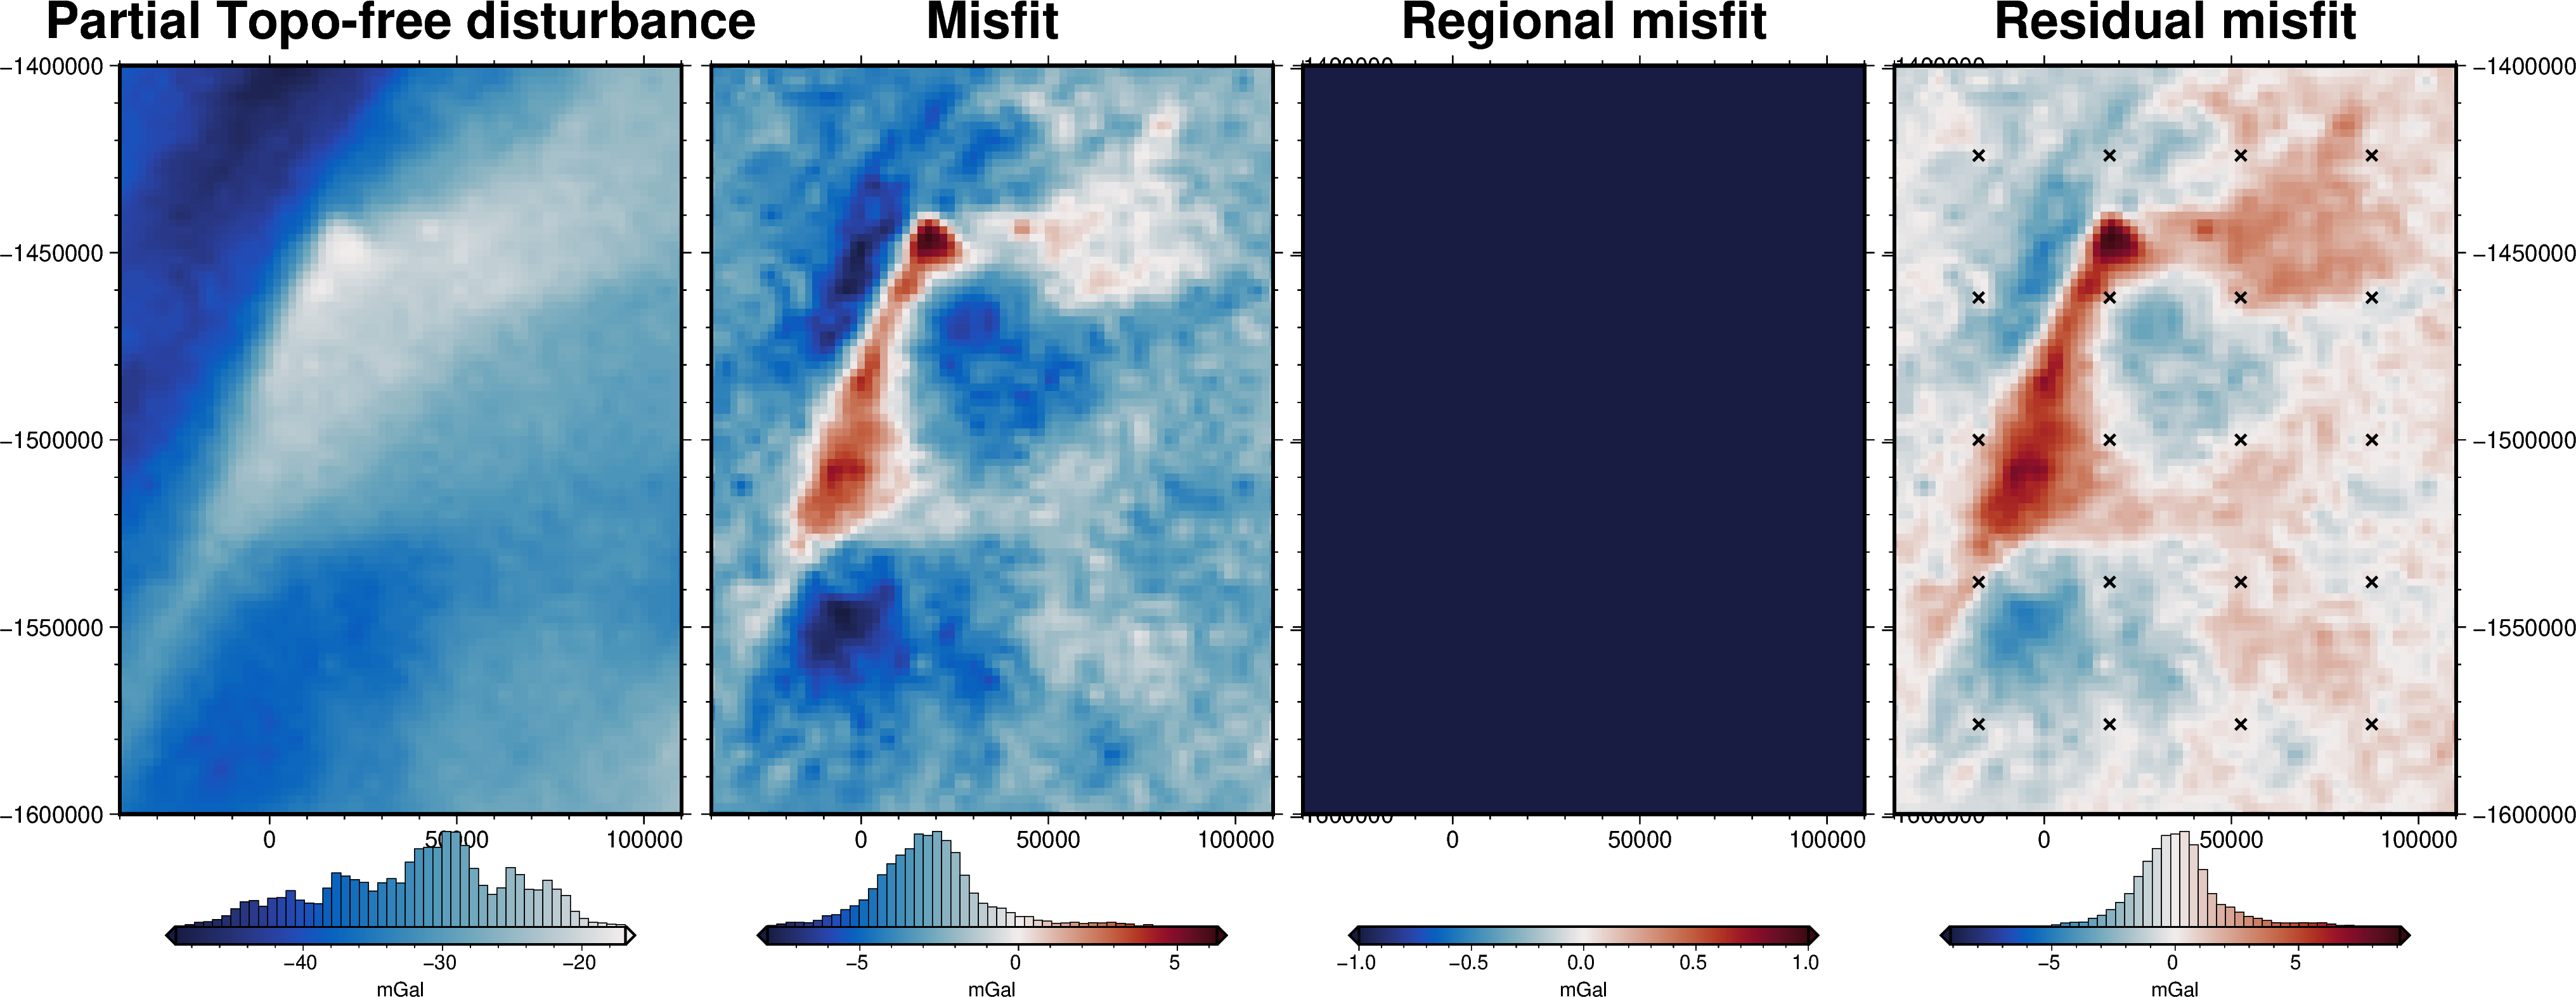

In [11]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    region=inversion_region,
    fig_height=10,
    title="Partial Topo-free disturbance",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.misfit,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Misfit",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.reg,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Regional misfit",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.res,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Residual misfit",
    cmap="balance+h0",
    cpt_lims=[-vd.maxabs(grav_grid.res), vd.maxabs(grav_grid.res)],
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
    points=constraint_points[constraint_points.inside],
    points_style="x.2c",
)
fig.show()

In [12]:
# set kwargs to pass to the inversion
kwargs = {
    # set stopping criteria
    "max_iterations": 200,
    "l2_norm_tolerance": grav_df.uncert.mean()
    ** 0.5,  # square root of the gravity noise
    "delta_l2_norm_tolerance": 1.008,
}

# Damping Cross Validation

In [18]:
logging.getLogger().setLevel(logging.INFO)

# run the inversion workflow, including a cross validation for the damping parameter
results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    starting_prisms=starting_prisms,
    # for creating test/train splits
    grav_spacing=spacing,
    inversion_region=inversion_region,
    run_damping_cv=True,
    damping_limits=(0.001, 0.1),
    damping_cv_trials=8,
    # damping_cv_startup_trials=6, # force 6 startup trials in grid search
    # plot_cv=True,
    # plot_grids=True,
    fname="../../results/Ross_Sea_04_damping_cv",
    **kwargs,
)

INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_04_damping_cv'
INFO:invert4geom:running damping cross validation
INFO:invert4geom:using 4 startup trials


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 7
INFO:invert4geom:	parameter: {'damping': 0.010731460150454005}
INFO:invert4geom:	scores: [0.043583758853946074]
INFO:invert4geom:results saved to ../../results/Ross_Sea_04_damping_cv_results.pickle.pickle


In [13]:
# load saved inversion results
with pathlib.Path("../../results/Ross_Sea_04_damping_cv_results.pickle").open(
    "rb"
) as f:
    results = pickle.load(f)

# load study
with pathlib.Path("../../results/Ross_Sea_04_damping_cv_damping_cv_study.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

In [14]:
best_damping = parameters.get("Solver damping")
kwargs["solver_damping"] = best_damping
best_damping

0.010731460150454005

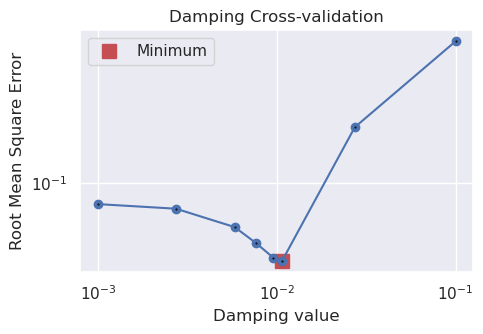

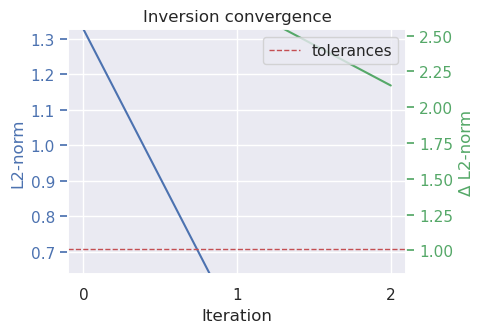

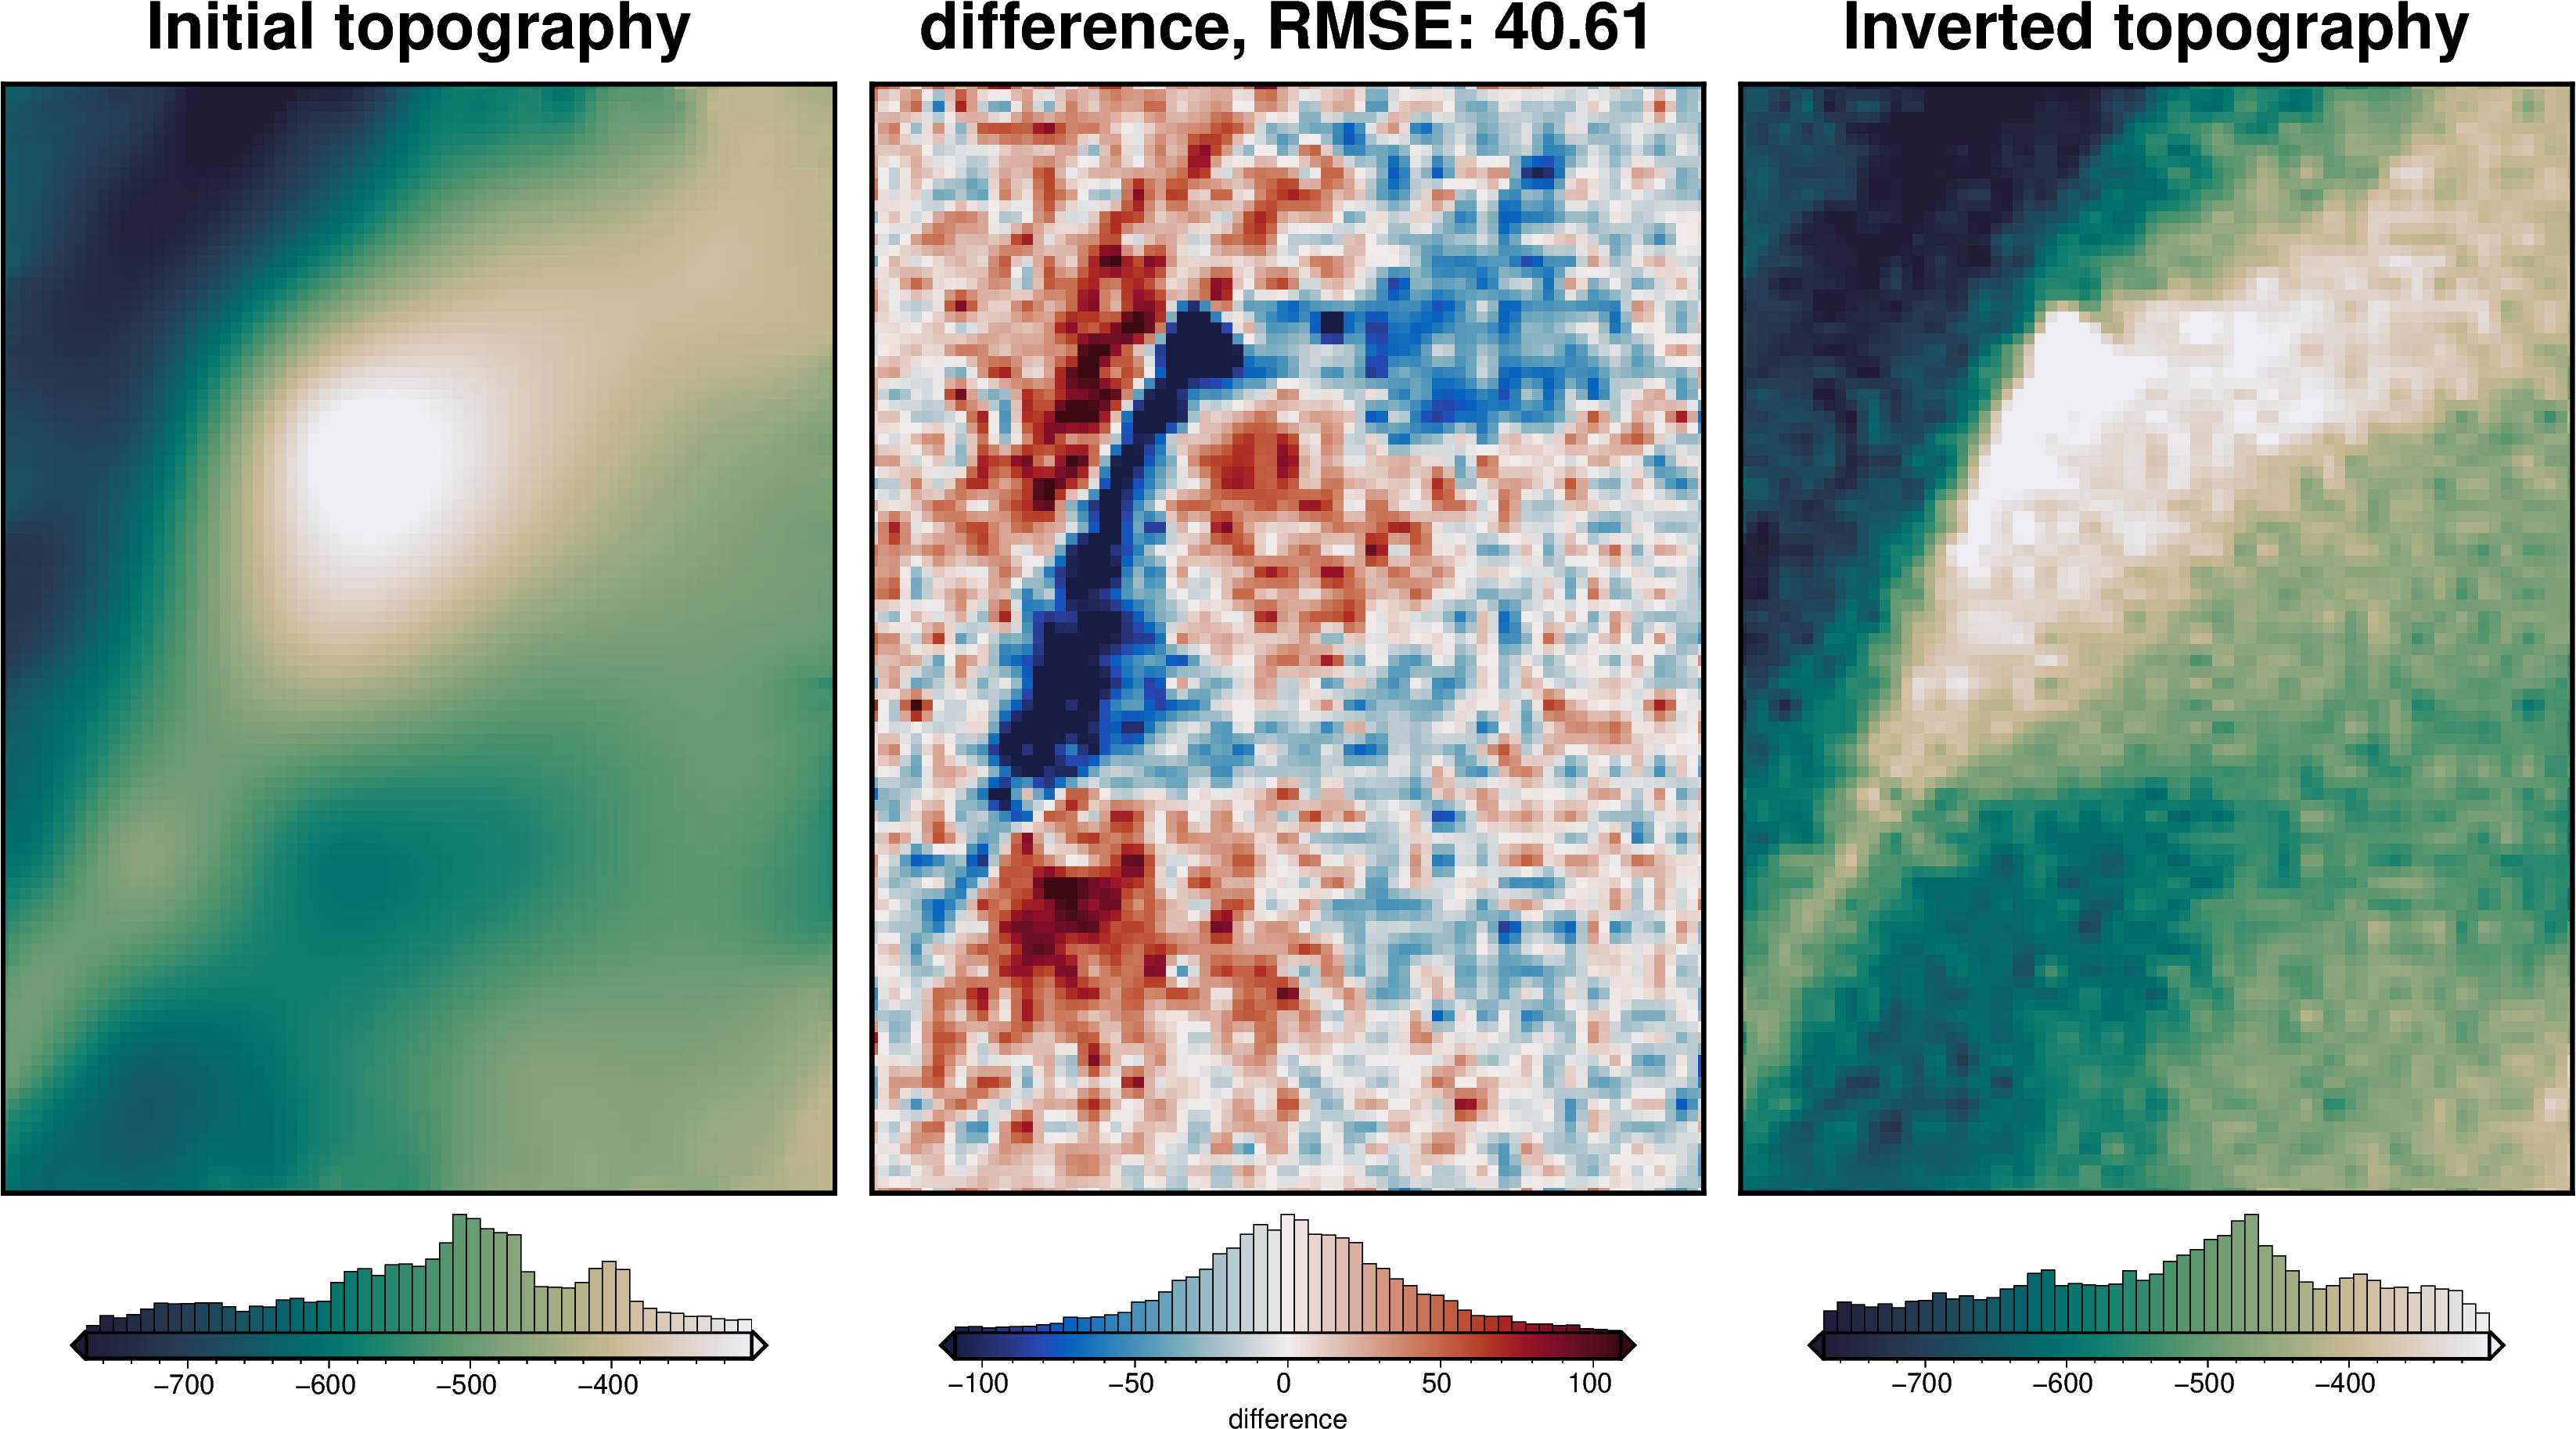

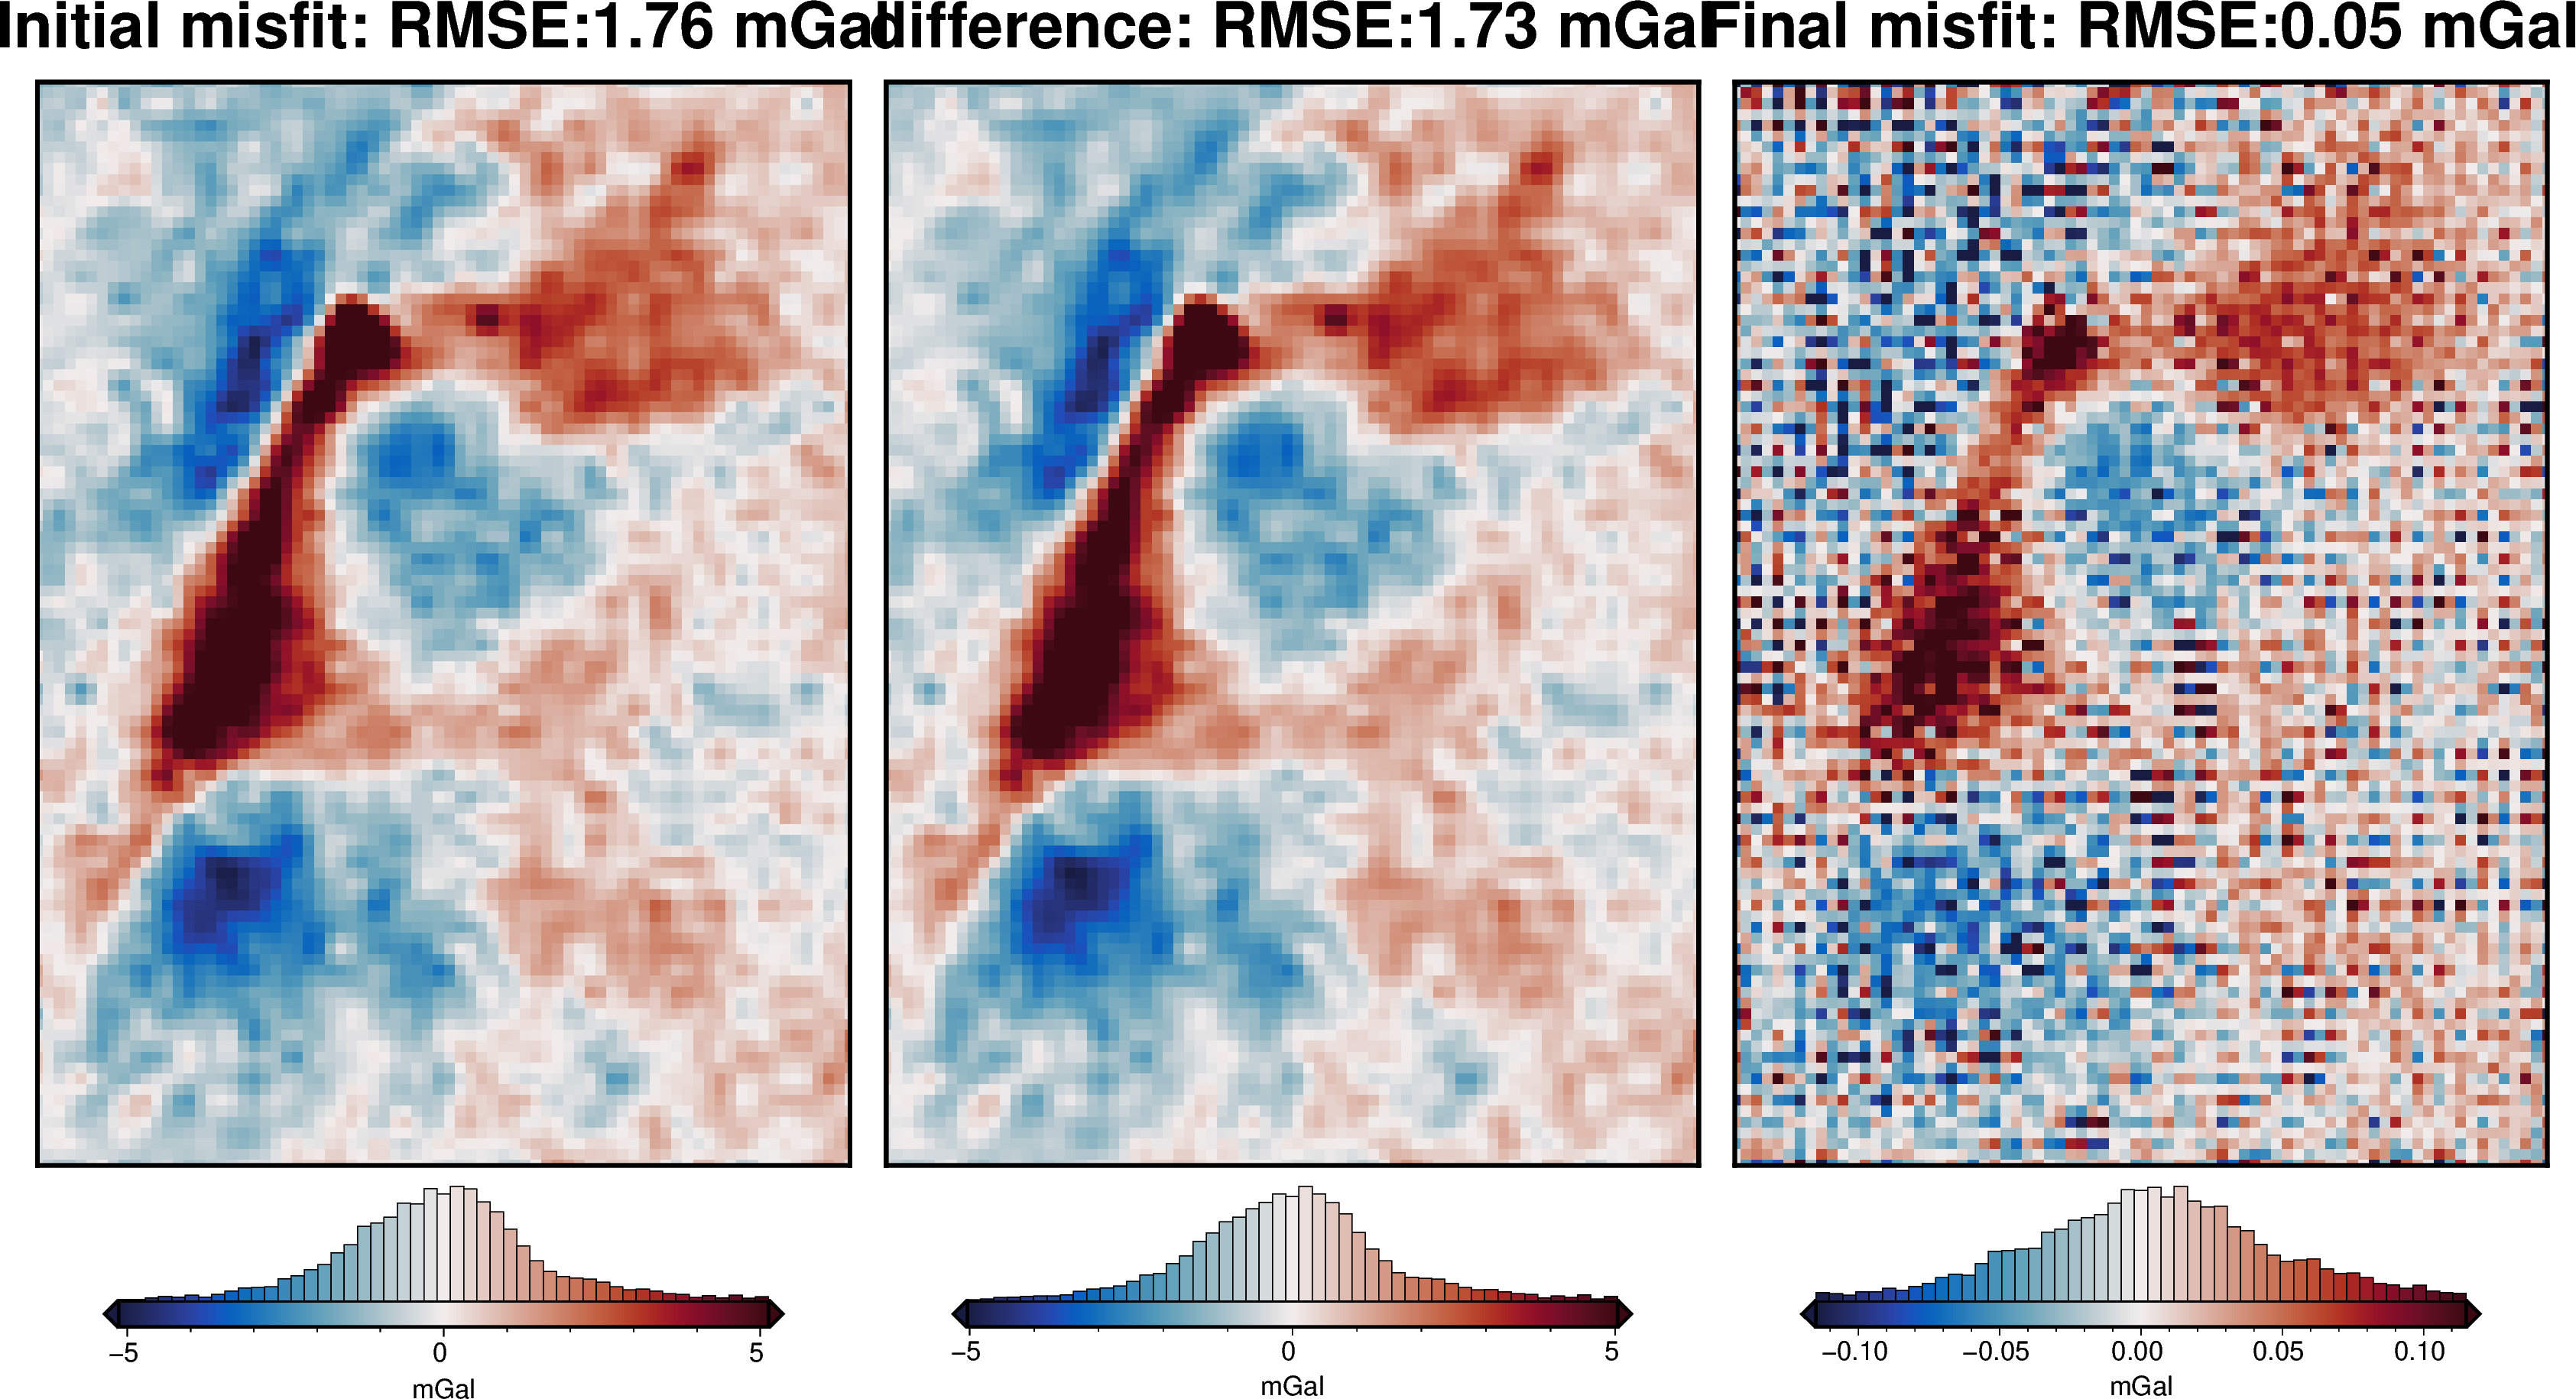

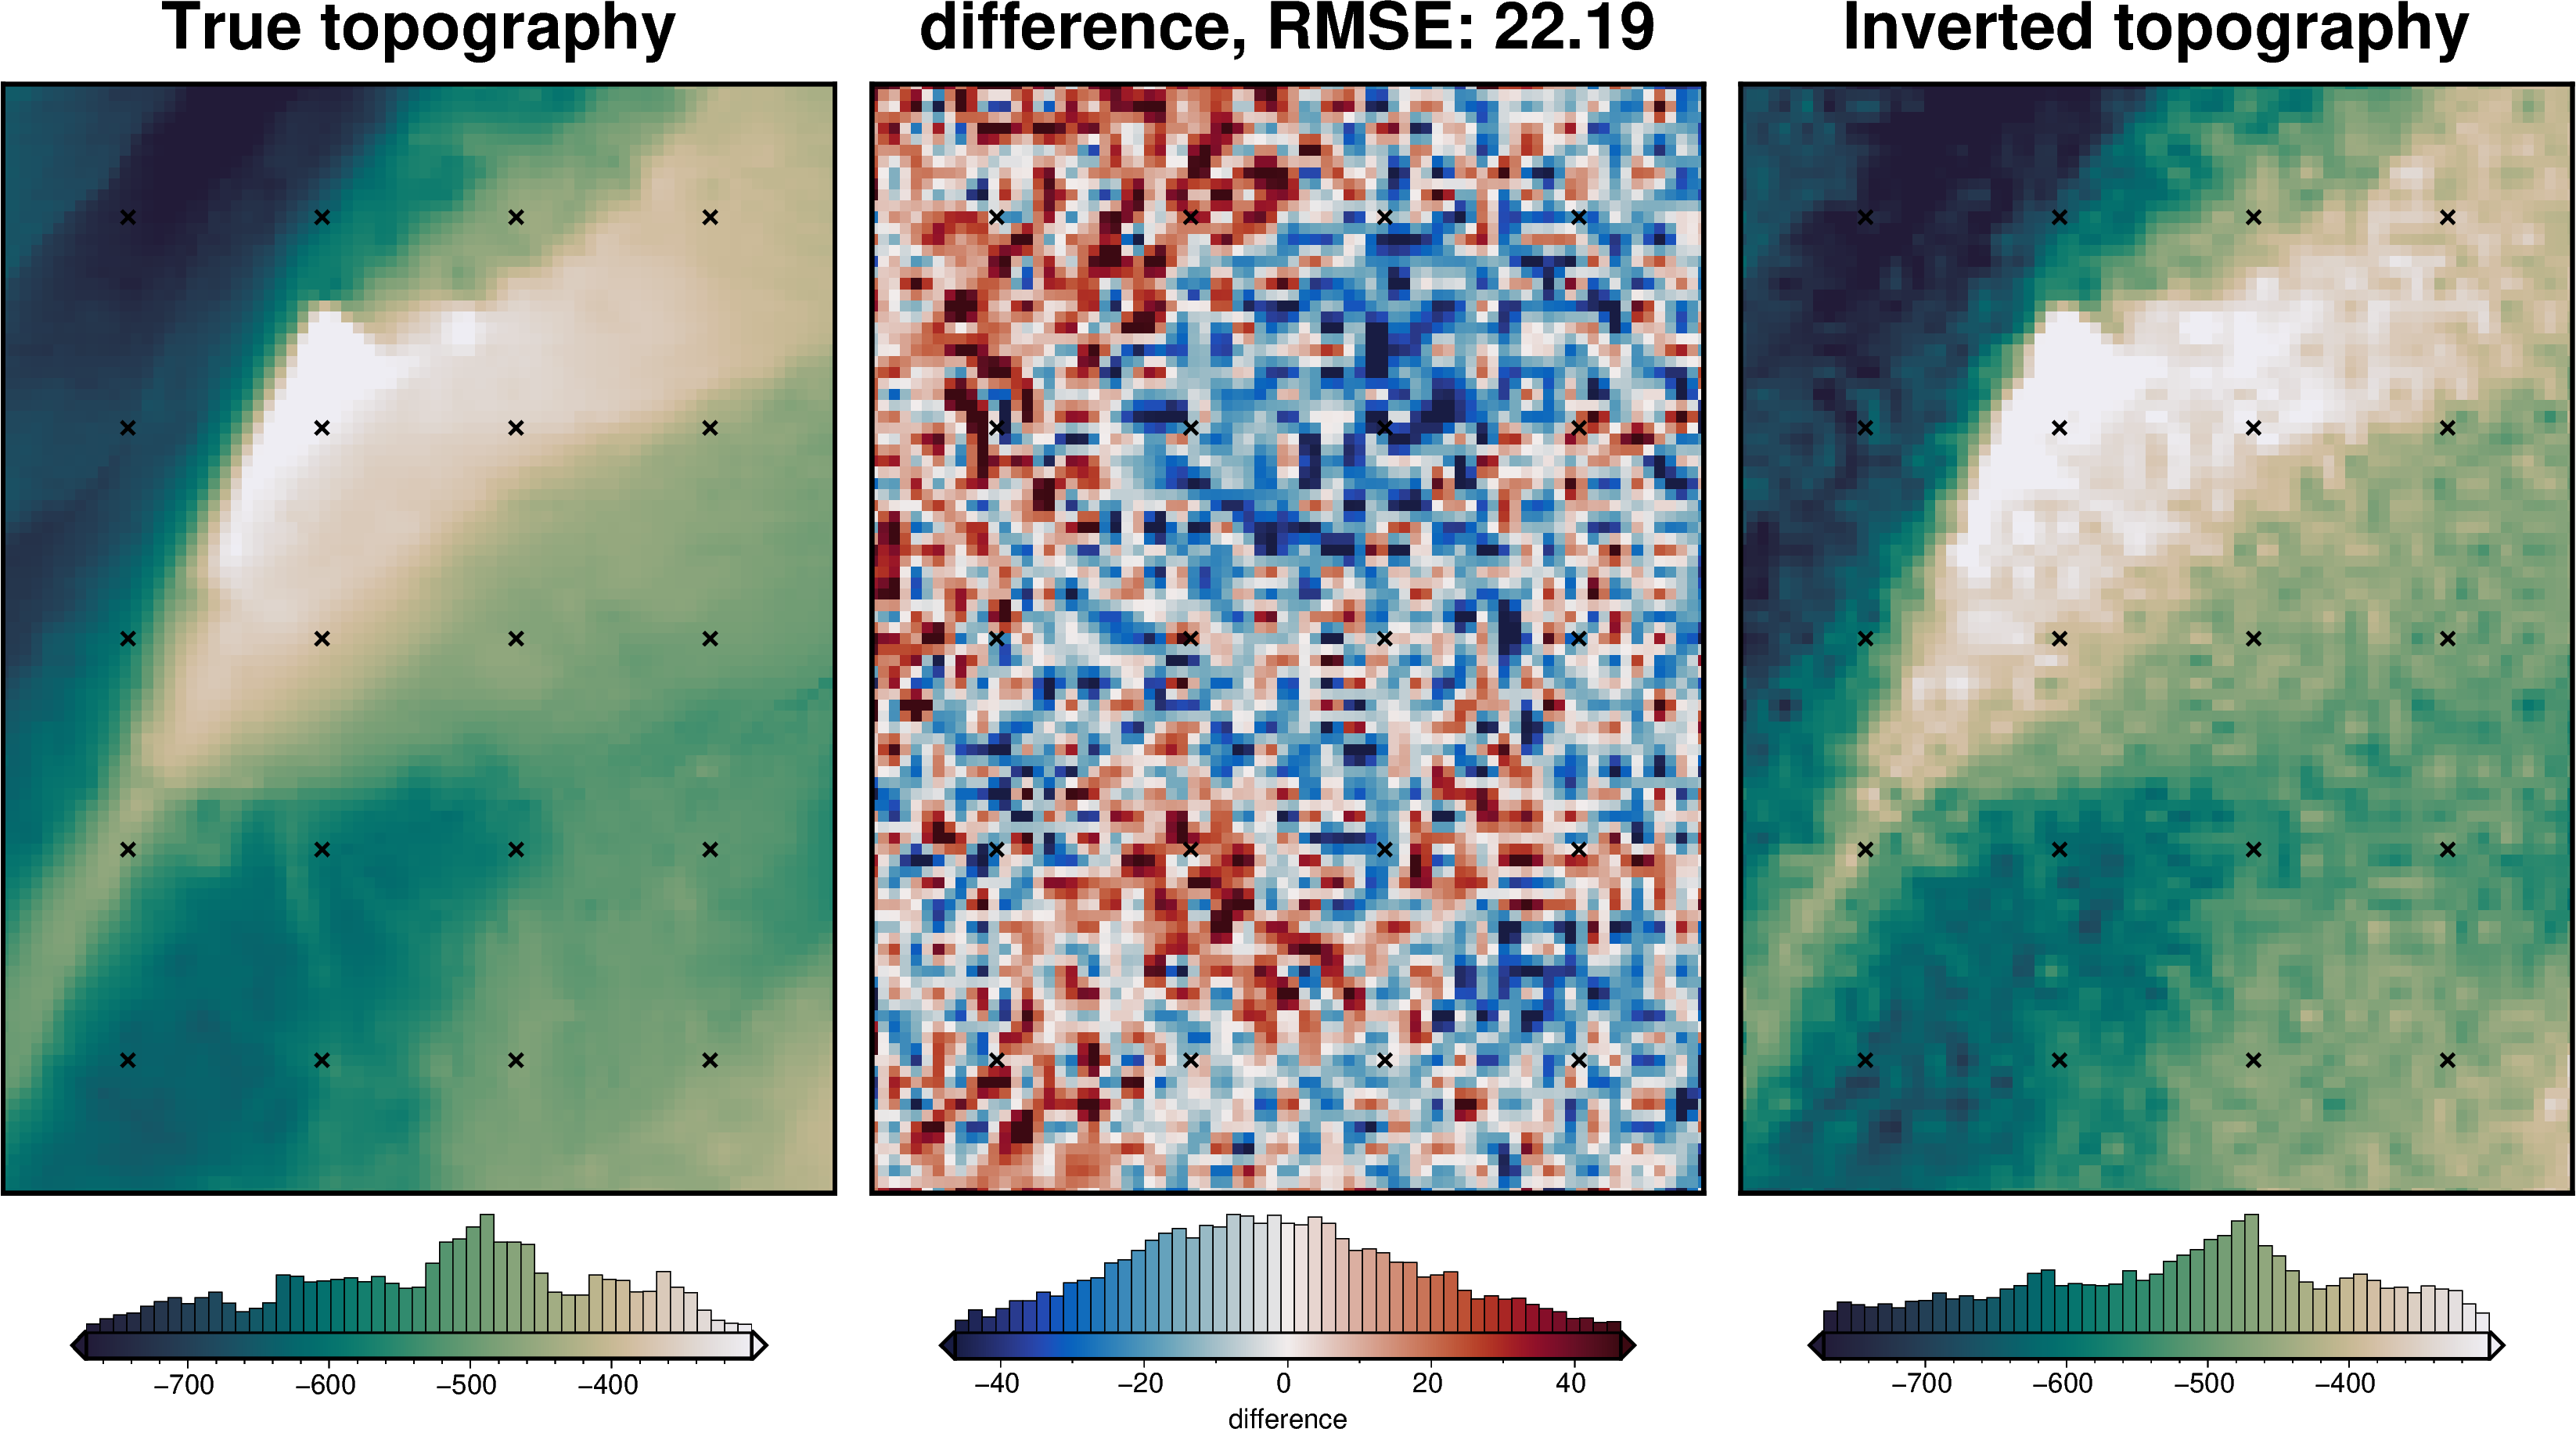

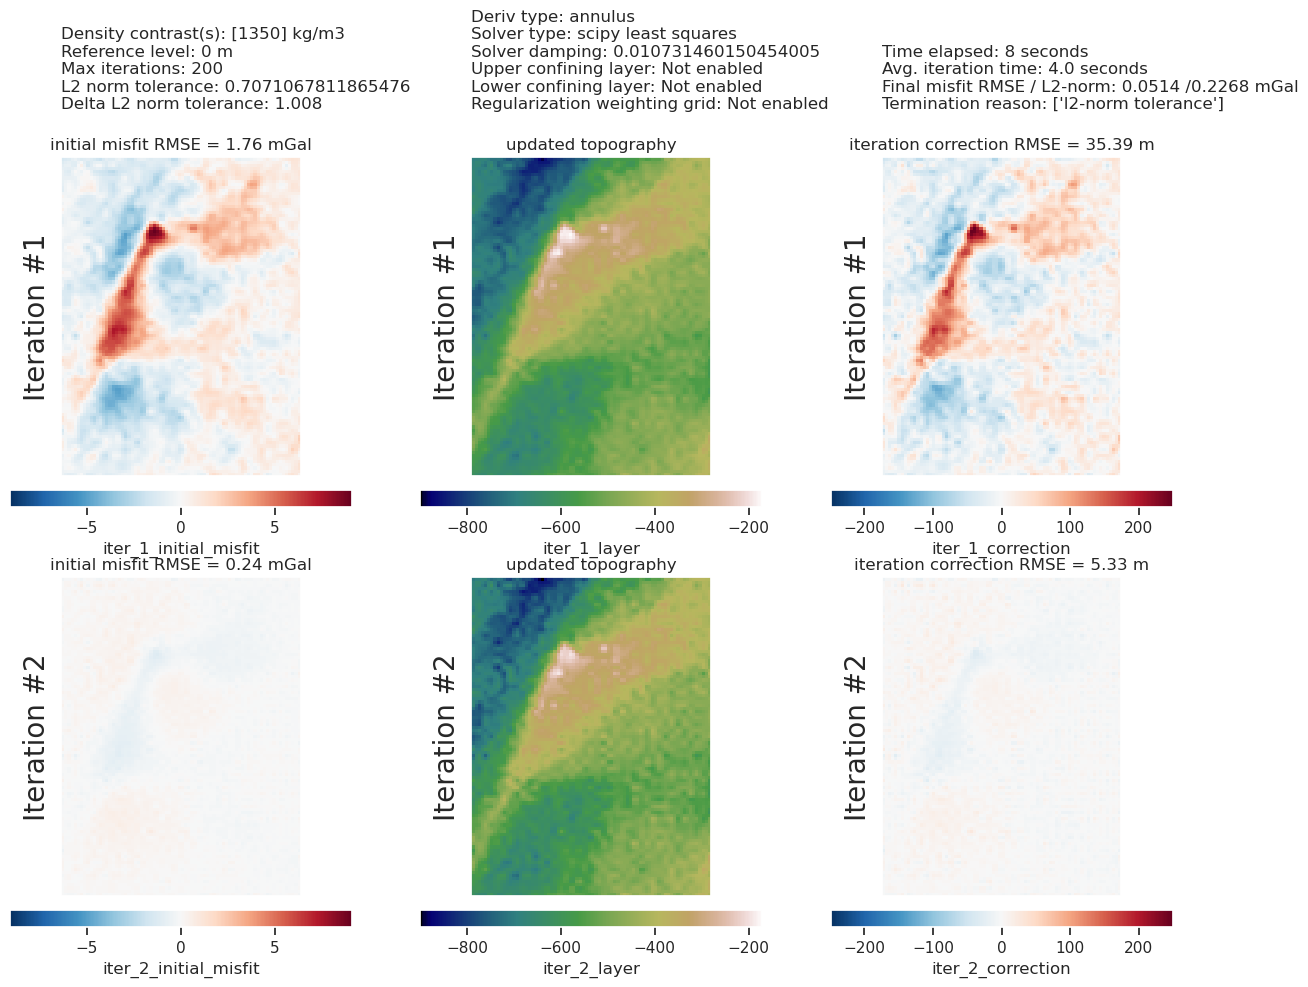

In [15]:
study_df = study.trials_dataframe()

plotting.plot_cv_scores(
    study_df.value,
    study_df.params_damping,
    param_name="Damping",
    logx=True,
    logy=True,
)

plotting.plot_convergence(
    grav_results,
    params=parameters,
)

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    bathymetry,
    final_topography,
    region=inversion_region,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points[constraint_points.inside],
    points_style="x.2c",
)

In [16]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 23.21 m


# Density CV

In [23]:
logging.getLogger().setLevel(logging.INFO)

# run the inversion workflow, including a cross validation for the damping parameter
results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    starting_topography=starting_bathymetry,
    zref=0,
    calculate_regional_misfit=True,
    # regional_grav_kwargs=regional_grav_kwargs,
    regional_grav_kwargs=dict(
        grav_df=grav_df,
        method="constant",
        constant=0,
    ),
    run_zref_or_density_cv=True,
    constraints_df=constraint_points,
    density_contrast_limits=(1300, 1600),
    zref_density_cv_trials=10,
    # plot_cv=True,
    fname="../../results/Ross_Sea_04_density_cv",
    **kwargs,
)

INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_04_density_cv'
INFO:invert4geom:running zref and/or density contrast cross validation
INFO:invert4geom:using 4 startup trials


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 4
INFO:invert4geom:	parameter: {'density_contrast': 1478}
INFO:invert4geom:	scores: [18.561760338347778]
INFO:invert4geom:results saved to ../../results/Ross_Sea_04_density_cv_results.pickle


In [17]:
# load saved inversion results
with pathlib.Path("../../results/Ross_Sea_04_density_cv_results.pickle").open(
    "rb"
) as f:
    results = pickle.load(f)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results


# load study
with pathlib.Path(
    "../../results/Ross_Sea_04_density_cv_zref_density_cv_study.pickle"
).open("rb") as f:
    study = pickle.load(f)

In [18]:
best_density_contrast = study.best_params["density_contrast"]
print("optimal determined density contrast", best_density_contrast)
print("real density contrast", true_density_contrast)

optimal determined density contrast 1478
real density contrast 1476


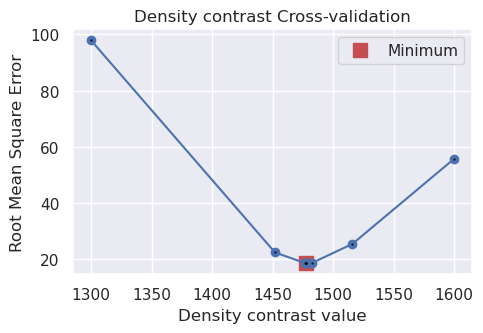

In [19]:
study_df = study.trials_dataframe()

fig = plotting.plot_cv_scores(
    study_df.value,
    study_df.params_density_contrast,
    param_name="Density contrast",
)

### Redo with optimal density contrast
During the density cross-validation to avoid biasing the scores, we had to manually set a regional field. Now, with the optimal density contrast value found, we can rerun the inversion with an automatically determined regional field strength (the average value misfit at the constraints).

In [20]:
density_contrast = best_density_contrast

density_grid = xr.where(
    starting_bathymetry >= zref,
    density_contrast,
    -density_contrast,
)
# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_bathymetry,
    zref,
    density=density_grid,
)
grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df = regional.regional_separation(
    grav_df=grav_df,
    **regional_grav_kwargs,
)

  0%|          | 0/7676 [00:00<?, ?it/s]

INFO:invert4geom:using median gravity misfit of constraint points for regional field: 0.022027121856808662 mGal


makecpt [ERROR]: Option T: min >= max


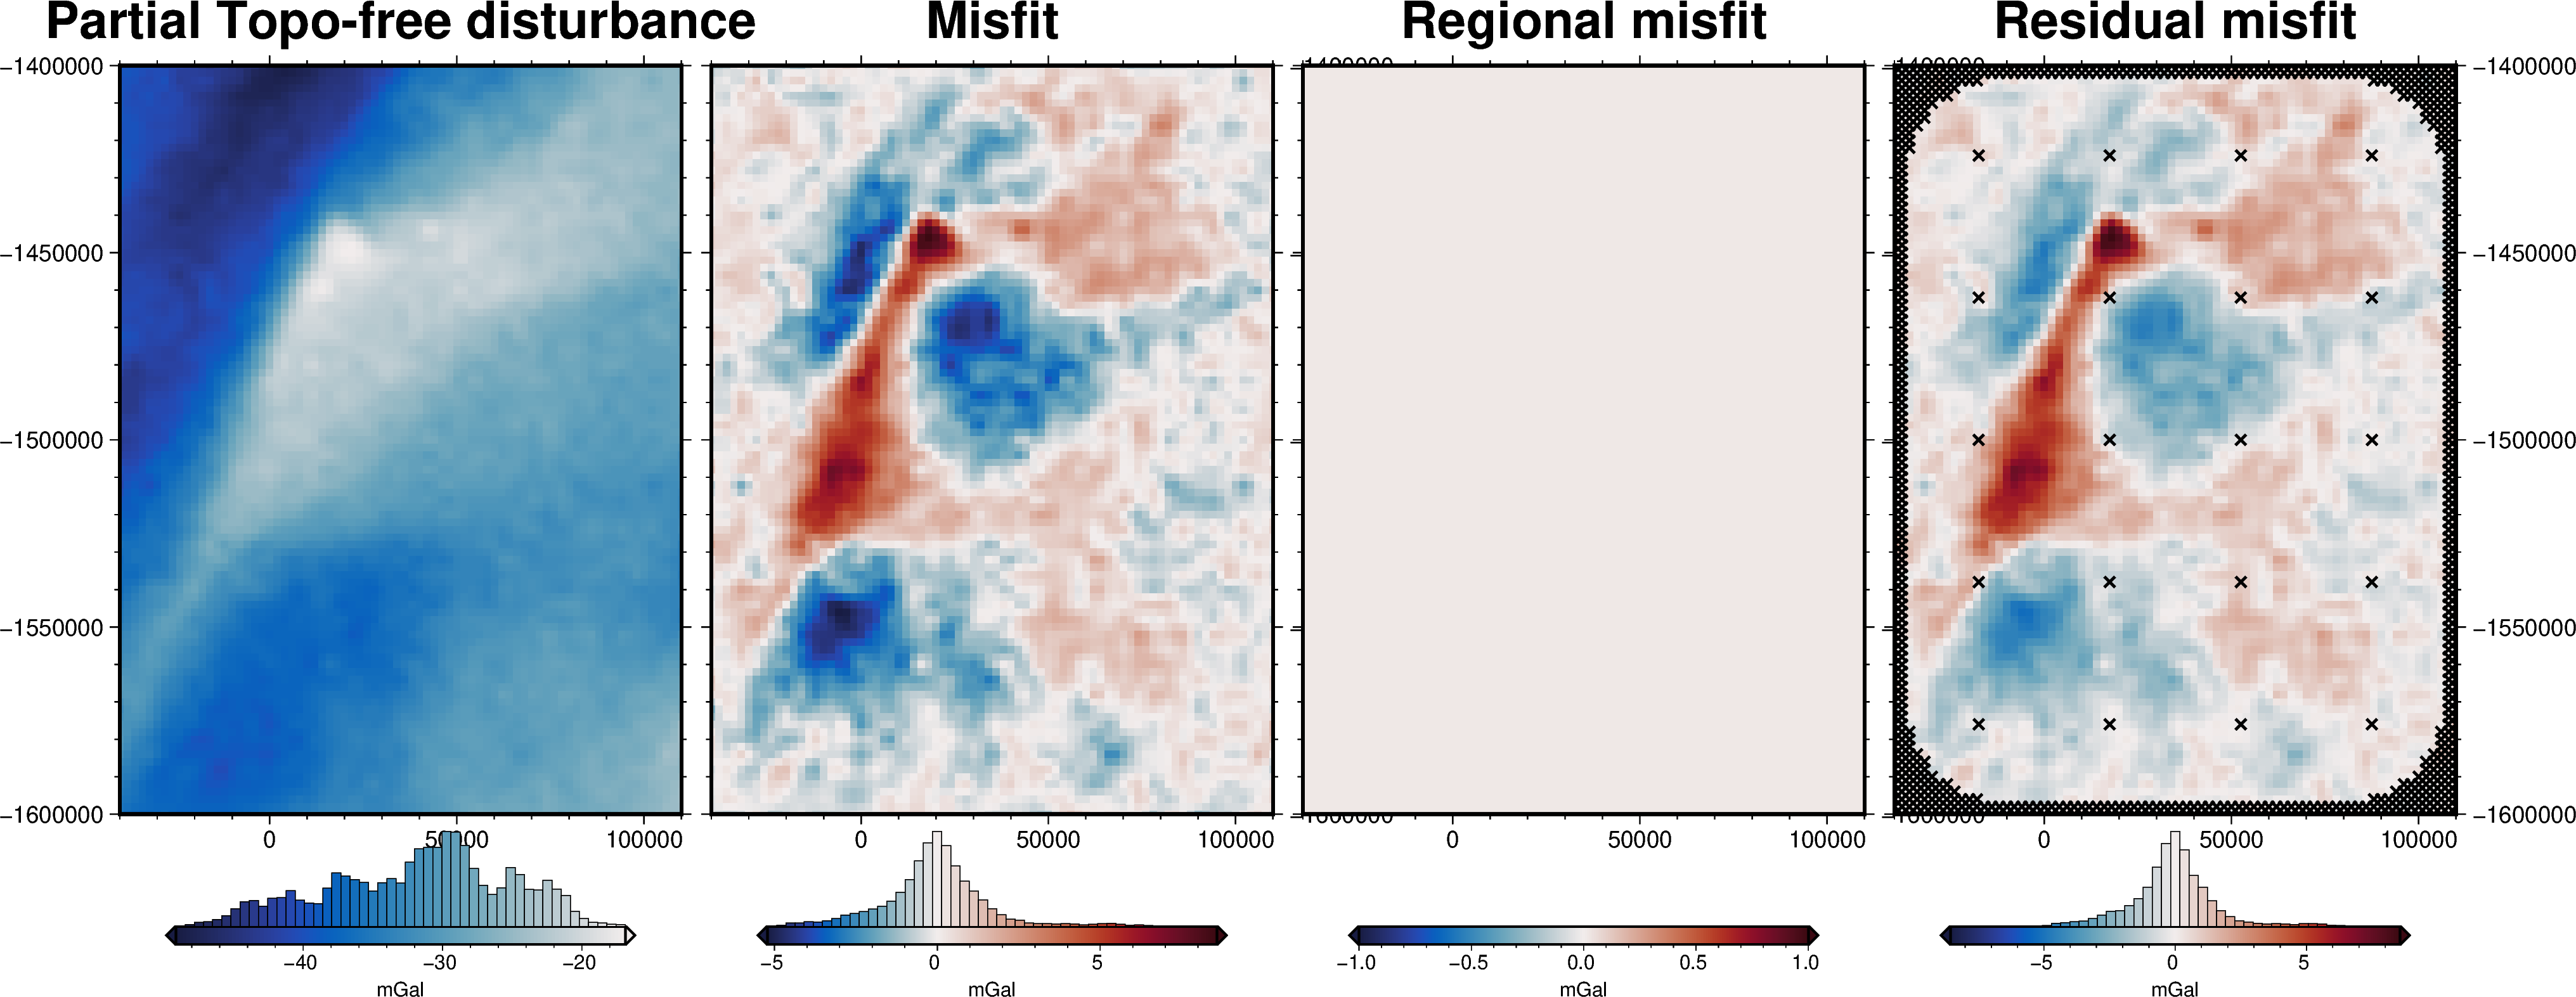

In [21]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    region=inversion_region,
    fig_height=10,
    title="Partial Topo-free disturbance",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.misfit,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Misfit",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.reg,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Regional misfit",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.res,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Residual misfit",
    cmap="balance+h0",
    cpt_lims=[-vd.maxabs(grav_grid.res), vd.maxabs(grav_grid.res)],
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
    points=constraint_points,
    points_style="x.2c",
)
fig.show()

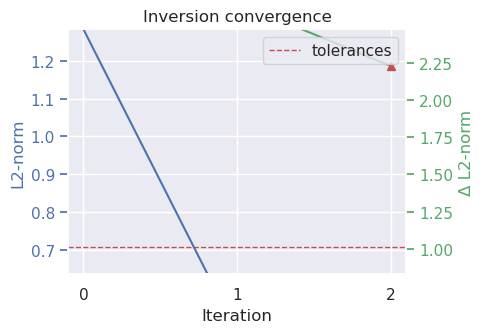

In [29]:
# run the inversion workflow
inversion_results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    fname="../../results/Ross_Sea_04_optimal",
    starting_prisms=starting_prisms,
    plot_dynamic_convergence=True,
    **kwargs,
)

In [22]:
# load saved inversion results
with pathlib.Path("../../results/Ross_Sea_04_optimal_results.pickle").open("rb") as f:
    results = pickle.load(f)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

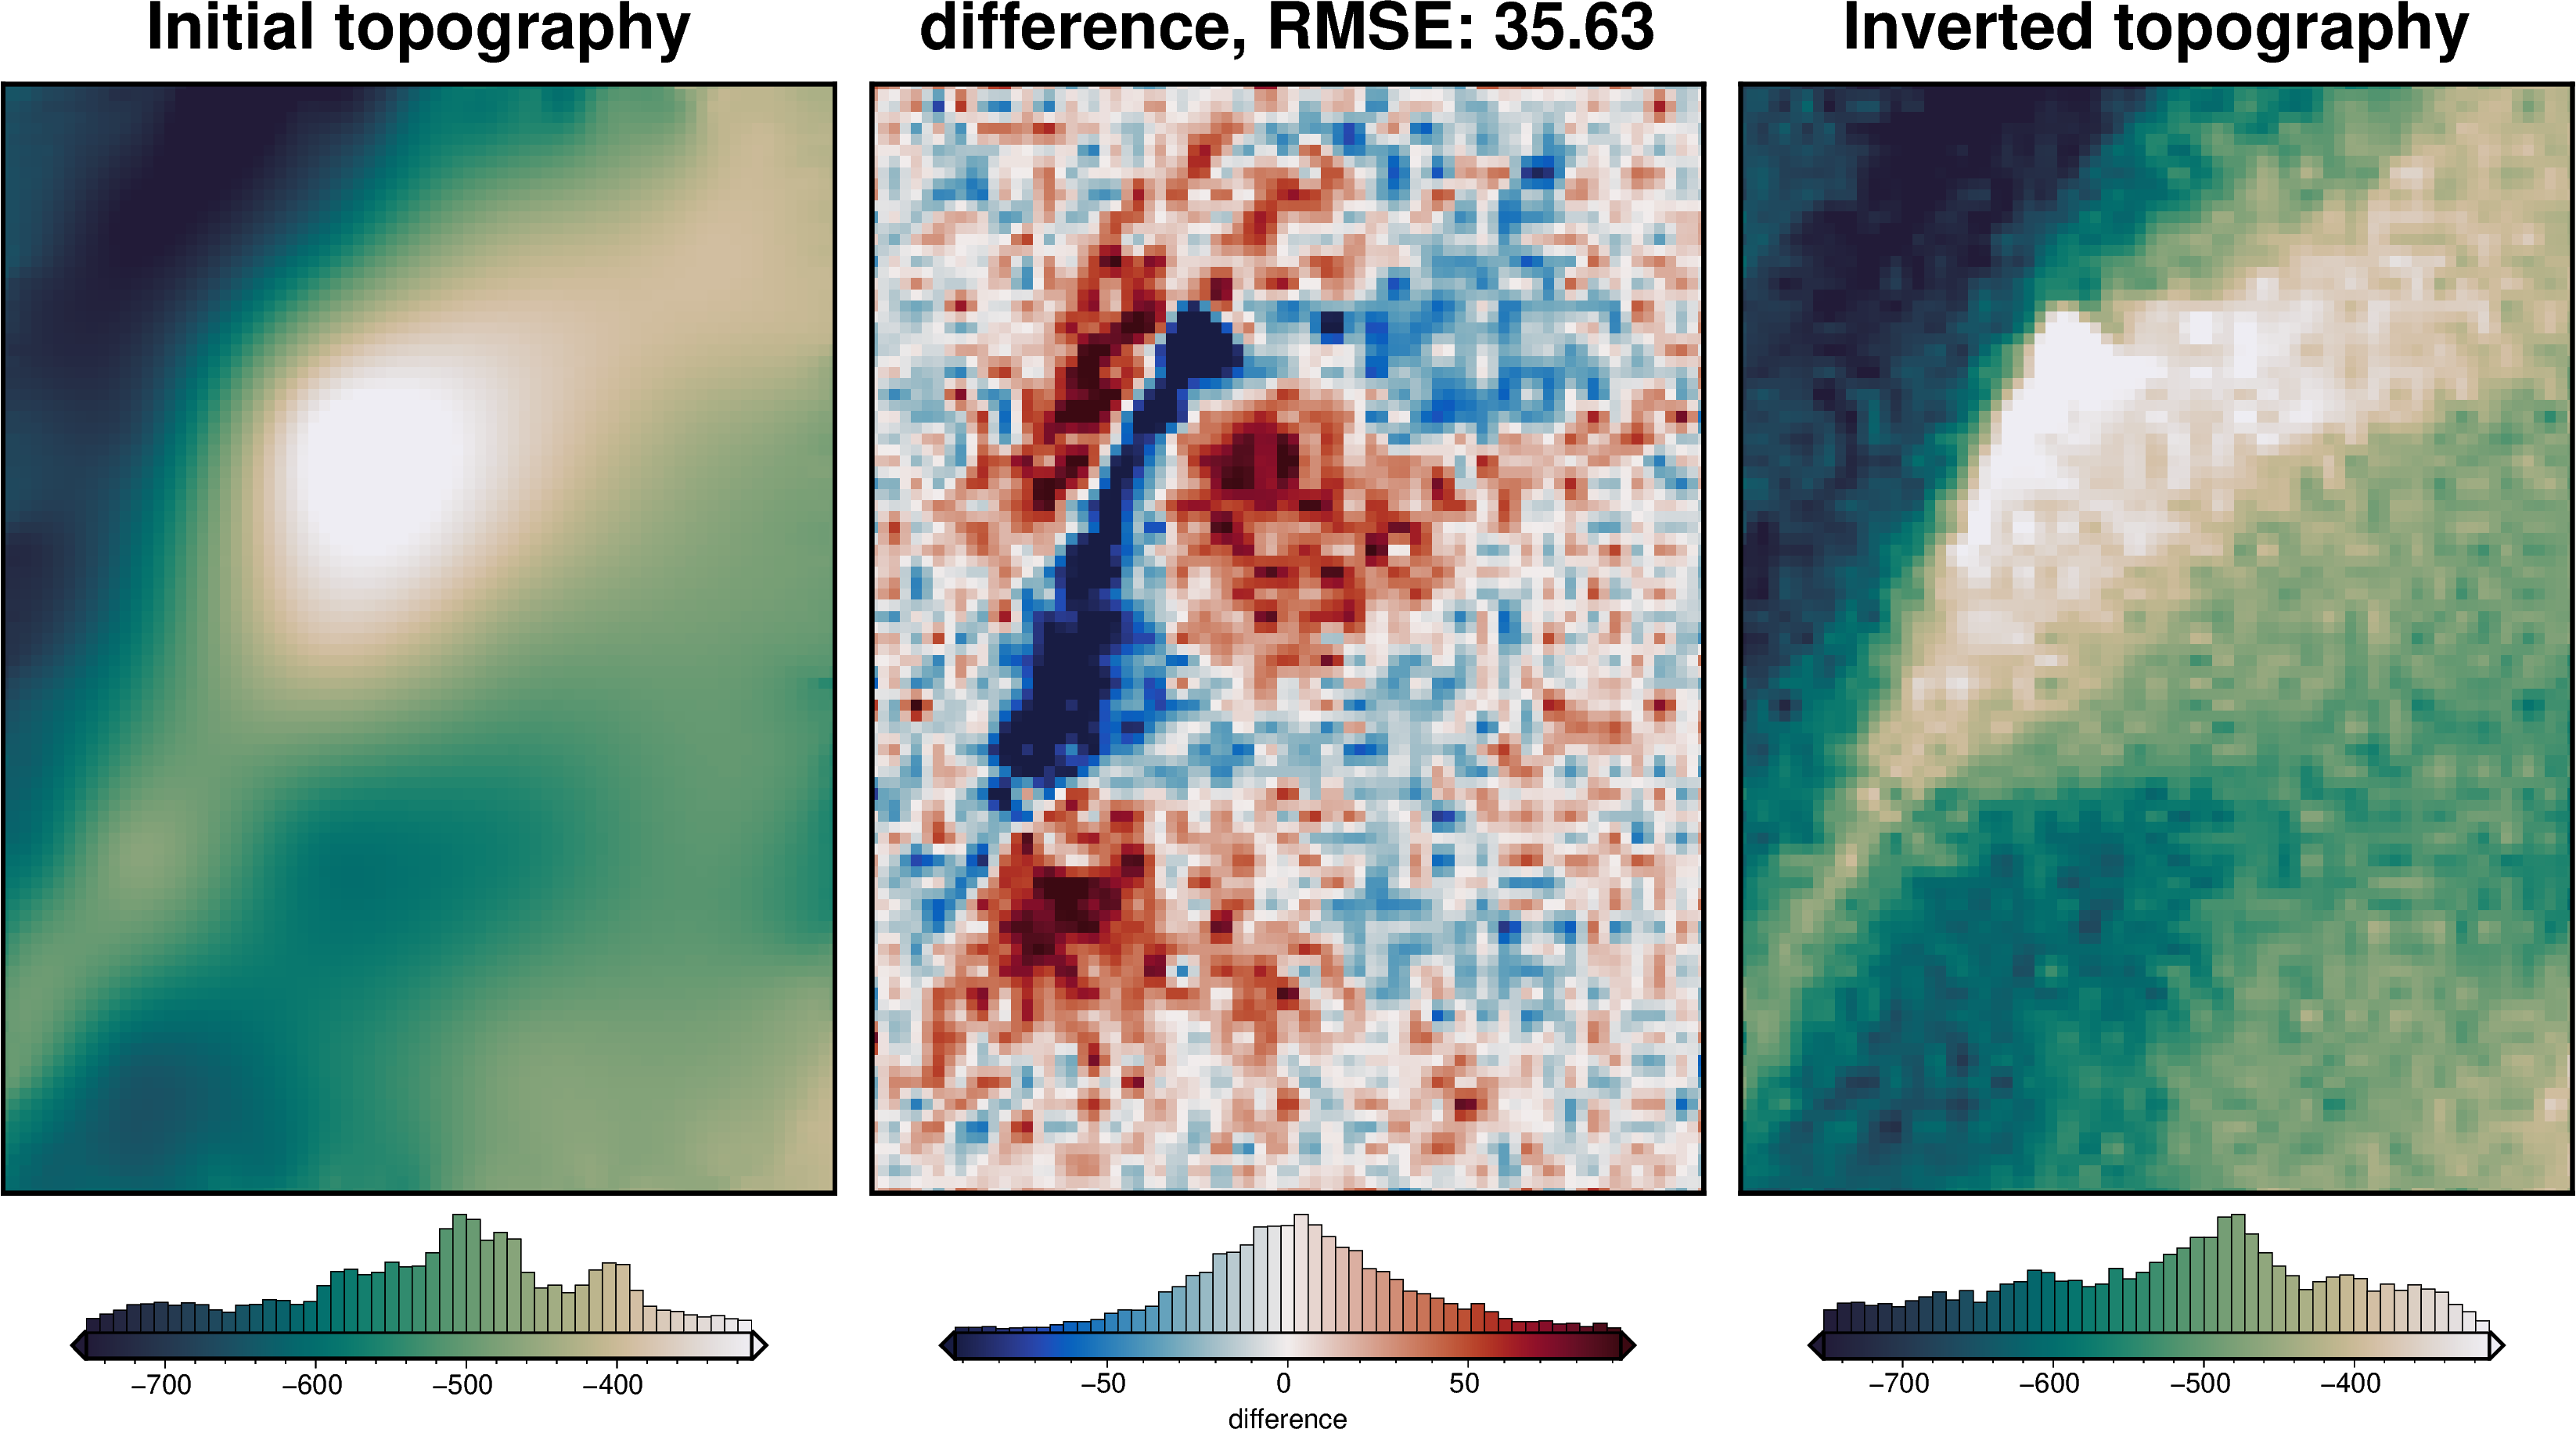

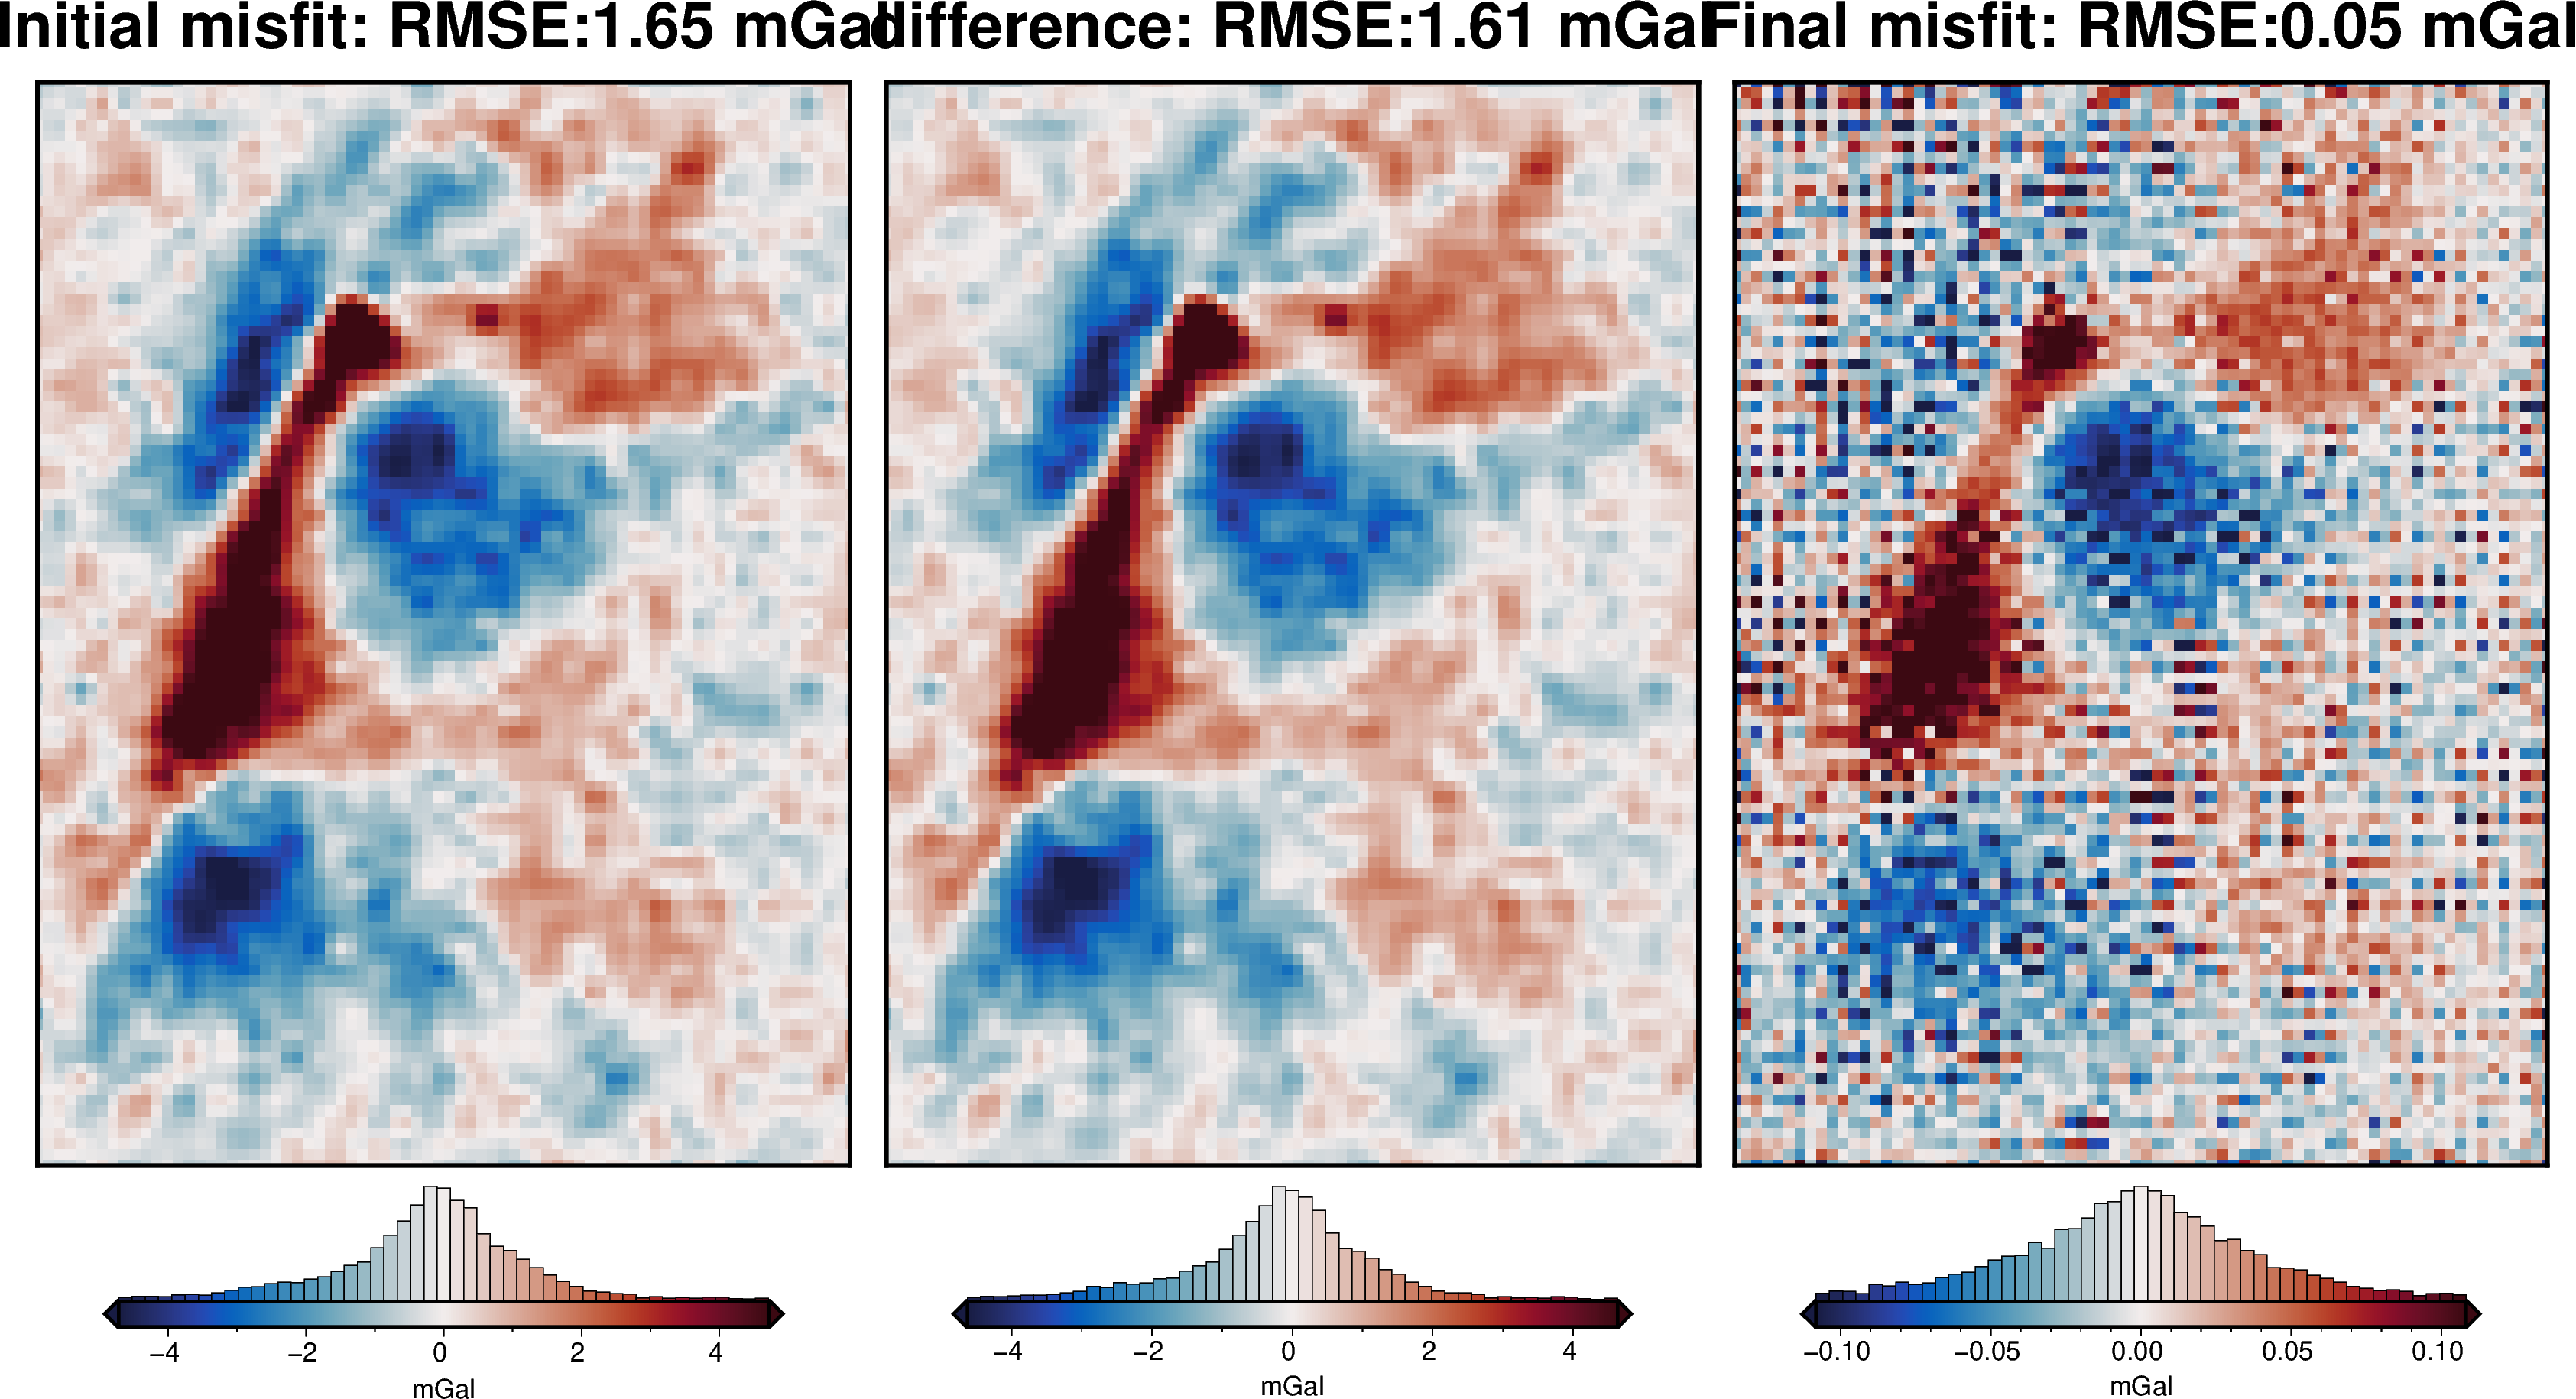

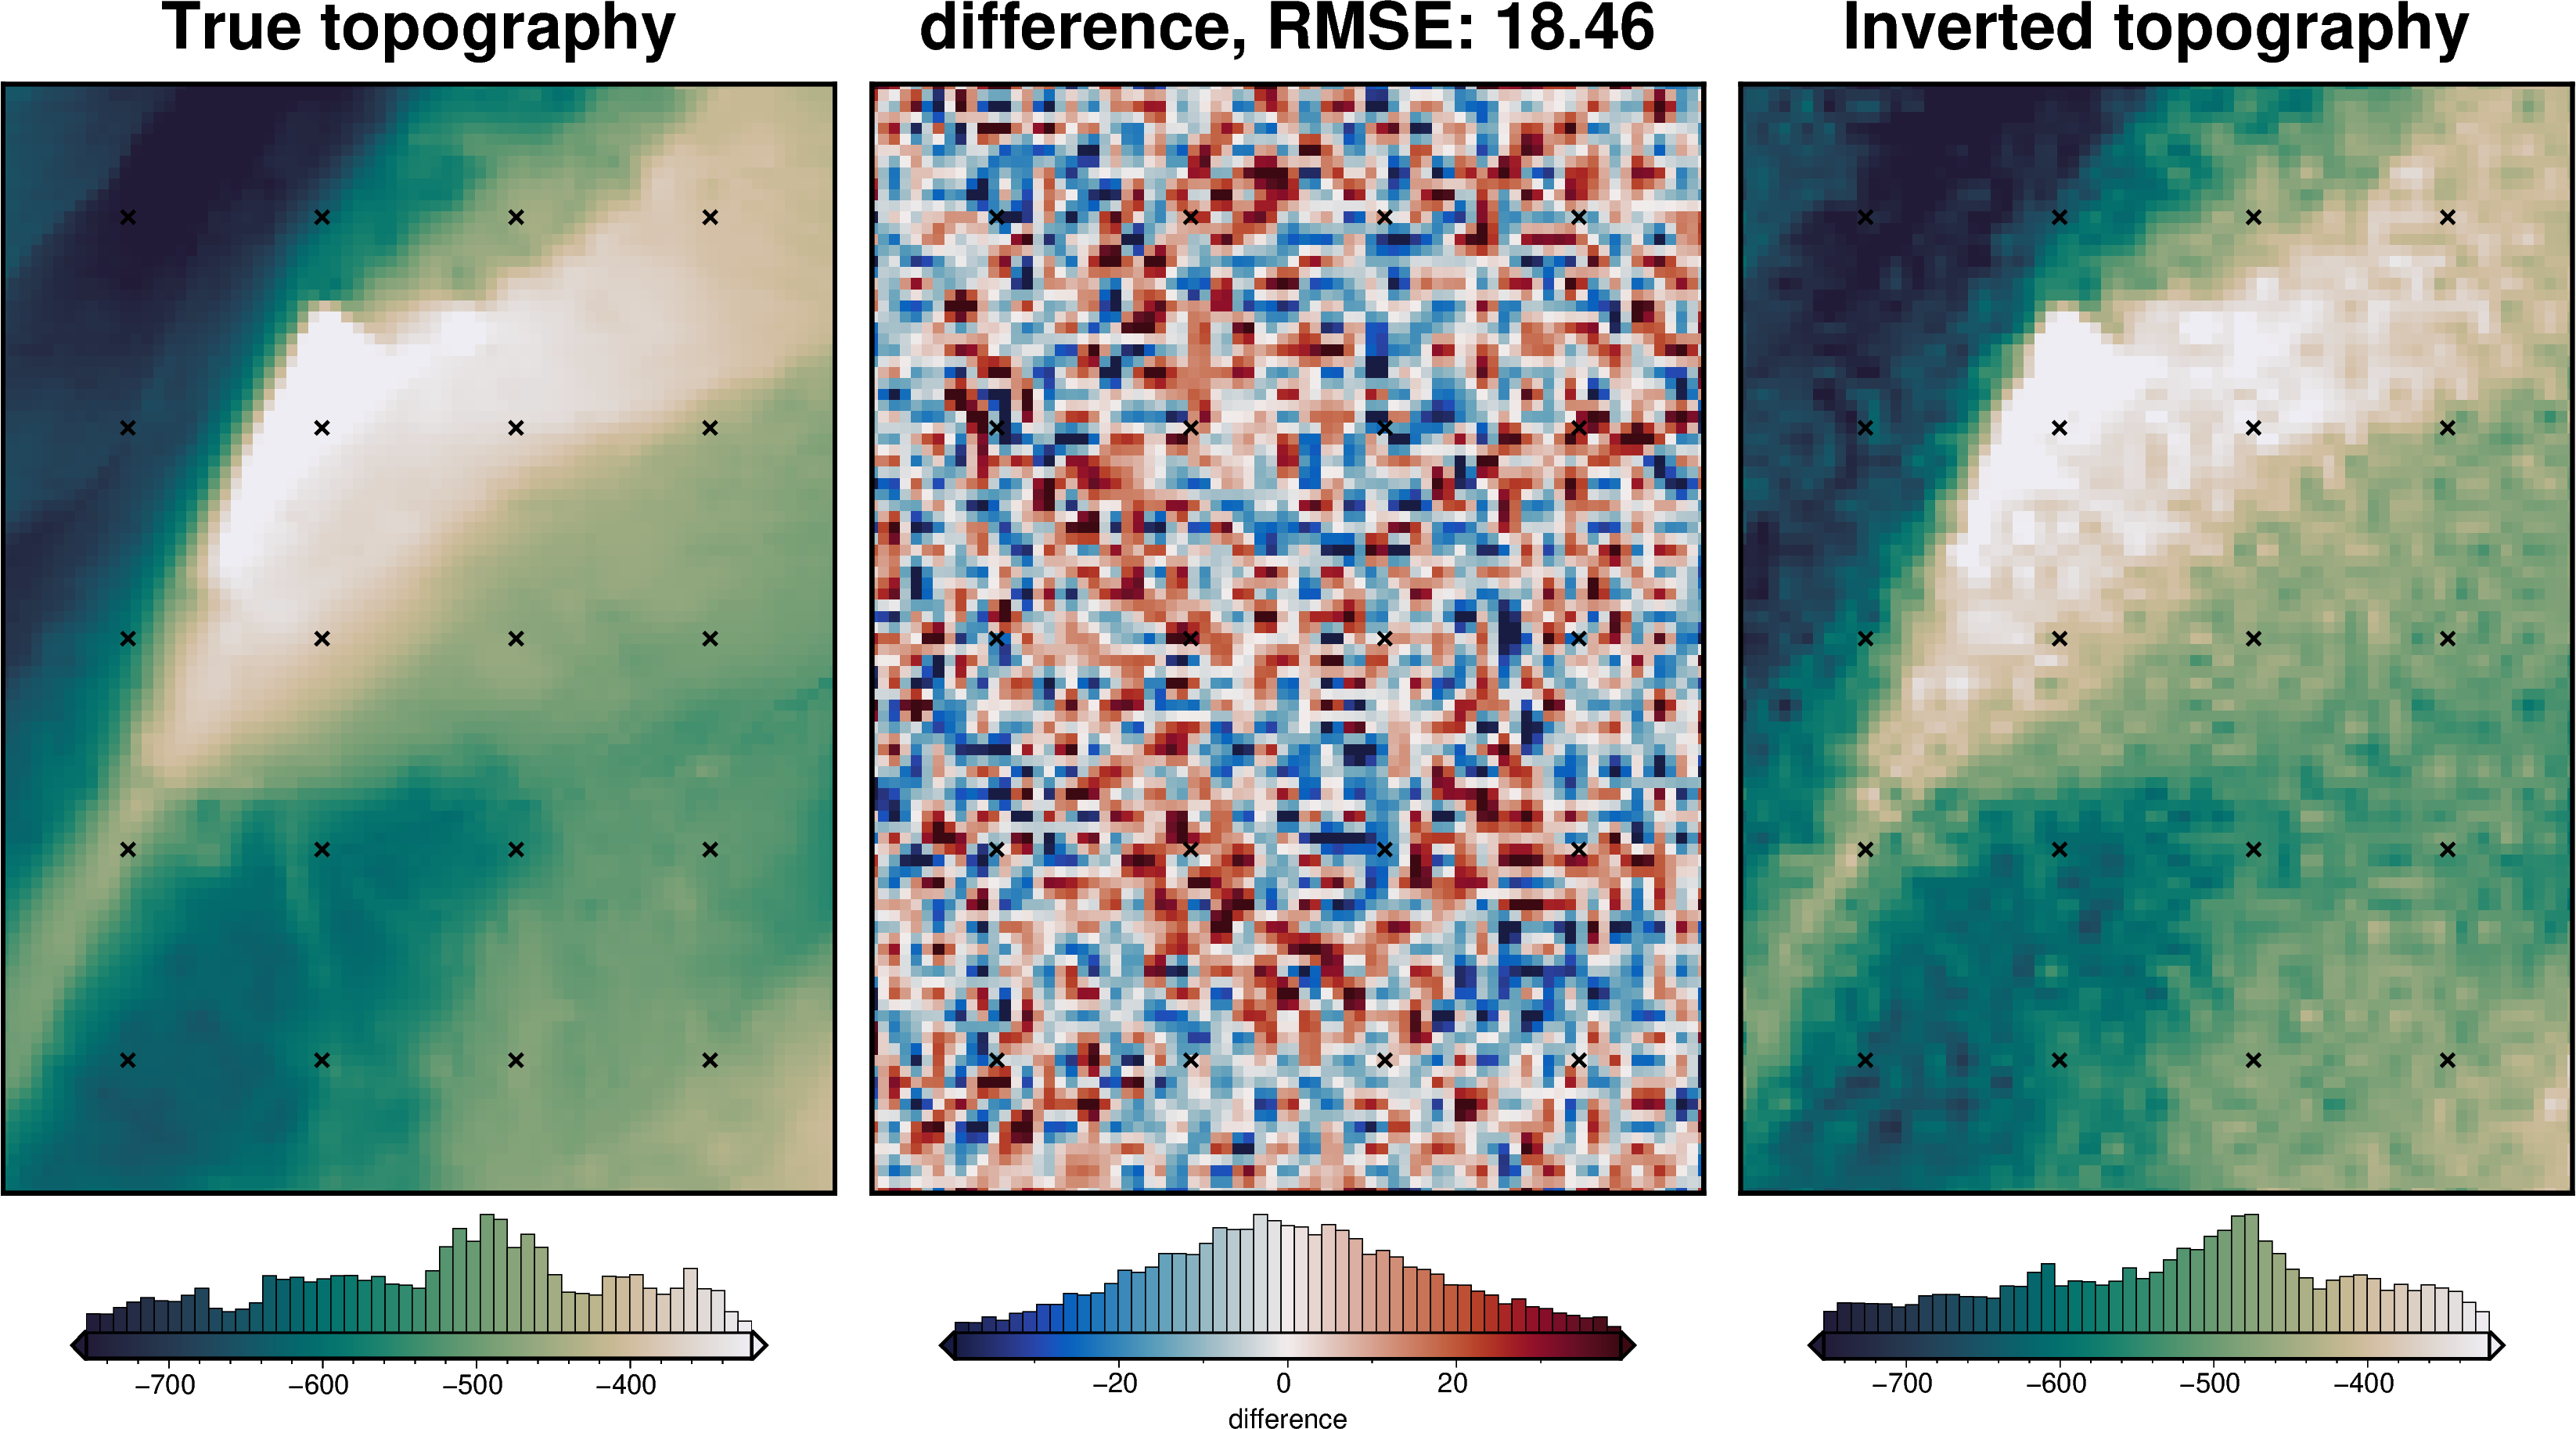

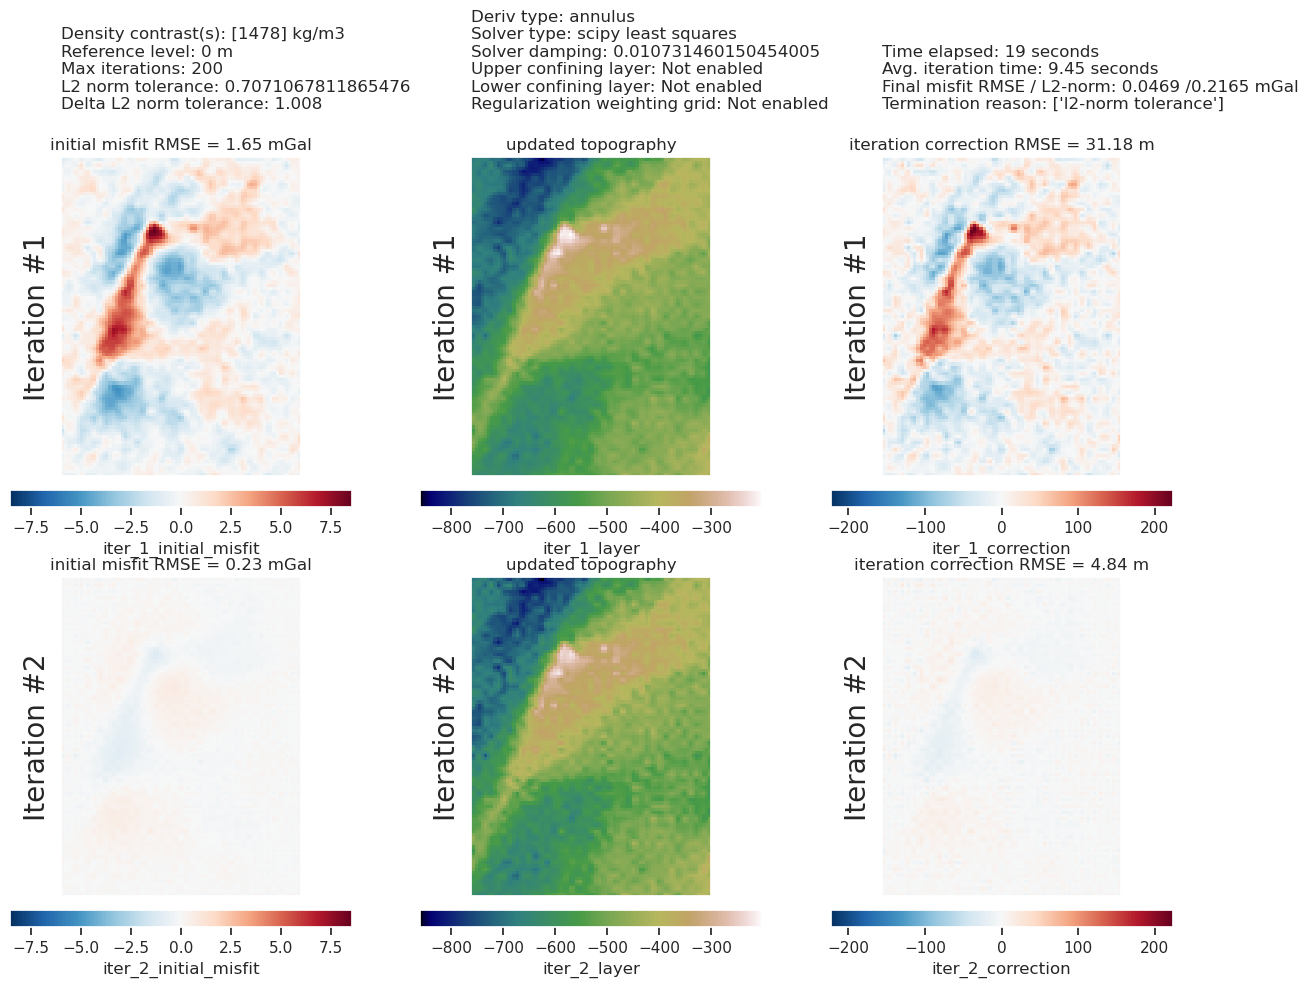

In [23]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    bathymetry,
    final_topography,
    region=inversion_region,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points[constraint_points.inside],
    points_style="x.2c",
)

In [24]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 18.56 m


In [25]:
# save to csv
constraint_points.to_csv("../../results/Ross_Sea_04_constraint_points.csv", index=False)

# Uncertainty analysis

## Inversion error

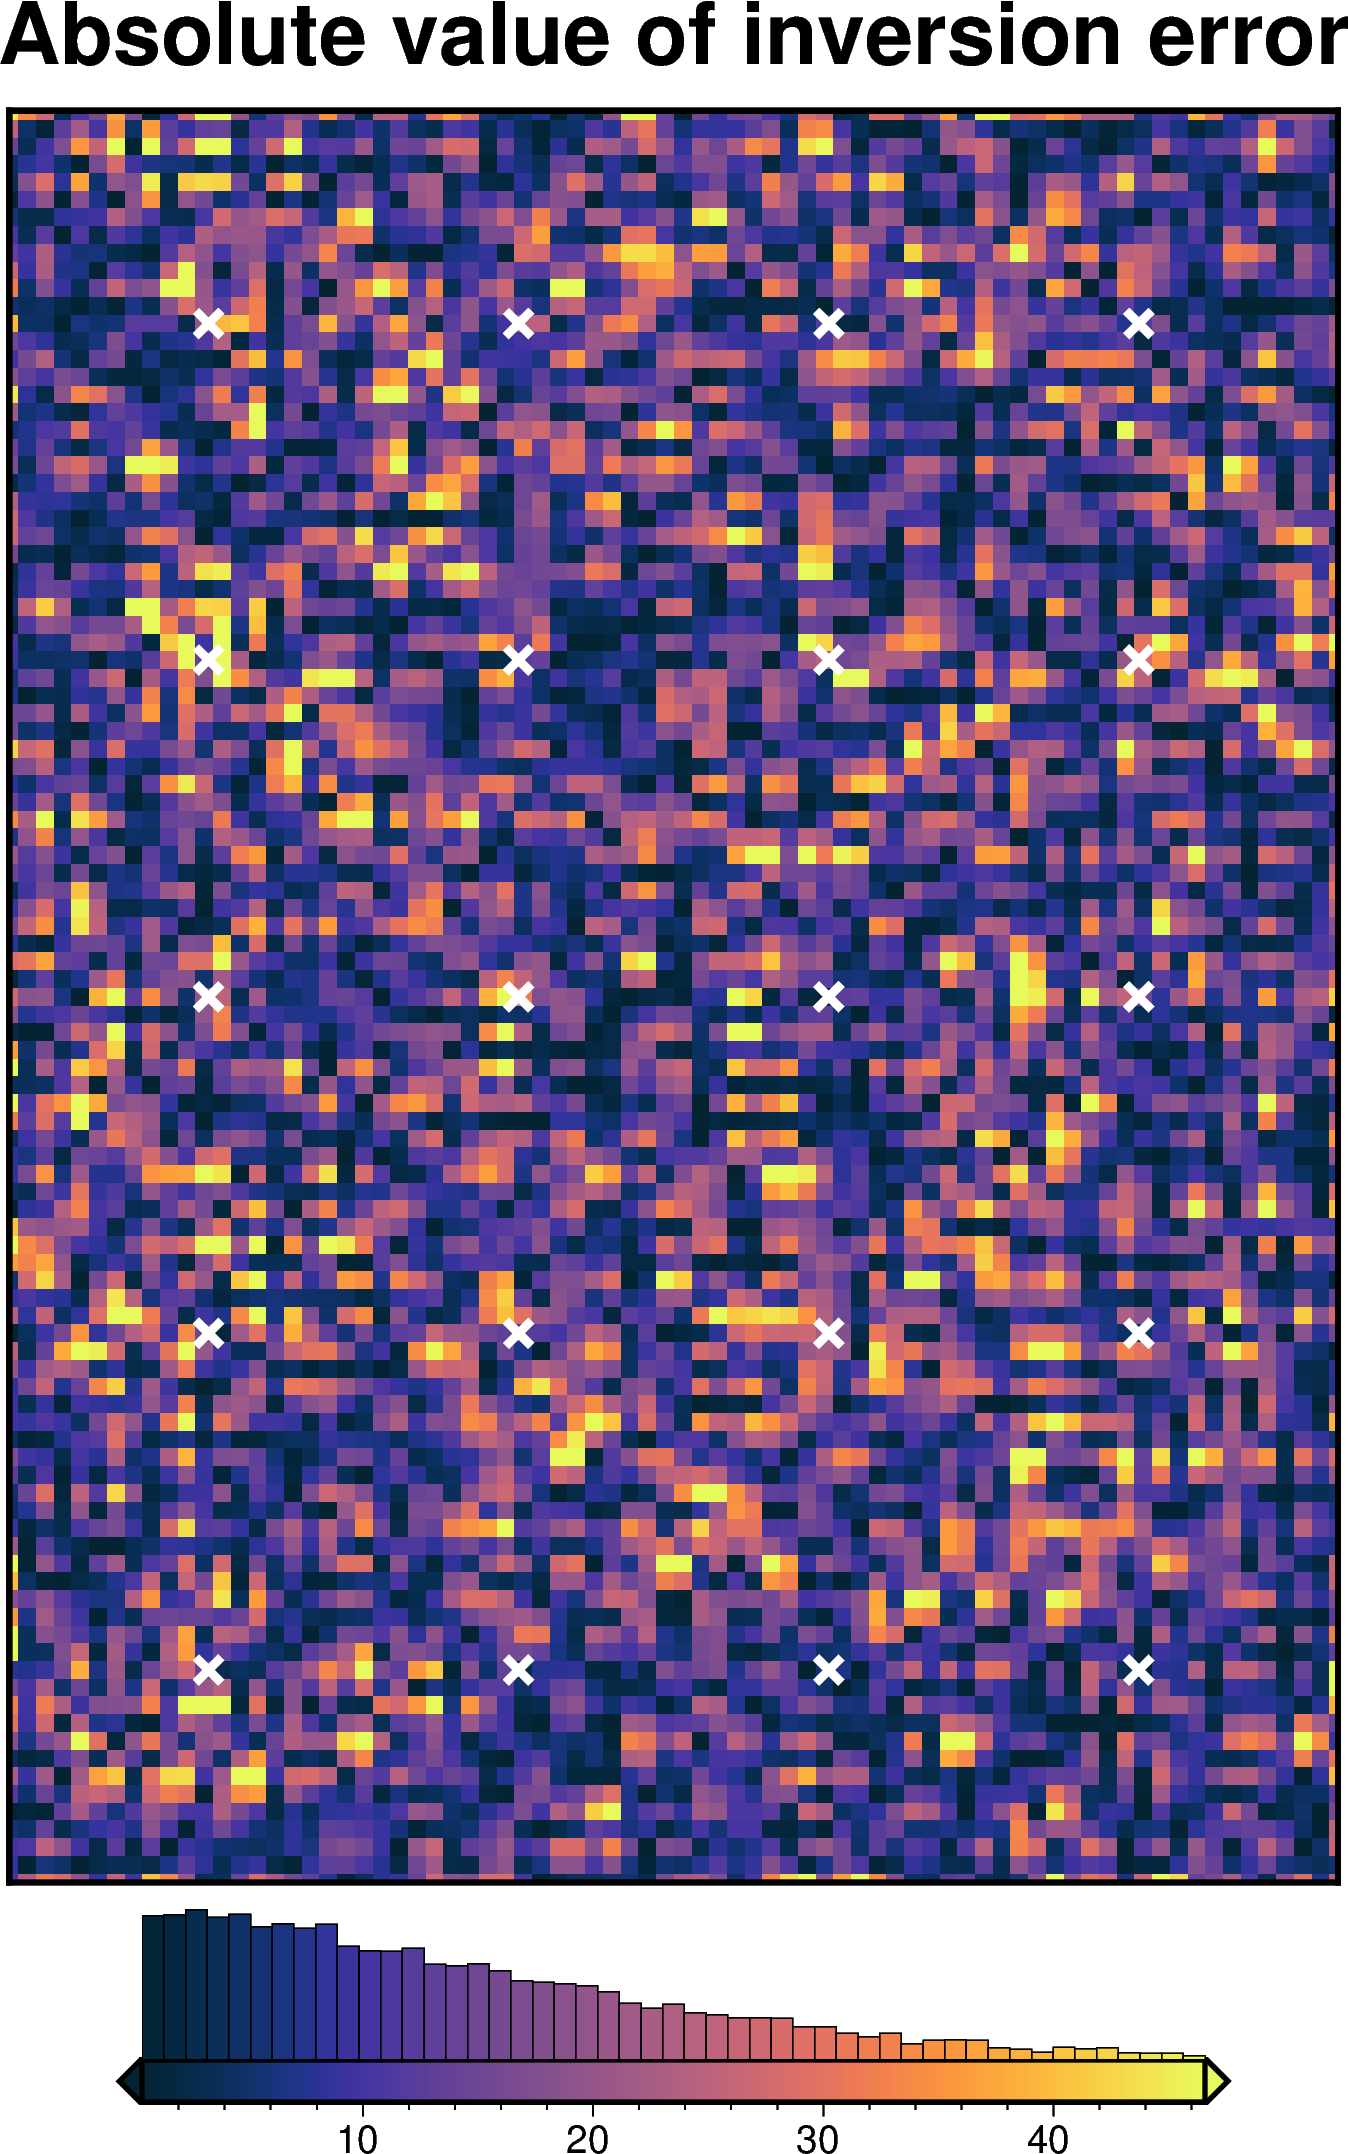

In [26]:
inversion_error = np.abs(bathymetry - final_topography)

fig = maps.plot_grd(
    inversion_error,
    region=inversion_region,
    # region=vd.pad_region(inversion_region, -3*spacing),
    hist=True,
    cmap="thermal",
    title="Absolute value of inversion error",
    robust=True,
    points=constraint_points[constraint_points.inside],
    points_style="x.3c",
    points_fill="white",
    points_pen="2p",
)
fig.show()

In [27]:
# kwargs to reuse for all uncertainty analyses
uncert_kwargs = dict(
    grav_df=grav_df,
    density_contrast=best_density_contrast,
    zref=zref,
    starting_prisms=starting_prisms,
    starting_topography=starting_bathymetry,
    regional_grav_kwargs=regional_grav_kwargs,
    **kwargs,
)

## Solver damping component

In [28]:
# load study
with pathlib.Path("../../results/Ross_Sea_04_damping_cv_damping_cv_study.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)

study_df = study.trials_dataframe().drop(columns=["user_attrs_results"])
study_df = study_df.sort_values("value")

# calculate zscores of values
study_df["value_zscore"] = sp.stats.zscore(study_df["value"])

# drop outliers (values with zscore > |2|)
study_df2 = study_df[(np.abs(study_df.value_zscore) < 2)]

# pick damping standard deviation based on optimization
stdev = np.log10(study_df2.params_damping).std()
print(f"calculated stdev: {stdev}")
stdev = stdev / 4
print(f"using stdev: {stdev}")

calculated stdev: 0.4602264440895244
using stdev: 0.1150566110223811


best: 0.010731460150454005 
std: 0.1150566110223811 
+1std: 0.01398670542431032 
-1std: 0.008233835879650054


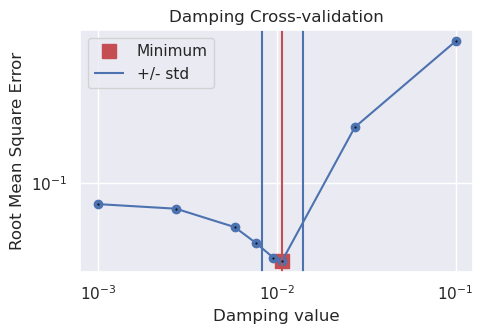

In [29]:
fig = plotting.plot_cv_scores(
    study_df.value,
    study_df.params_damping,
    param_name="Damping",
    logx=True,
    logy=True,
)
ax = fig.axes[0]

best = float(study_df2.params_damping.iloc[0])
upper = float(10 ** (np.log10(best) + stdev))
lower = float(10 ** (np.log10(best) - stdev))

y_lims = ax.get_ylim()
ax.vlines(best, ymin=y_lims[0], ymax=y_lims[1], color="r")
ax.vlines(upper, ymin=y_lims[0], ymax=y_lims[1], label="+/- std")
ax.vlines(lower, ymin=y_lims[0], ymax=y_lims[1])

x_lims = ax.get_xlim()
ax.set_xlim(
    min(x_lims[0], lower),
    max(x_lims[1], upper),
)
ax.legend()
print("best:", best, "\nstd:", stdev, "\n+1std:", upper, "\n-1std:", lower)

INFO:invert4geom:Sampled 'solver_damping' parameter values; mean: 0.01106664632424577, min: 0.006940768083608715, max: 0.016592434089932148
INFO:invert4geom:No pickle files starting with '../../results/Ross_Sea_04_uncertainty_damping' found, creating new files



stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 10
saving results to pickle files with prefix: '../../results/Ross_Sea_04_uncertainty_damping'



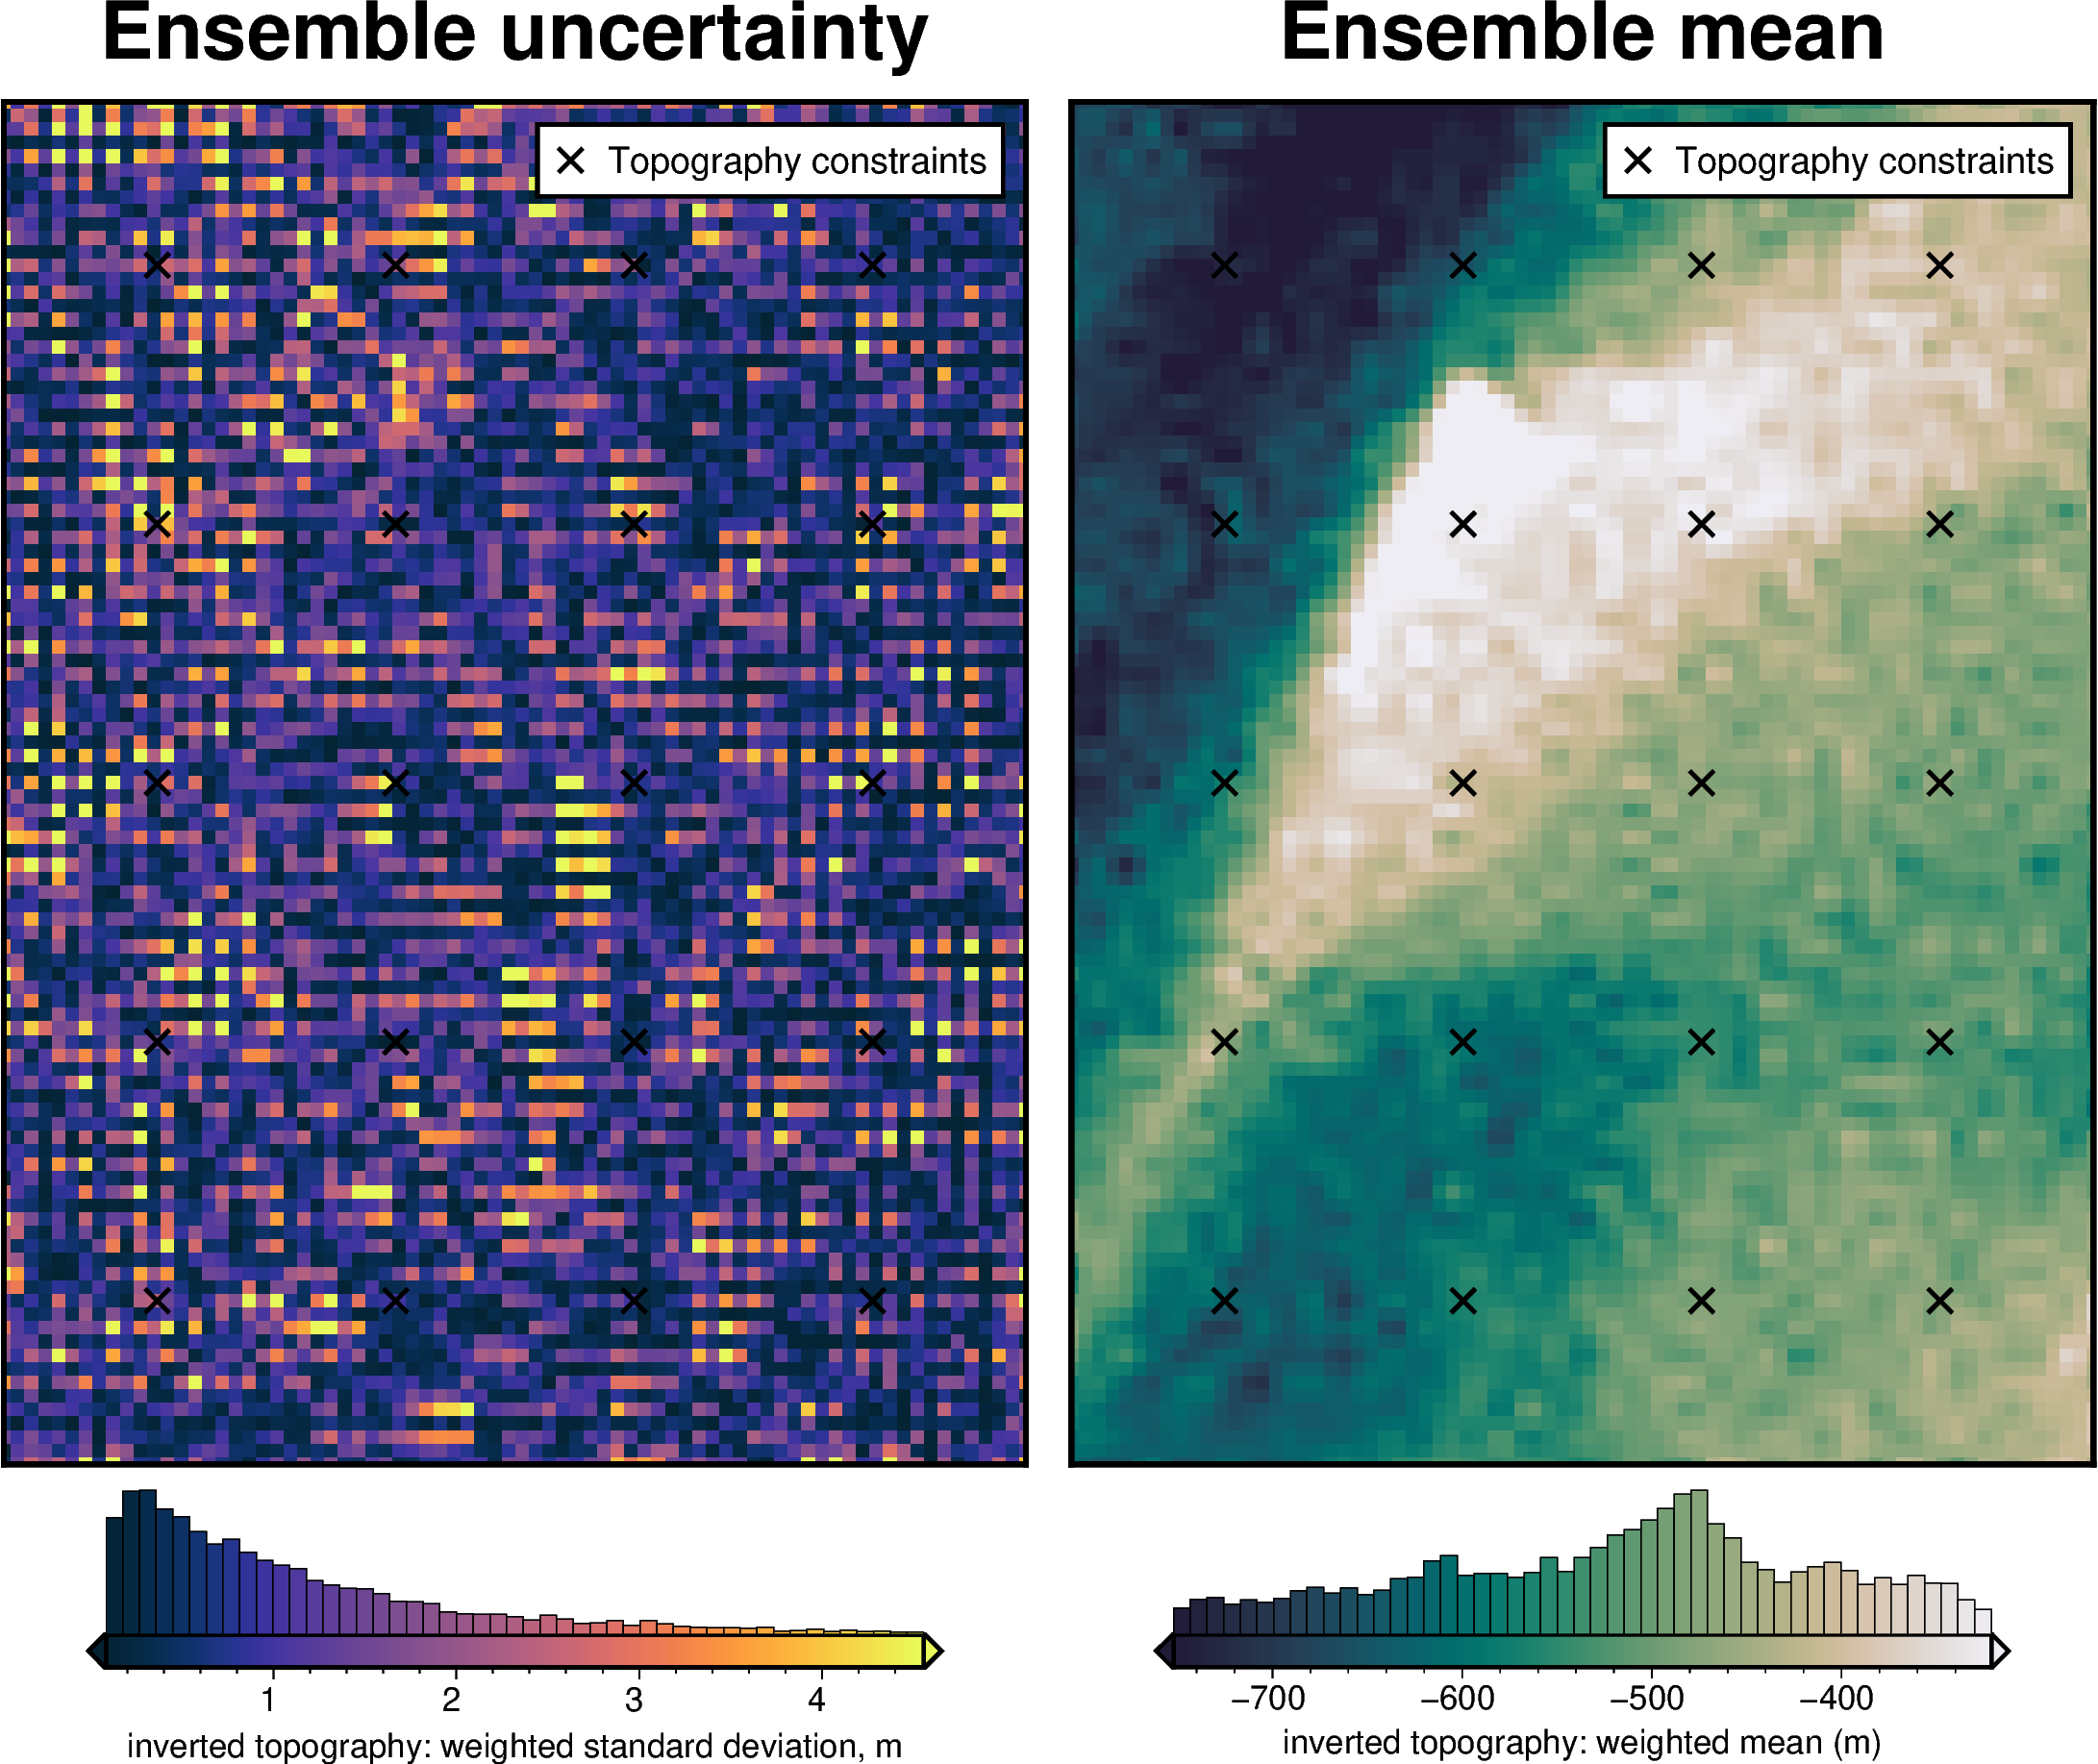

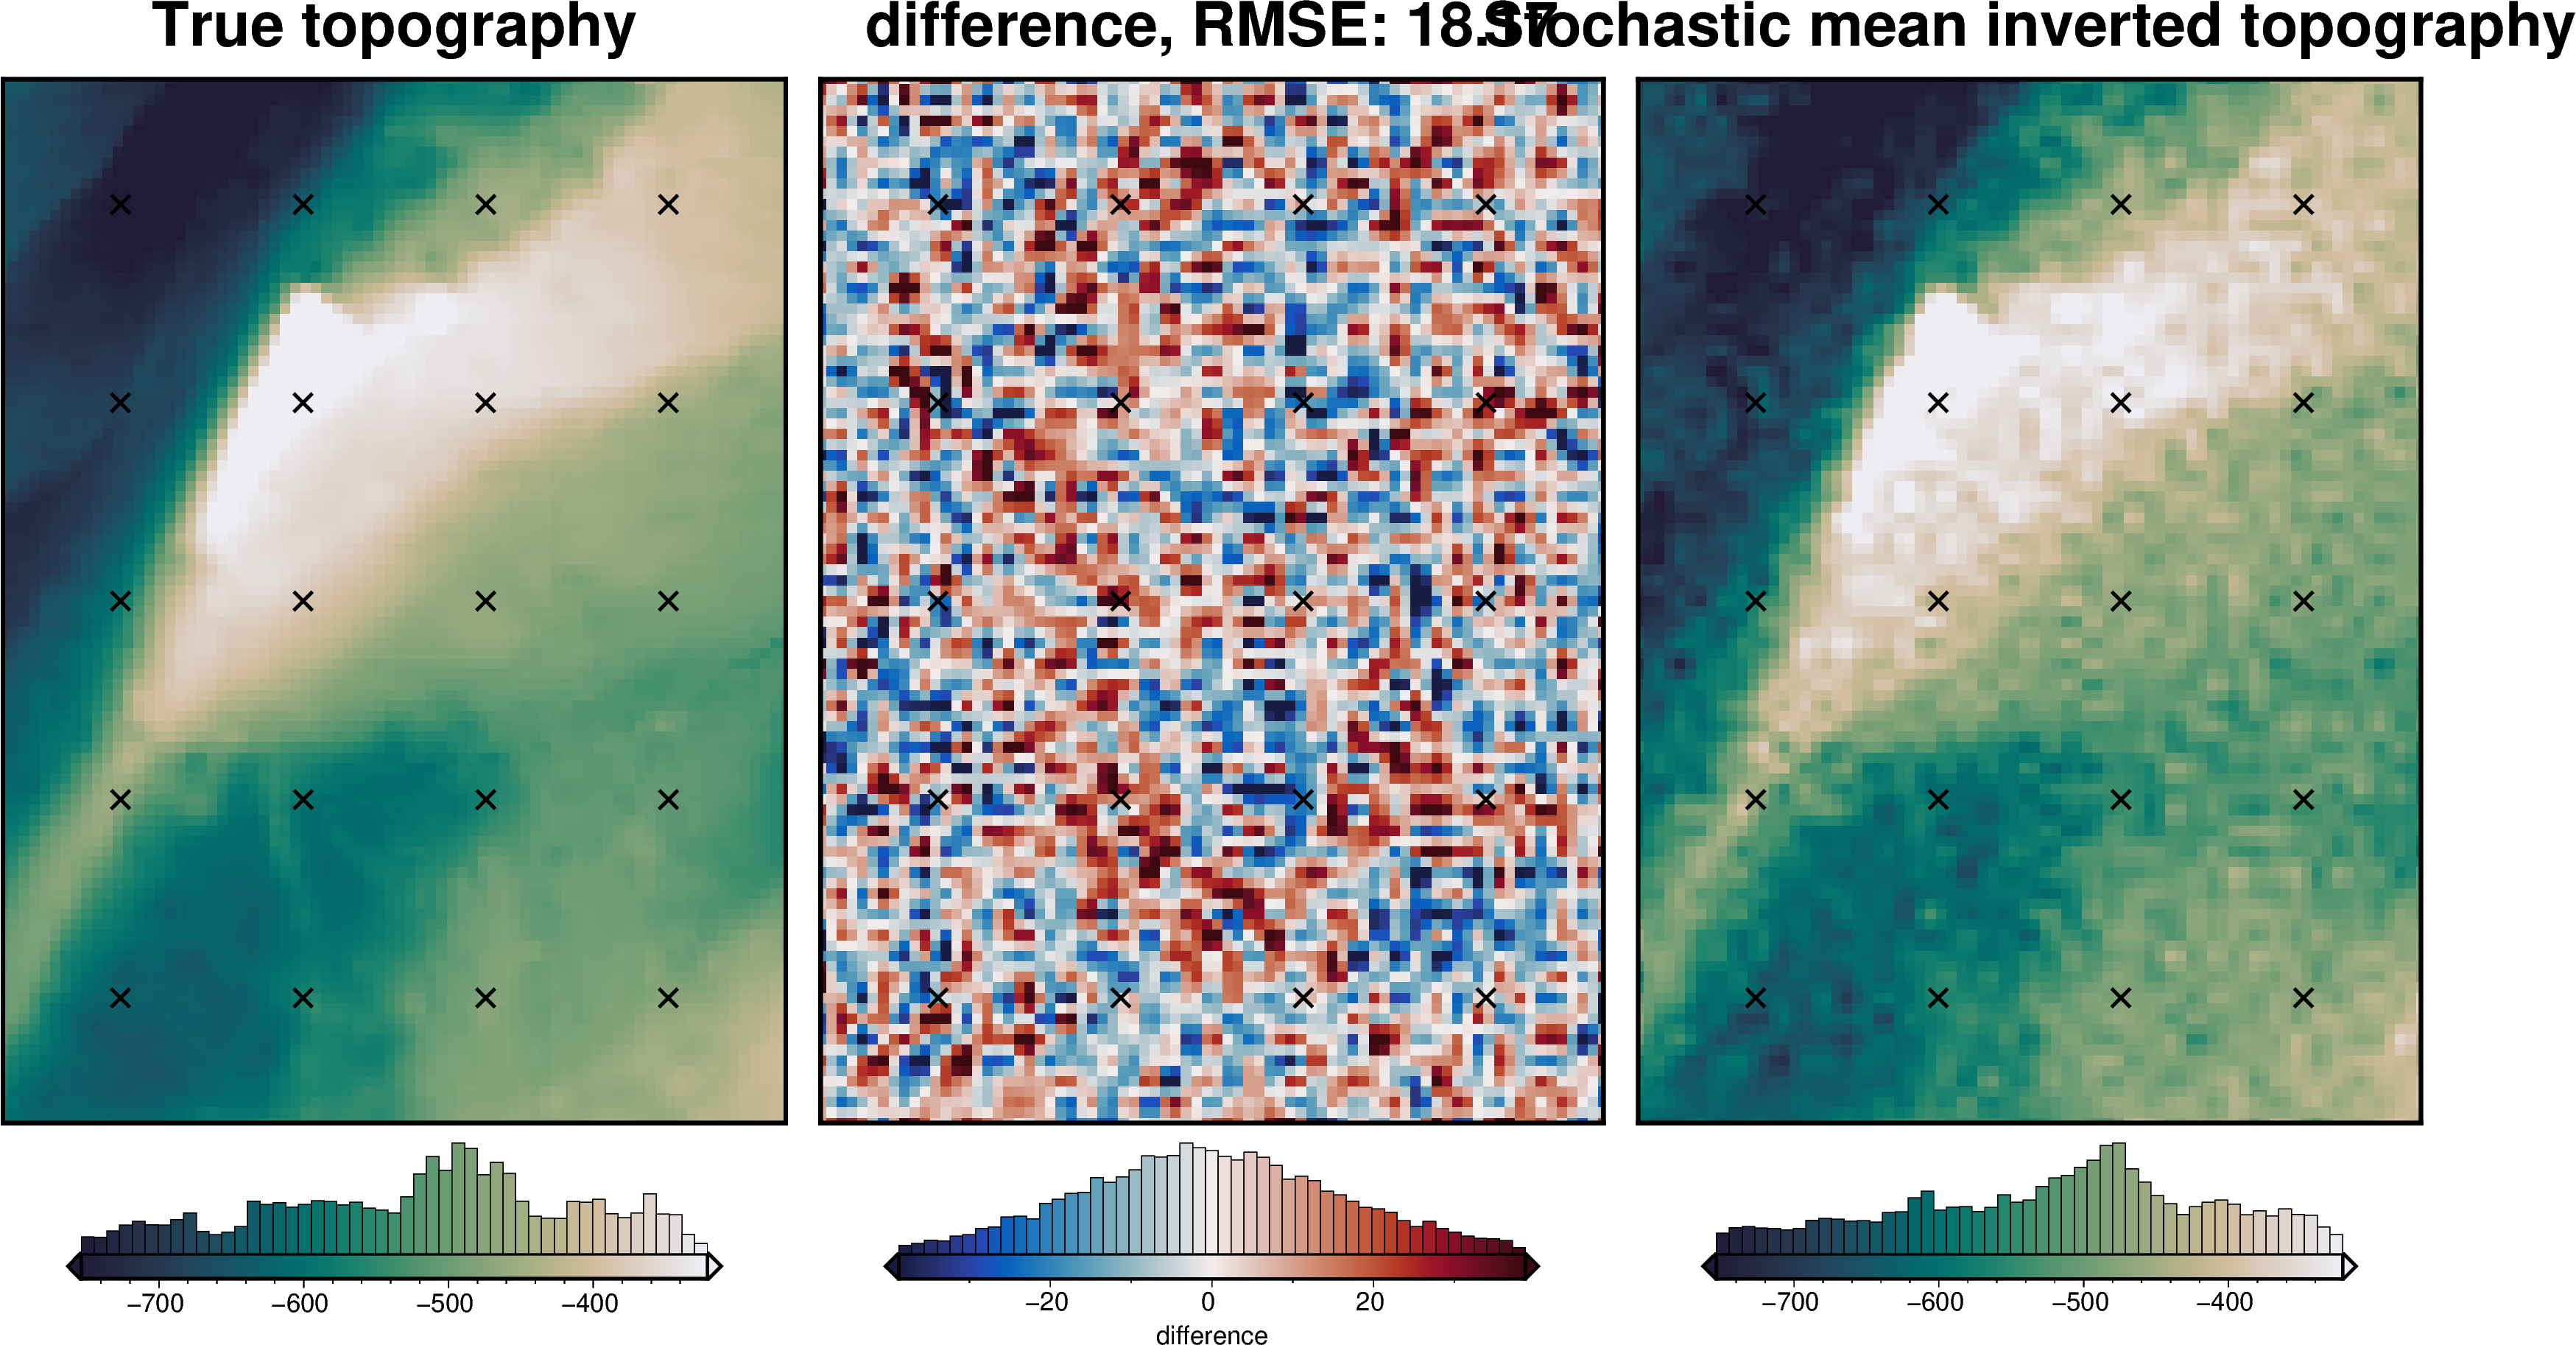

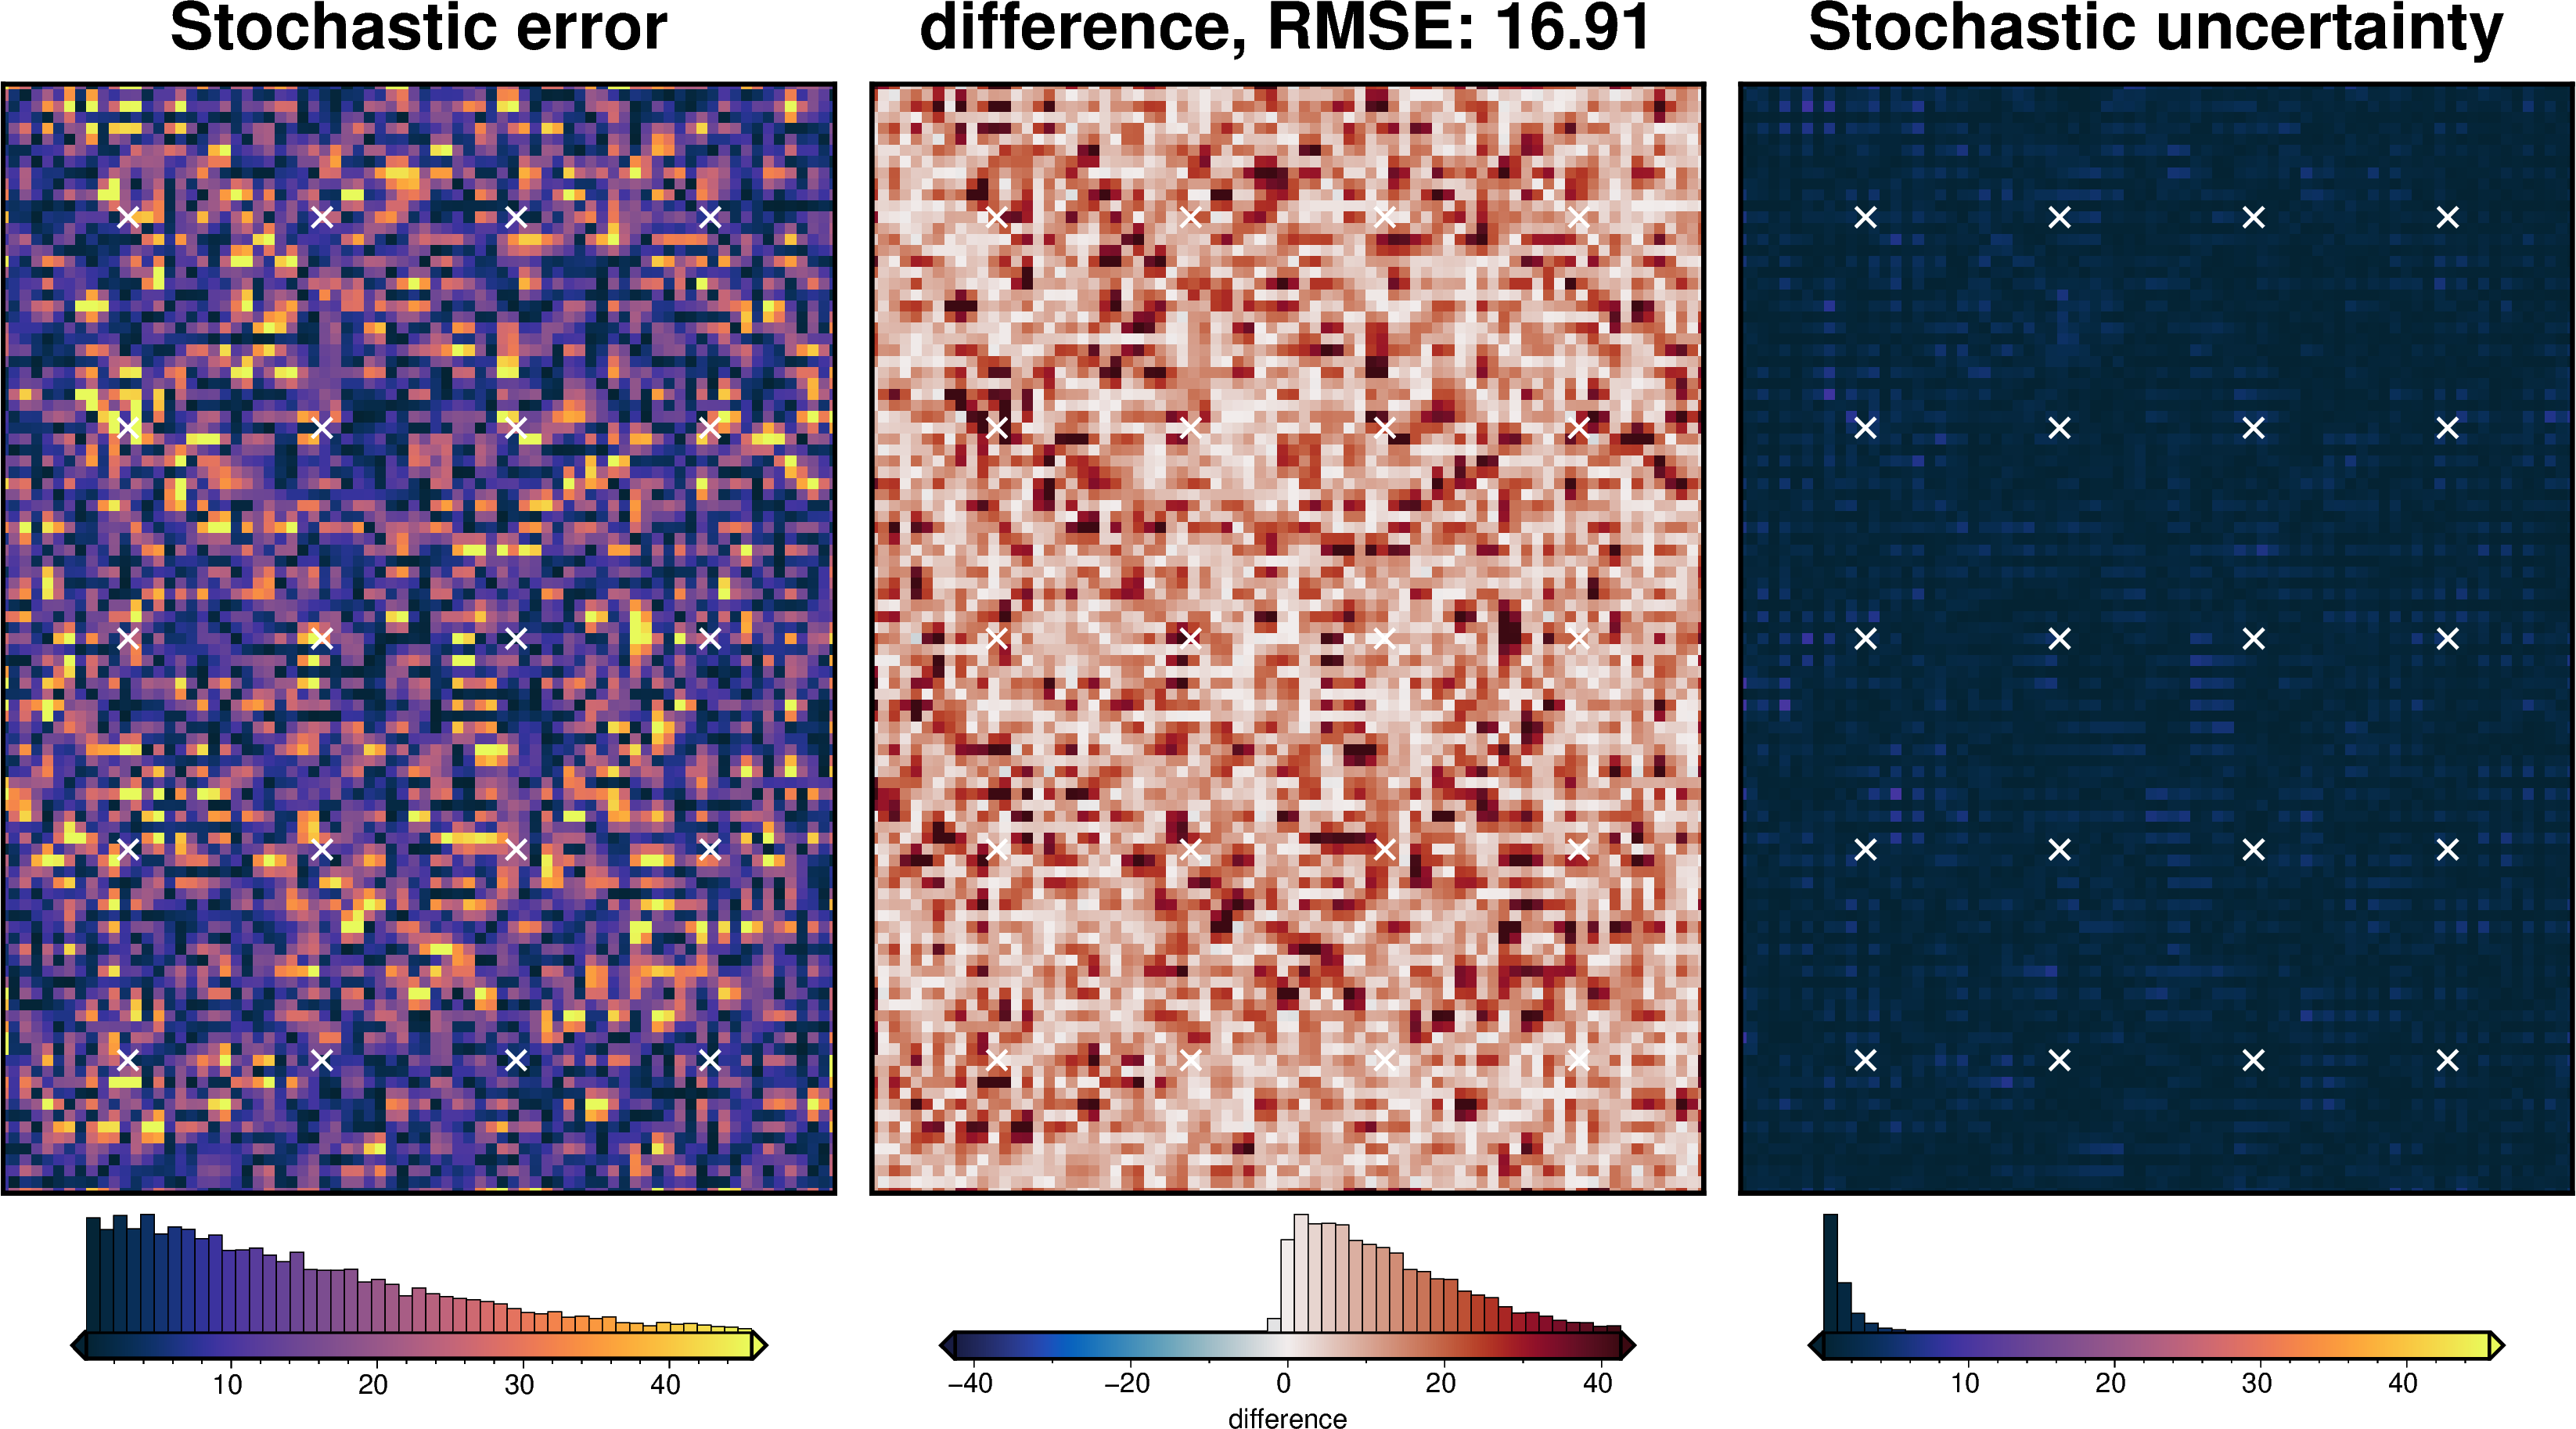

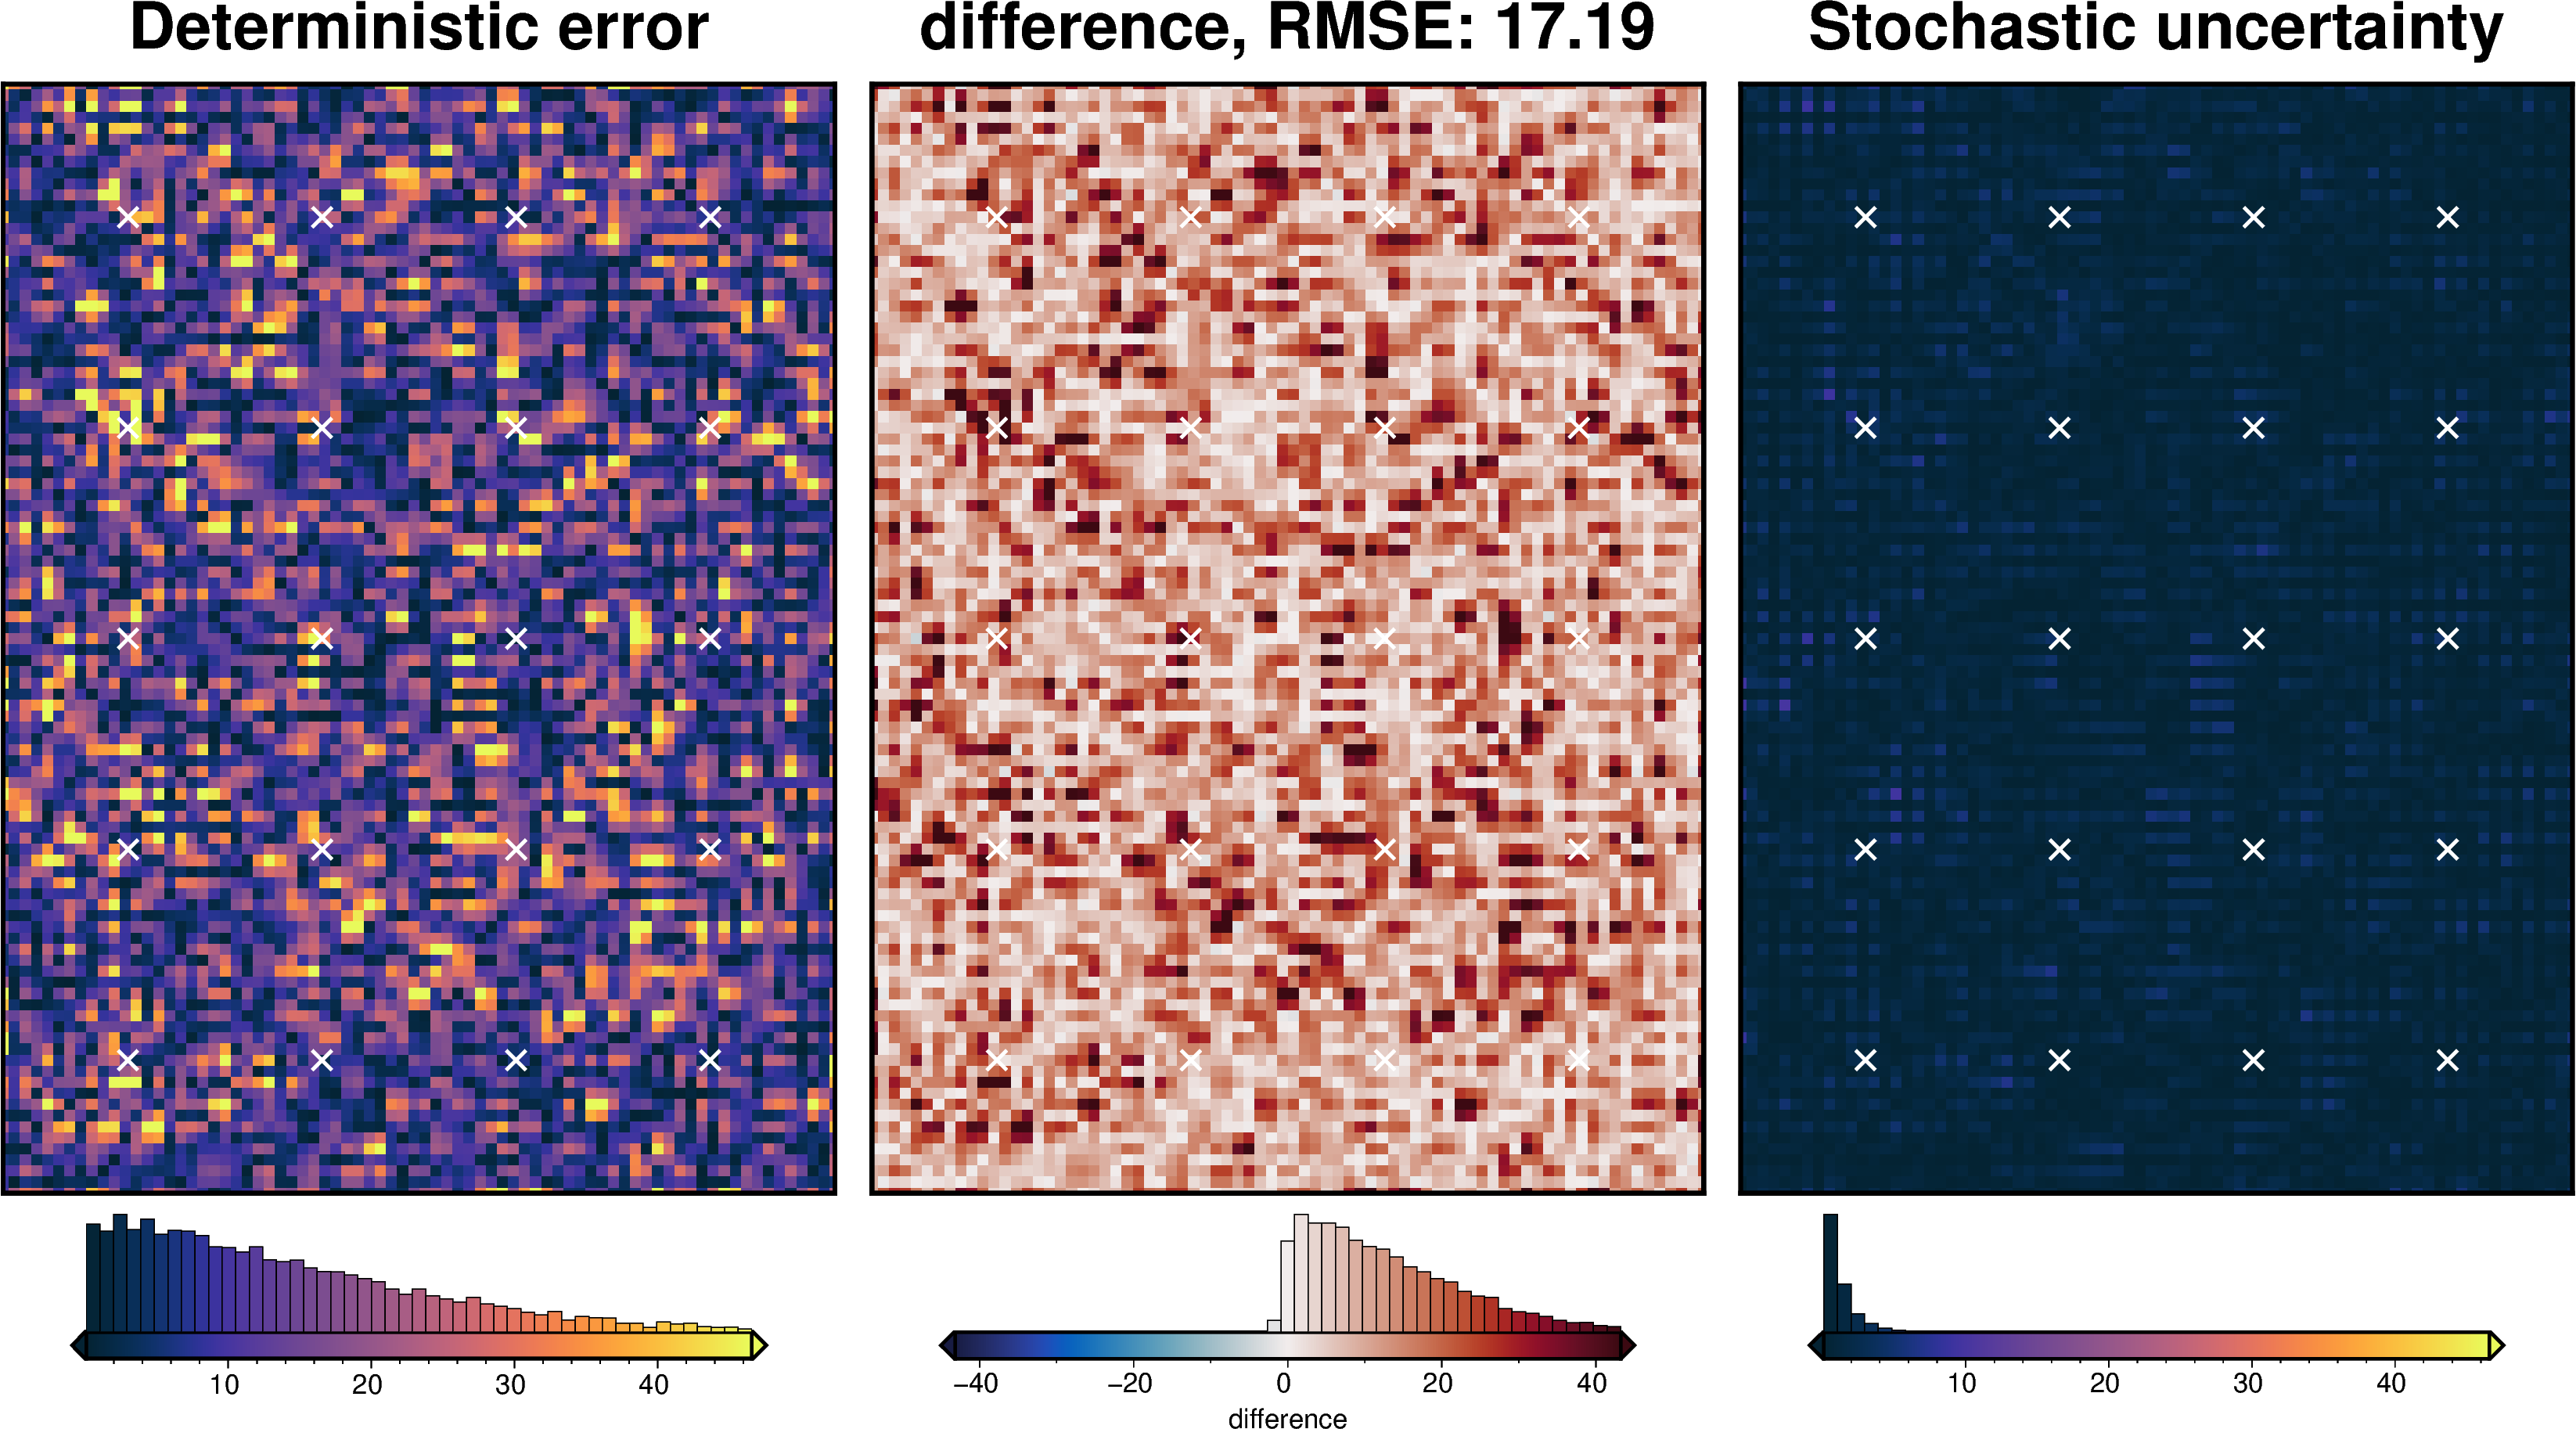

In [30]:
solver_dict = {
    "solver_damping": {
        "distribution": "normal",
        "loc": np.log10(best_damping),  # mean of base 10 exponent
        "scale": stdev,  # standard deviation of base 10 exponent
        "log": True,
    },
}
fname = "../../results/Ross_Sea_04_uncertainty_damping"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_damping_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    parameter_dict=solver_dict,
    **uncert_kwargs,
)

stats_ds = RIS_plotting.uncert_plots(
    uncert_damping_results,
    # vd.pad_region(inversion_region, -3*spacing),
    inversion_region,
    spacing,
    bathymetry,
    deterministic_bathymetry=final_topography,
    constraint_points=constraint_points[constraint_points.inside],
    weight_by="constraints",
    # weight_by="residual",
    # weight_by=None,
)

## Density component

In [29]:
# load study
with pathlib.Path(
    "../../results/Ross_Sea_04_density_cv_zref_density_cv_study.pickle"
).open("rb") as f:
    study = pickle.load(f)

study_df = study.trials_dataframe()
study_df = study_df.sort_values("value")

# calculate zscores of values
study_df["value_zscore"] = sp.stats.zscore(study_df["value"])

# drop outliers (values with zscore > |2|)
study_df2 = study_df[(np.abs(study_df.value_zscore) < 2)]

stdev = study_df2.params_density_contrast.std()
print(f"calculated stdev: {stdev}")

# manually pick a stdev
stdev = 20
print(f"using stdev: {stdev}")

print(
    f"density estimation error: {np.abs(true_density_contrast - best_density_contrast)}"
)

calculated stdev: 43.176961449365564
using stdev: 20
density estimation error: 2


best: 1478 
std: 20 
+1std: 1498 
-1std: 1458


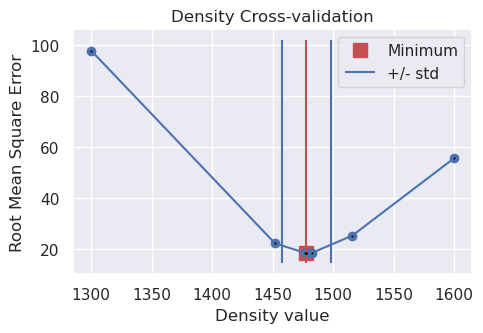

In [37]:
fig = plotting.plot_cv_scores(
    study.trials_dataframe().value.values,
    study.trials_dataframe().params_density_contrast.values,
    param_name="Density",
    logx=False,
    logy=False,
)
ax = fig.axes[0]

best = study_df2.params_density_contrast.iloc[0]
upper = best + stdev
lower = best - stdev

y_lims = ax.get_ylim()
ax.vlines(best, ymin=y_lims[0], ymax=y_lims[1], color="r")
ax.vlines(upper, ymin=y_lims[0], ymax=y_lims[1], label="+/- std")
ax.vlines(lower, ymin=y_lims[0], ymax=y_lims[1])

x_lims = ax.get_xlim()
ax.set_xlim(
    min(x_lims[0], lower),
    max(x_lims[1], upper),
)
ax.legend()
print("best:", best, "\nstd:", stdev, "\n+1std:", upper, "\n-1std:", lower)

INFO:invert4geom:Sampled 'density_contrast' parameter values; mean: 1478.0, min: 1477.810748716055, max: 1478.189251283945
INFO:invert4geom:all 10 runs already complete, loading results from files.


stochastic ensemble: 0it [00:00, ?it/s]

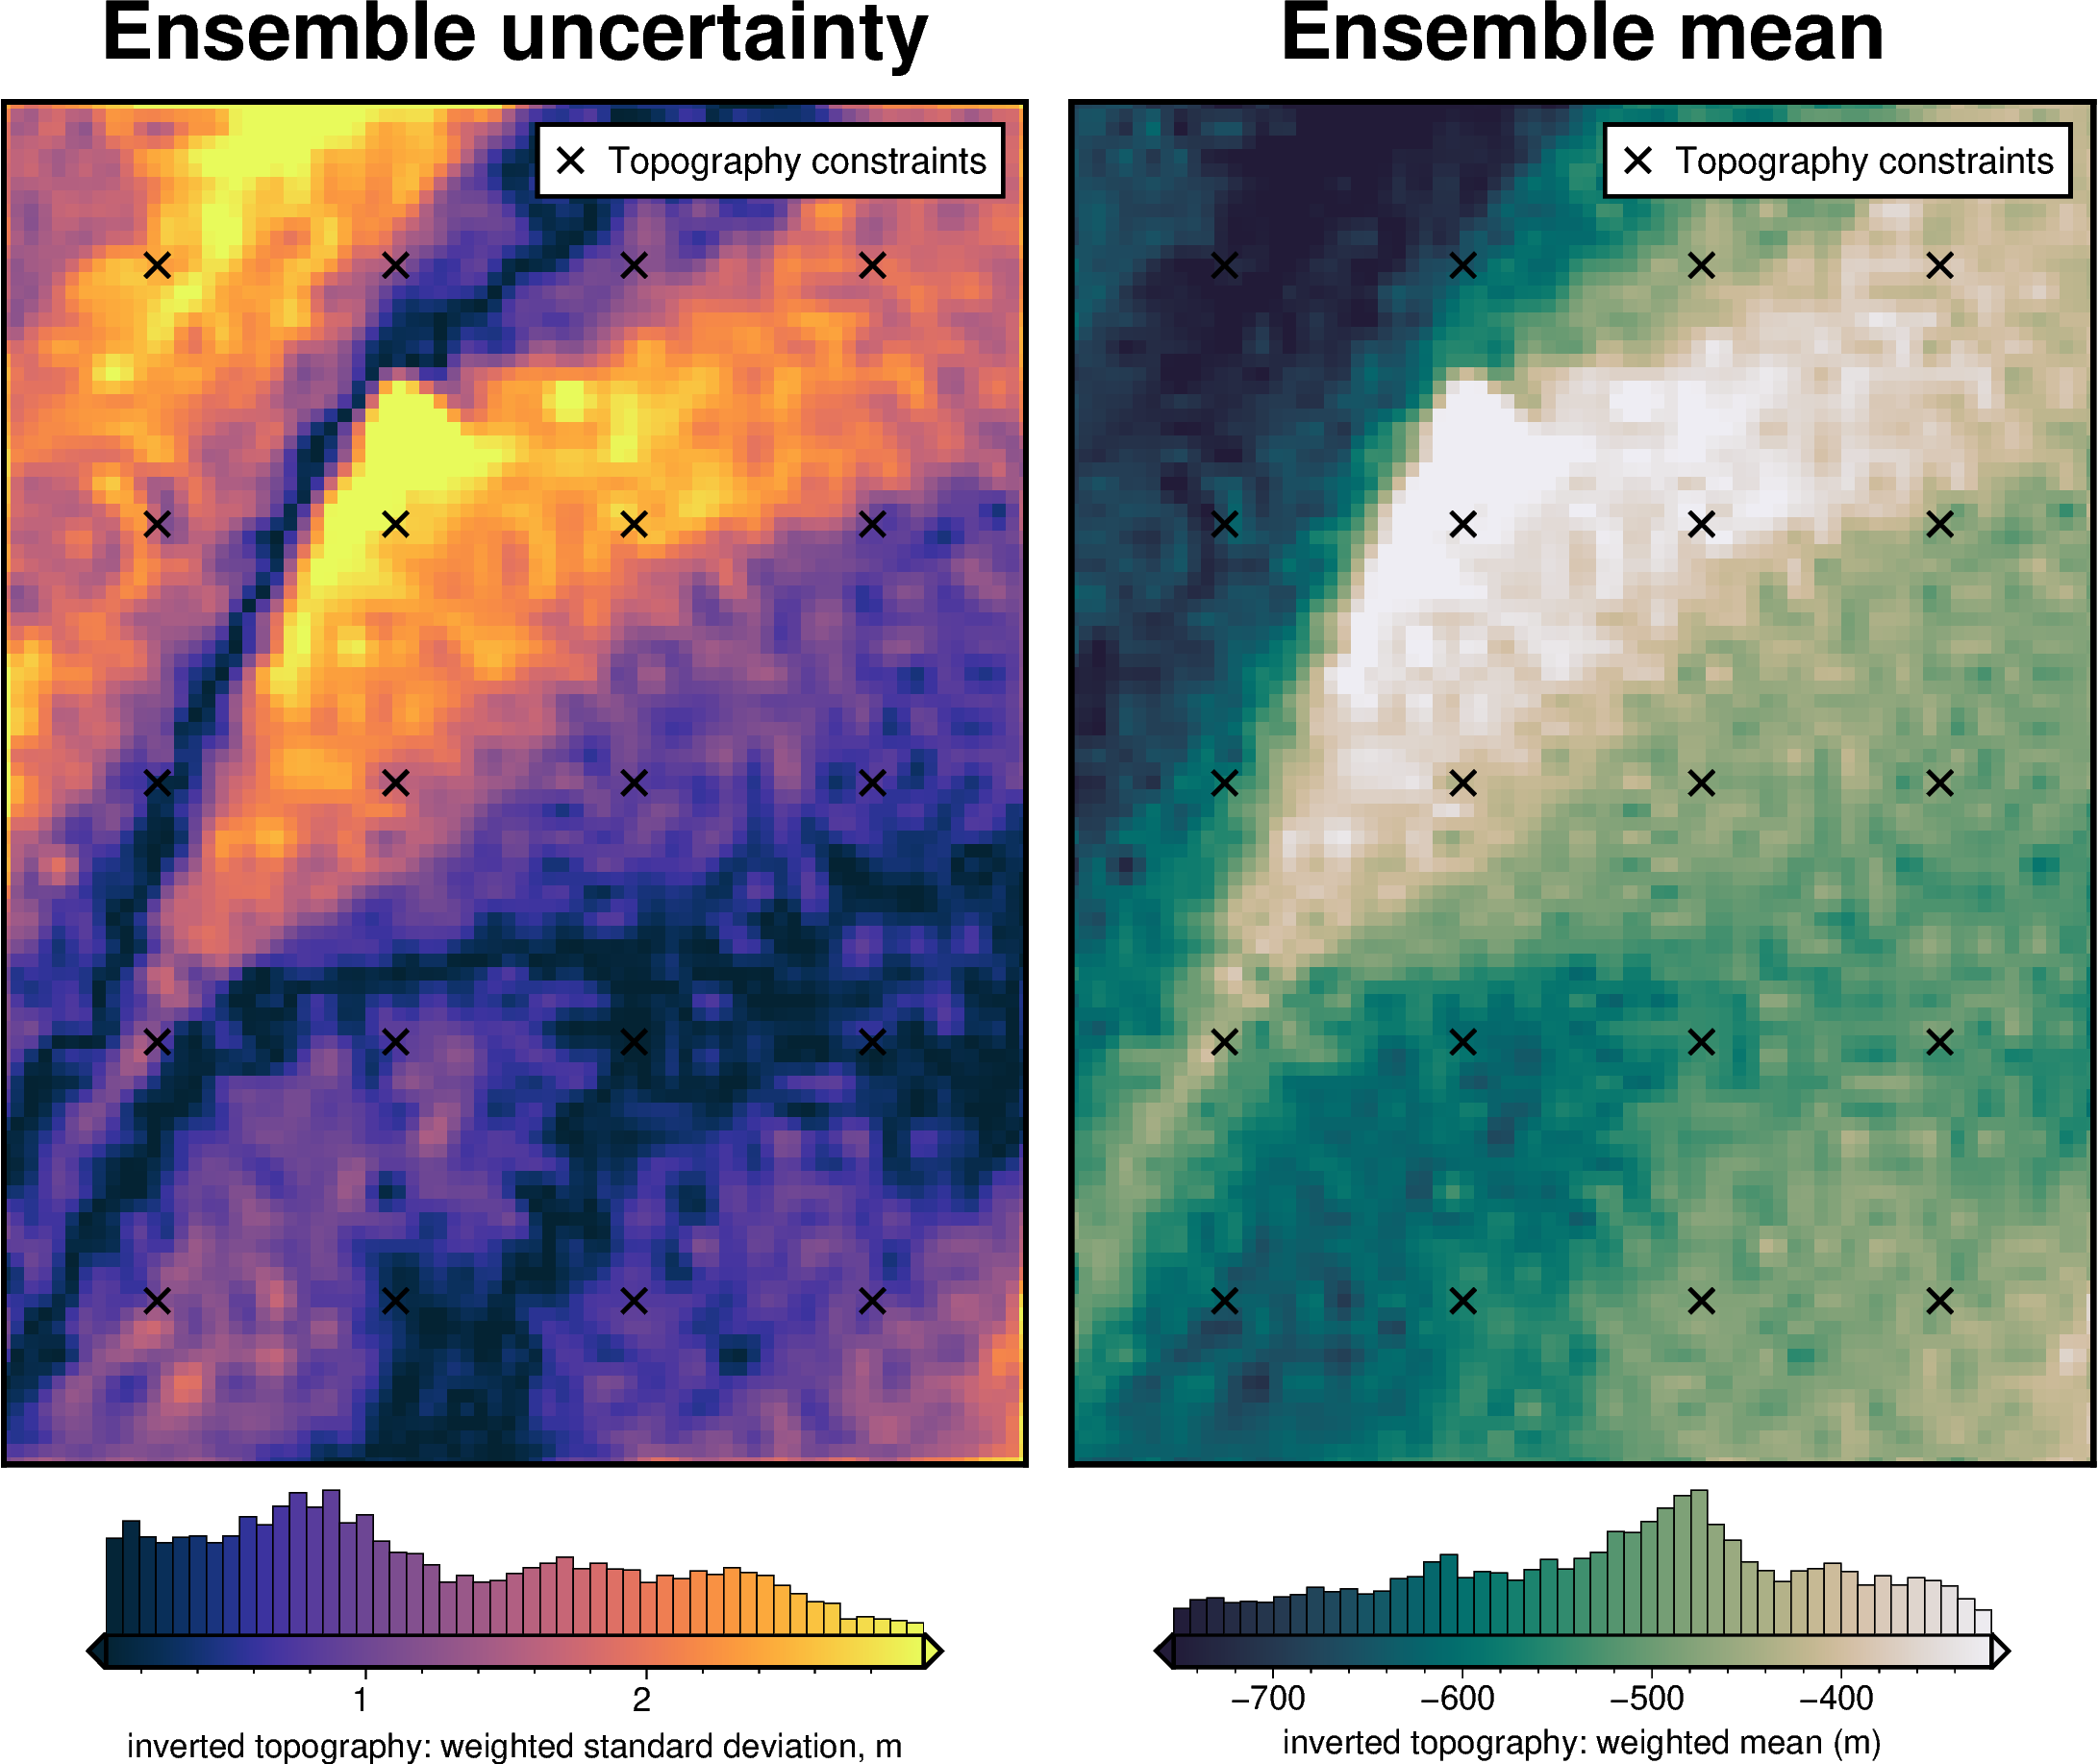

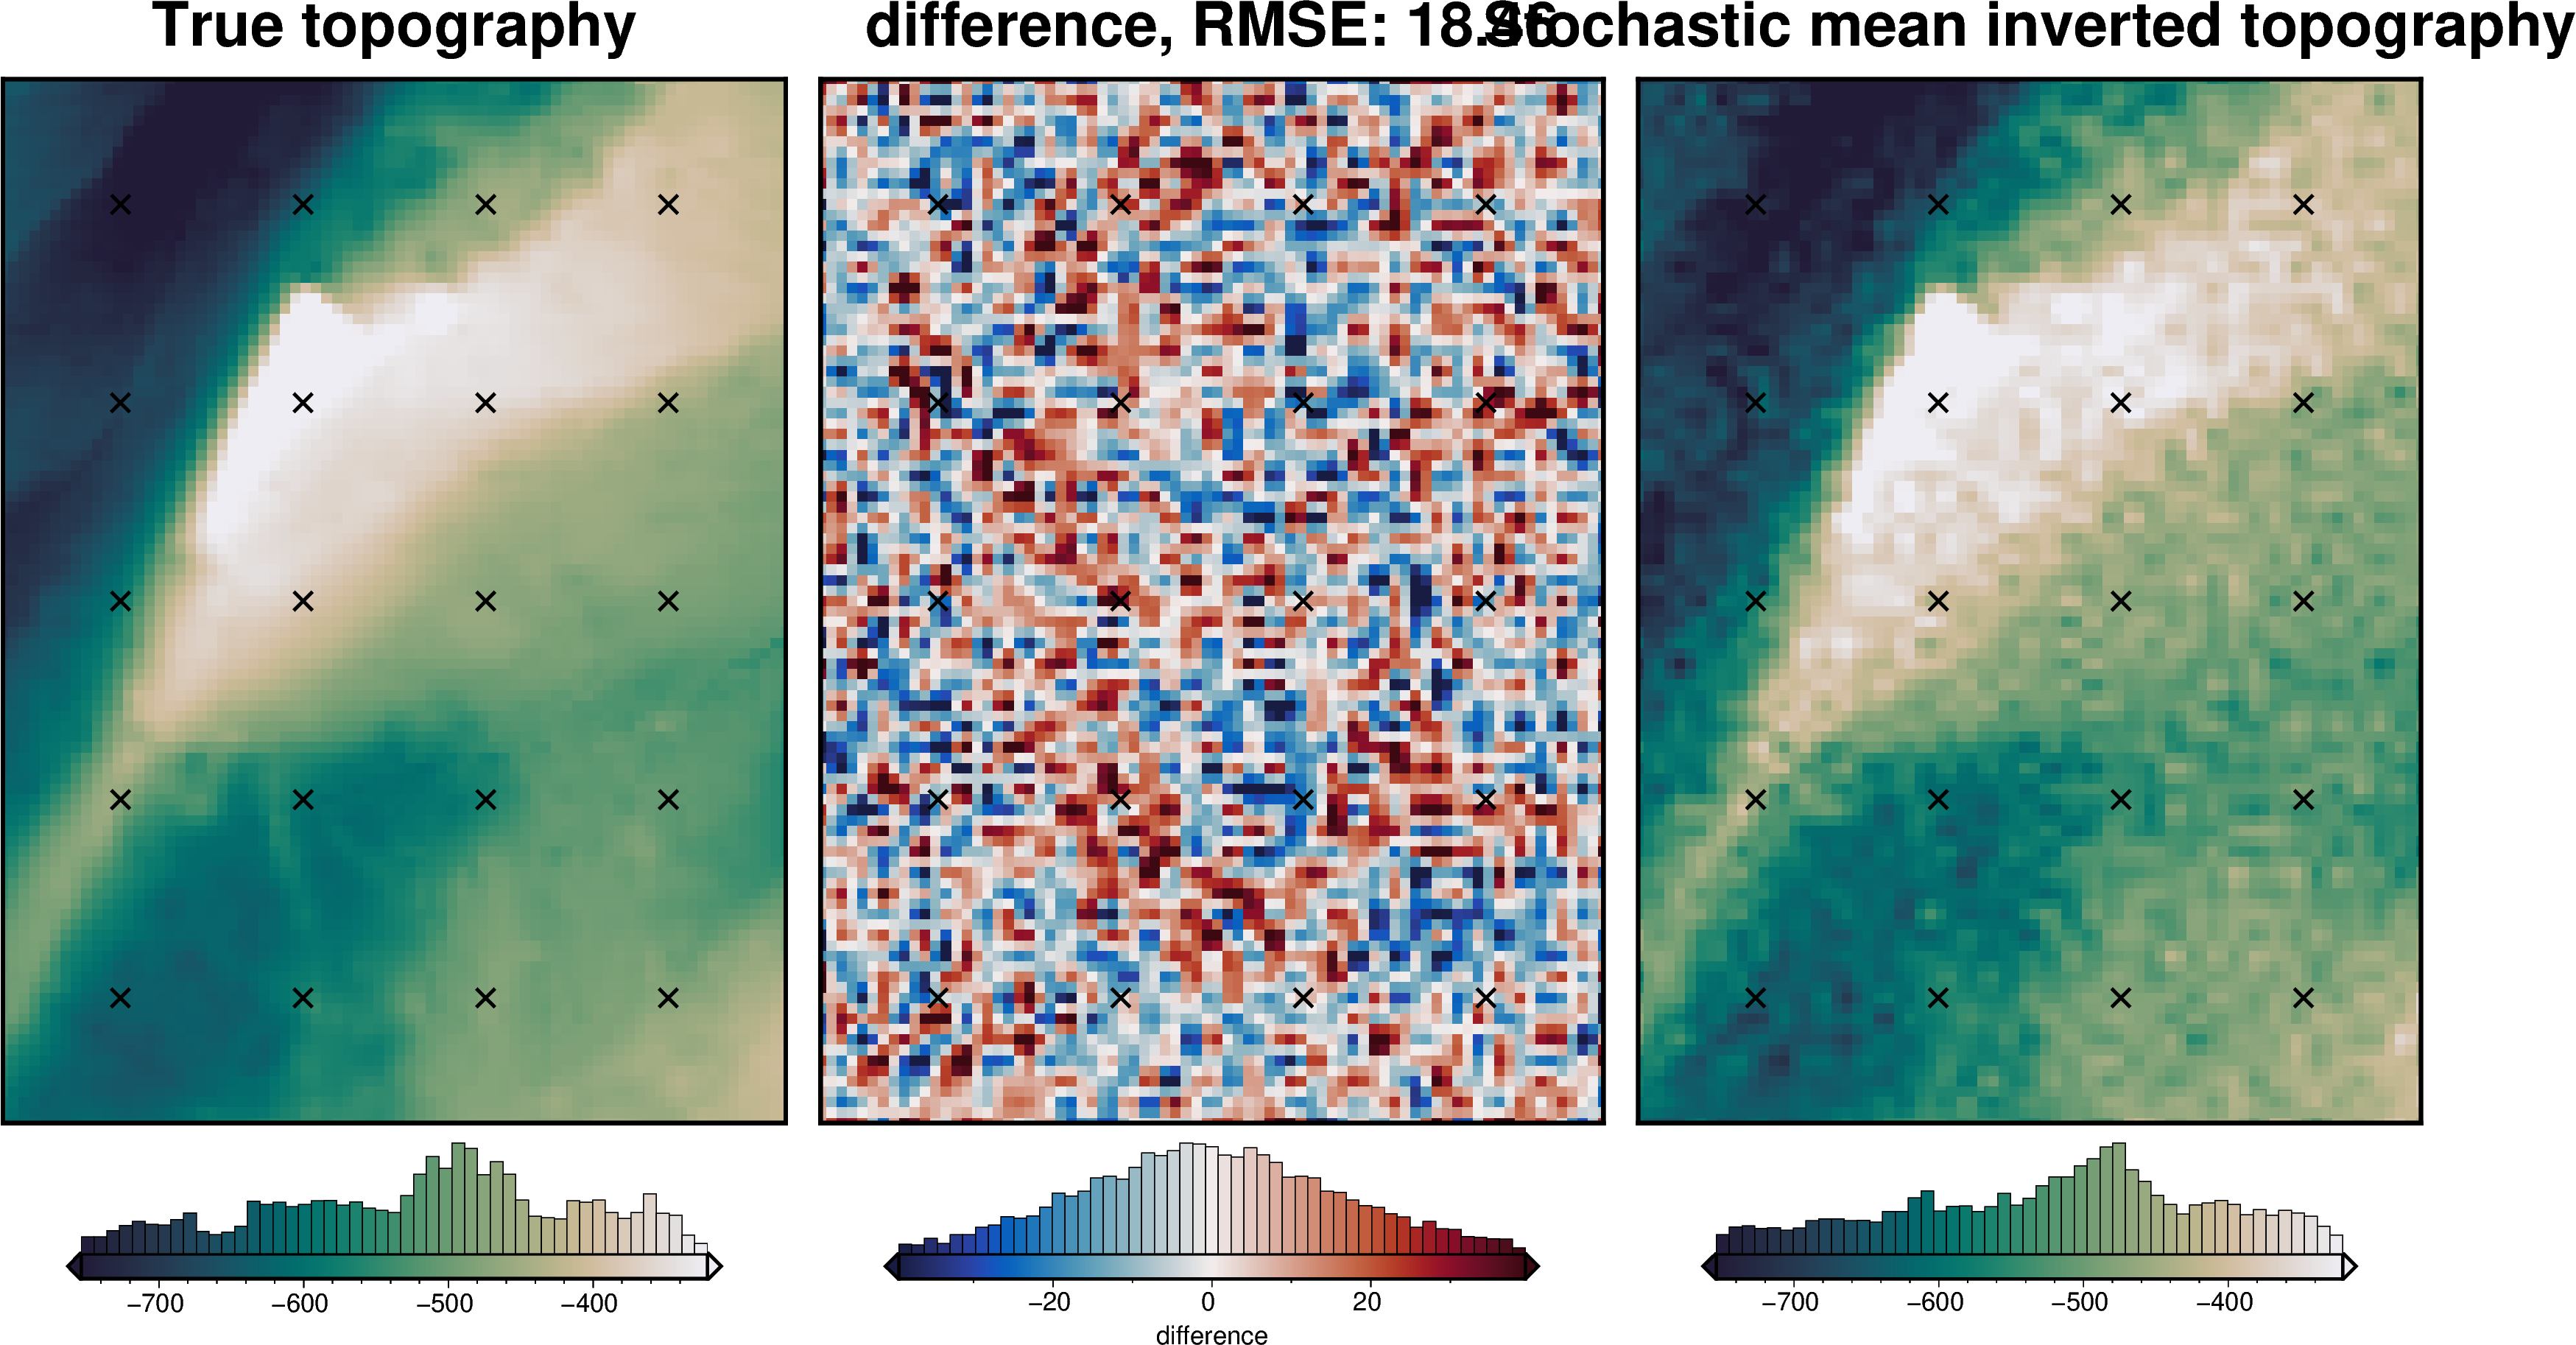

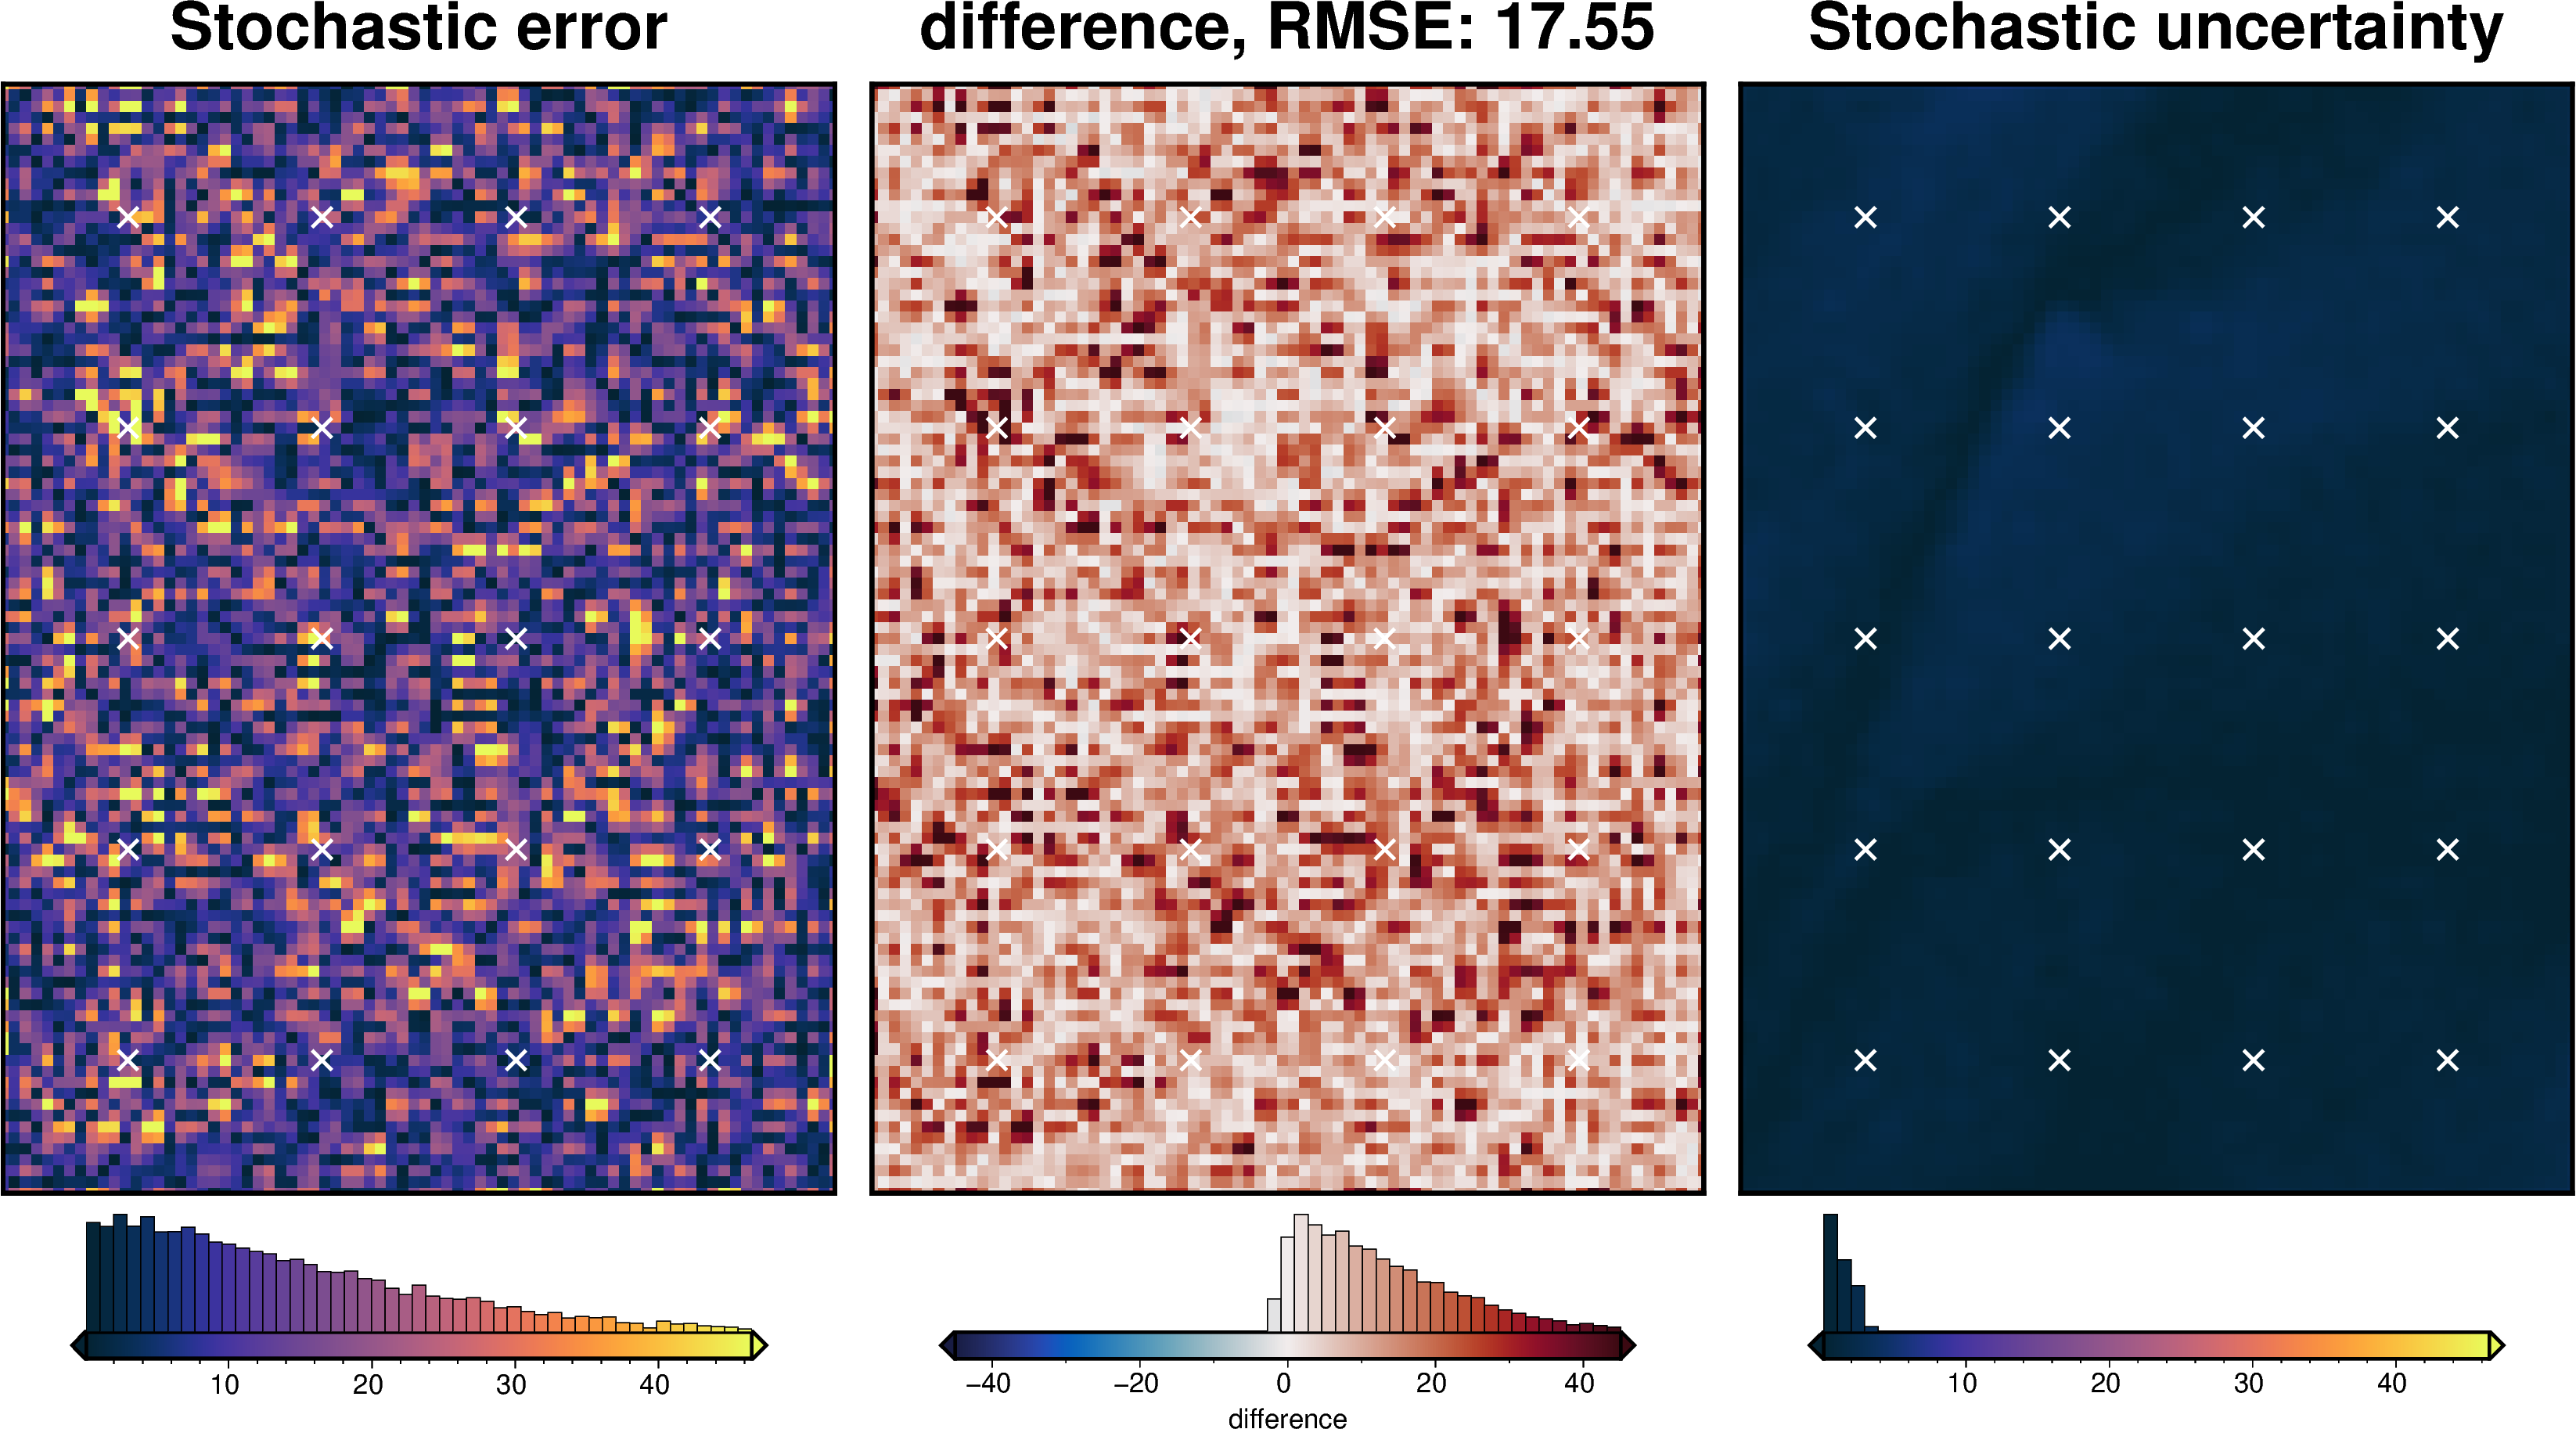

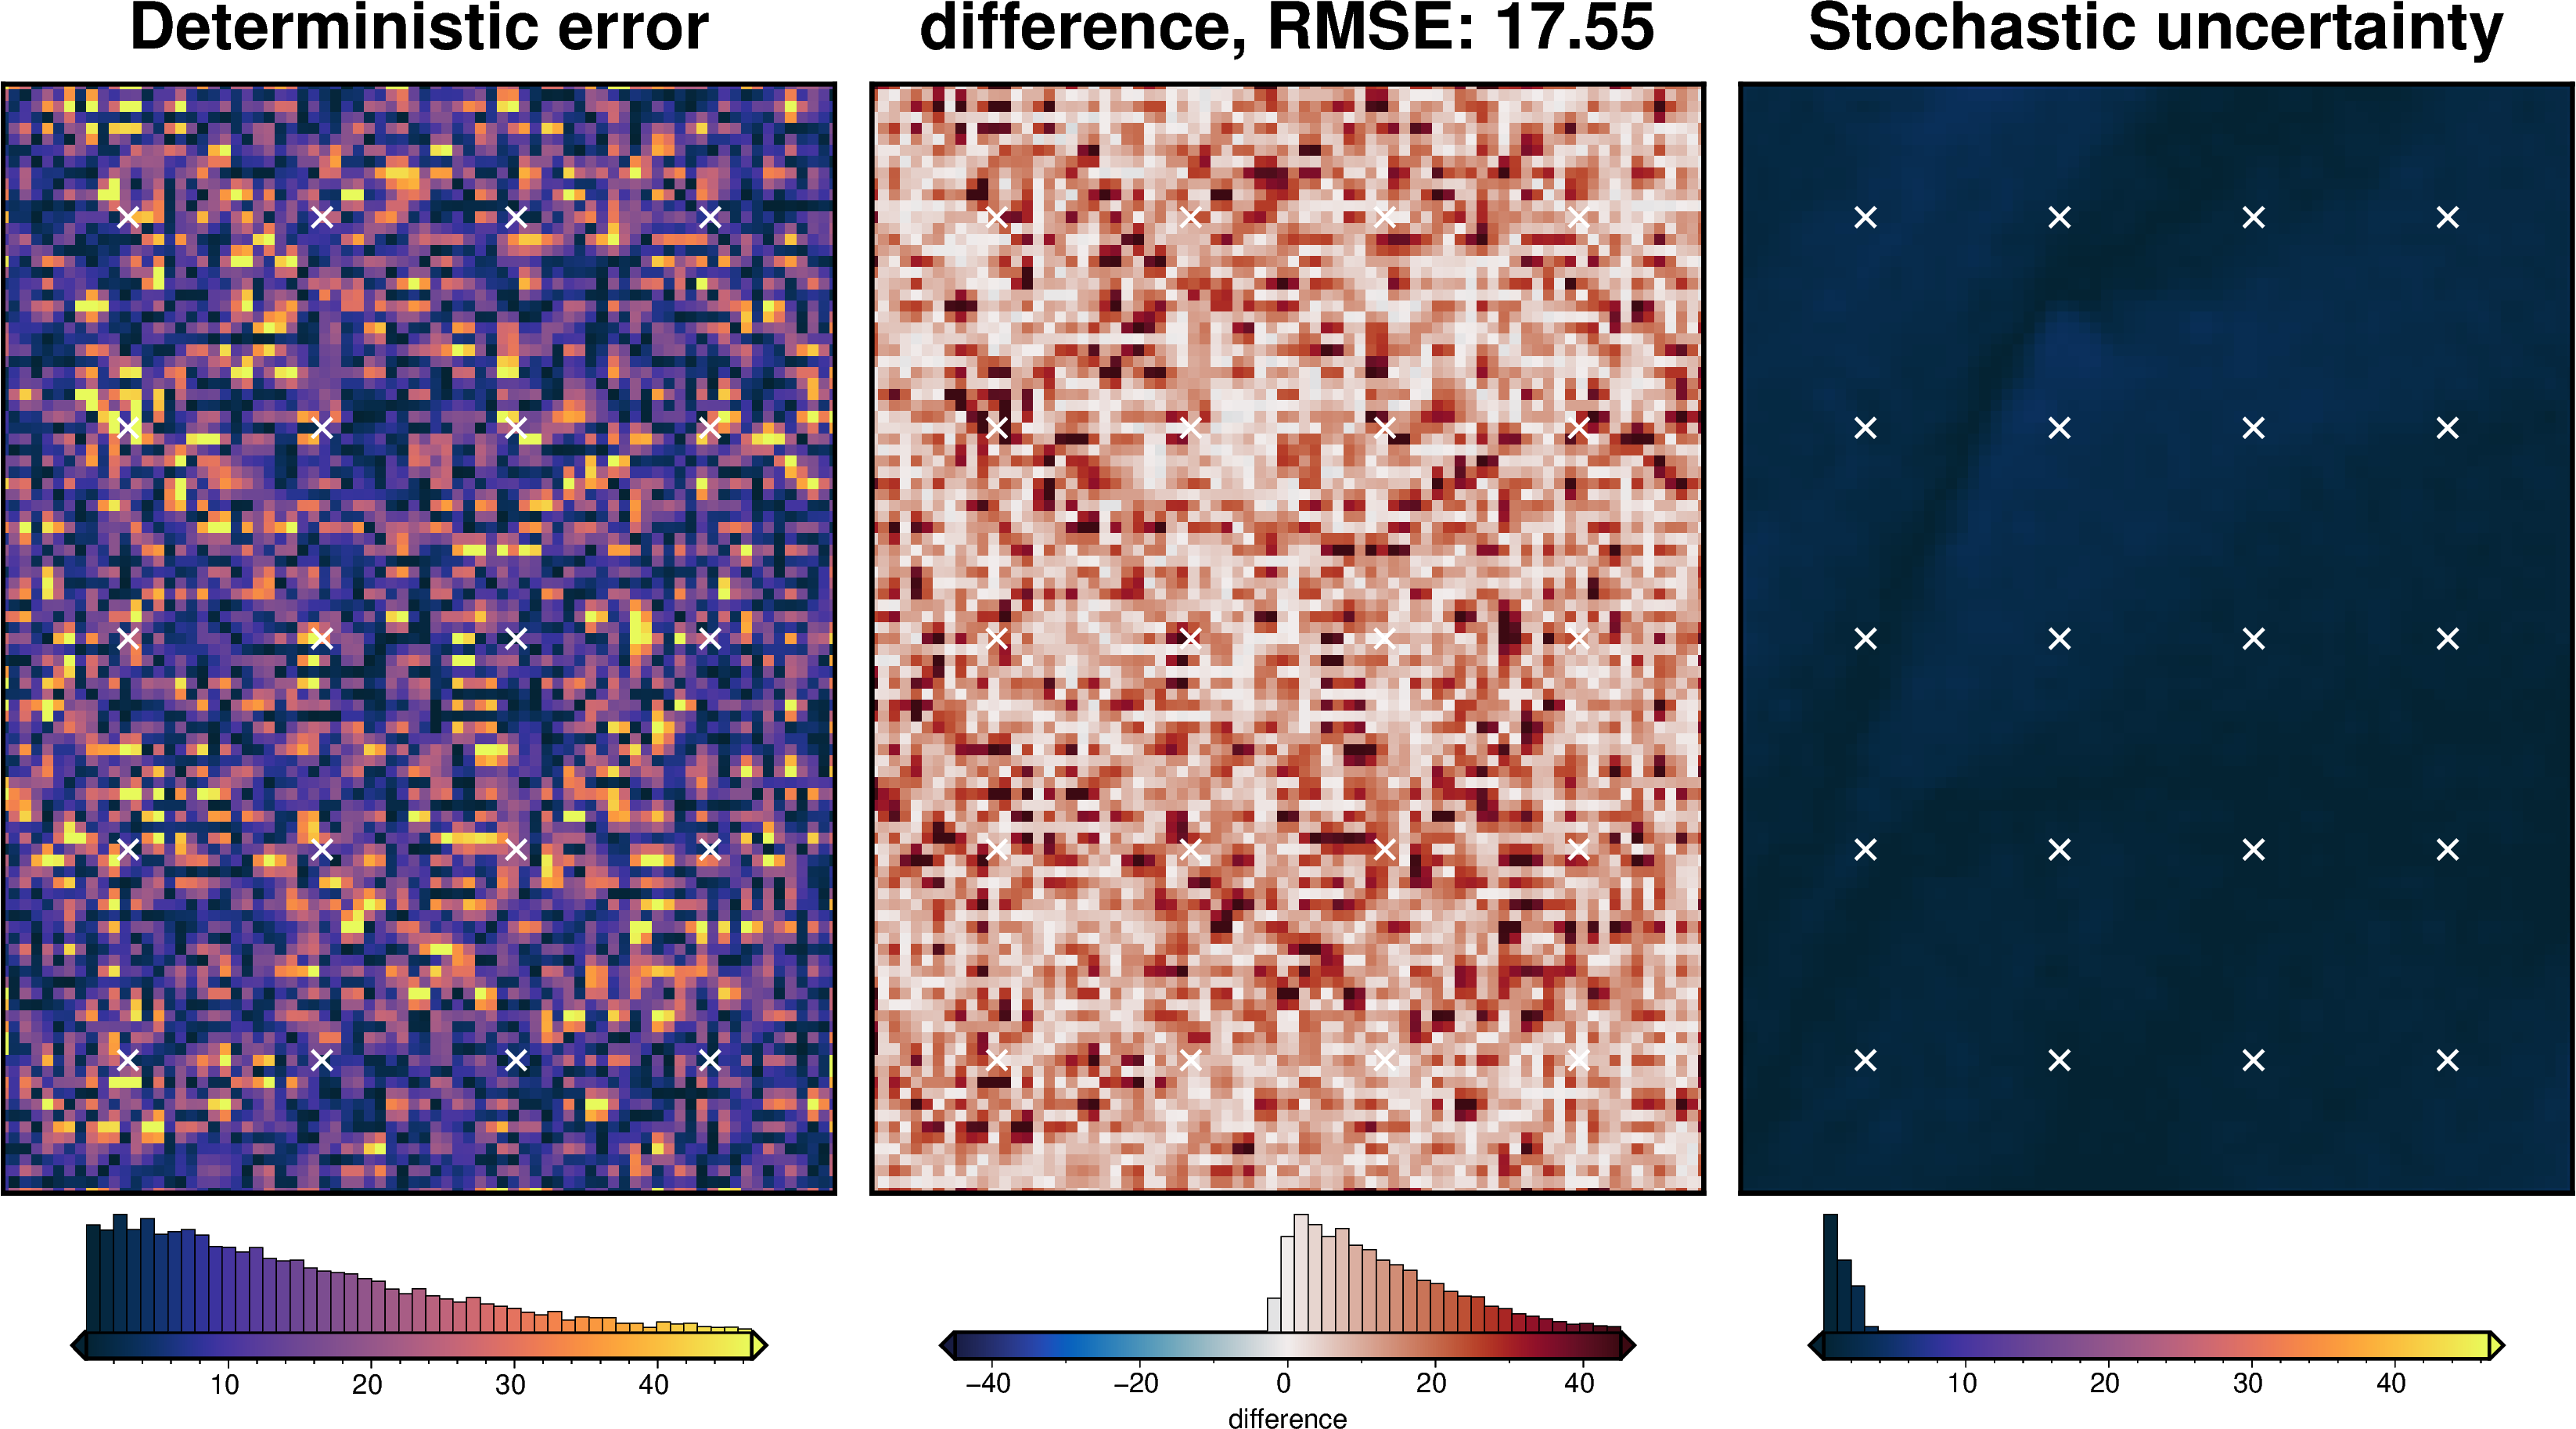

In [31]:
density_dict = {
    "density_contrast": {
        "distribution": "normal",
        "loc": best_density_contrast,
        "scale": stdev,
    },
}
fname = "../../results/Ross_Sea_04_uncertainty_density"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_density_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    parameter_dict=density_dict,
    **uncert_kwargs,
)

stats_ds = RIS_plotting.uncert_plots(
    uncert_density_results,
    # vd.pad_region(inversion_region, -3*spacing),
    inversion_region,
    spacing,
    bathymetry,
    deterministic_bathymetry=final_topography,
    constraint_points=constraint_points[constraint_points.inside],
    weight_by="constraints",
    # weight_by="residual",
    # weight_by=None,
)

## Gravity component

INFO:invert4geom:No pickle files starting with '../../results/Ross_Sea_04_uncertainty_grav' found, creating new files



stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 10
saving results to pickle files with prefix: '../../results/Ross_Sea_04_uncertainty_grav'



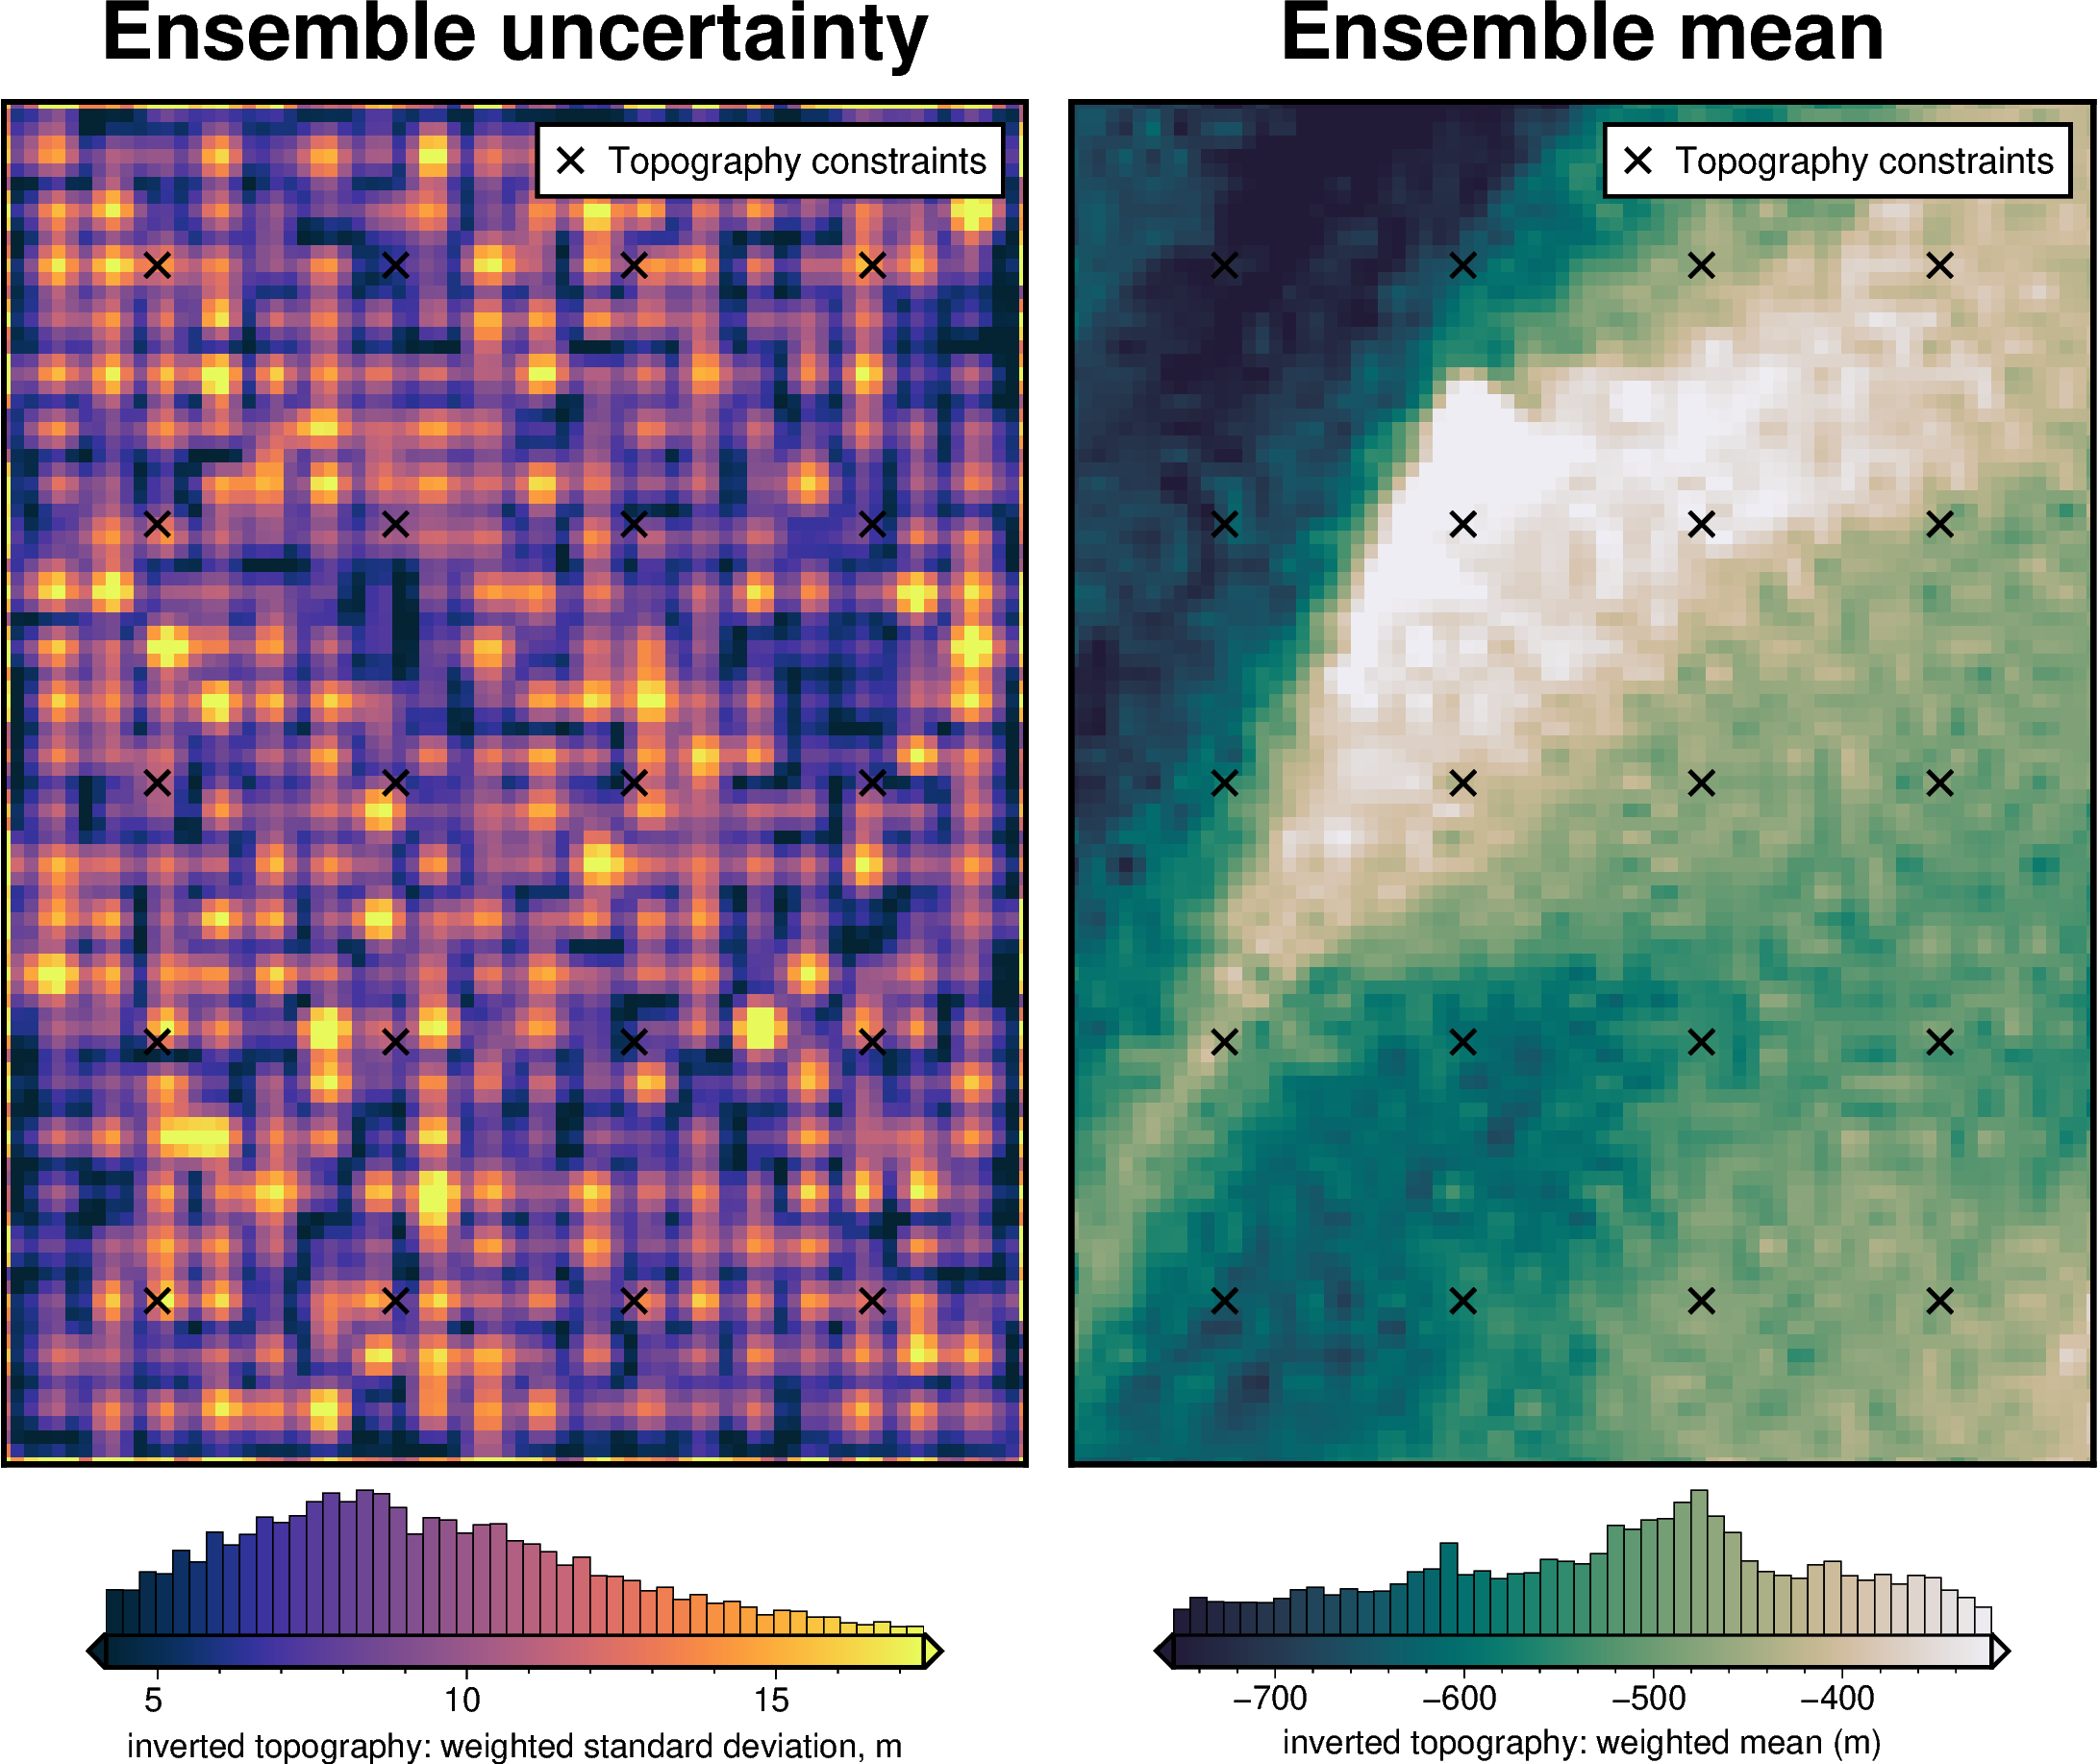

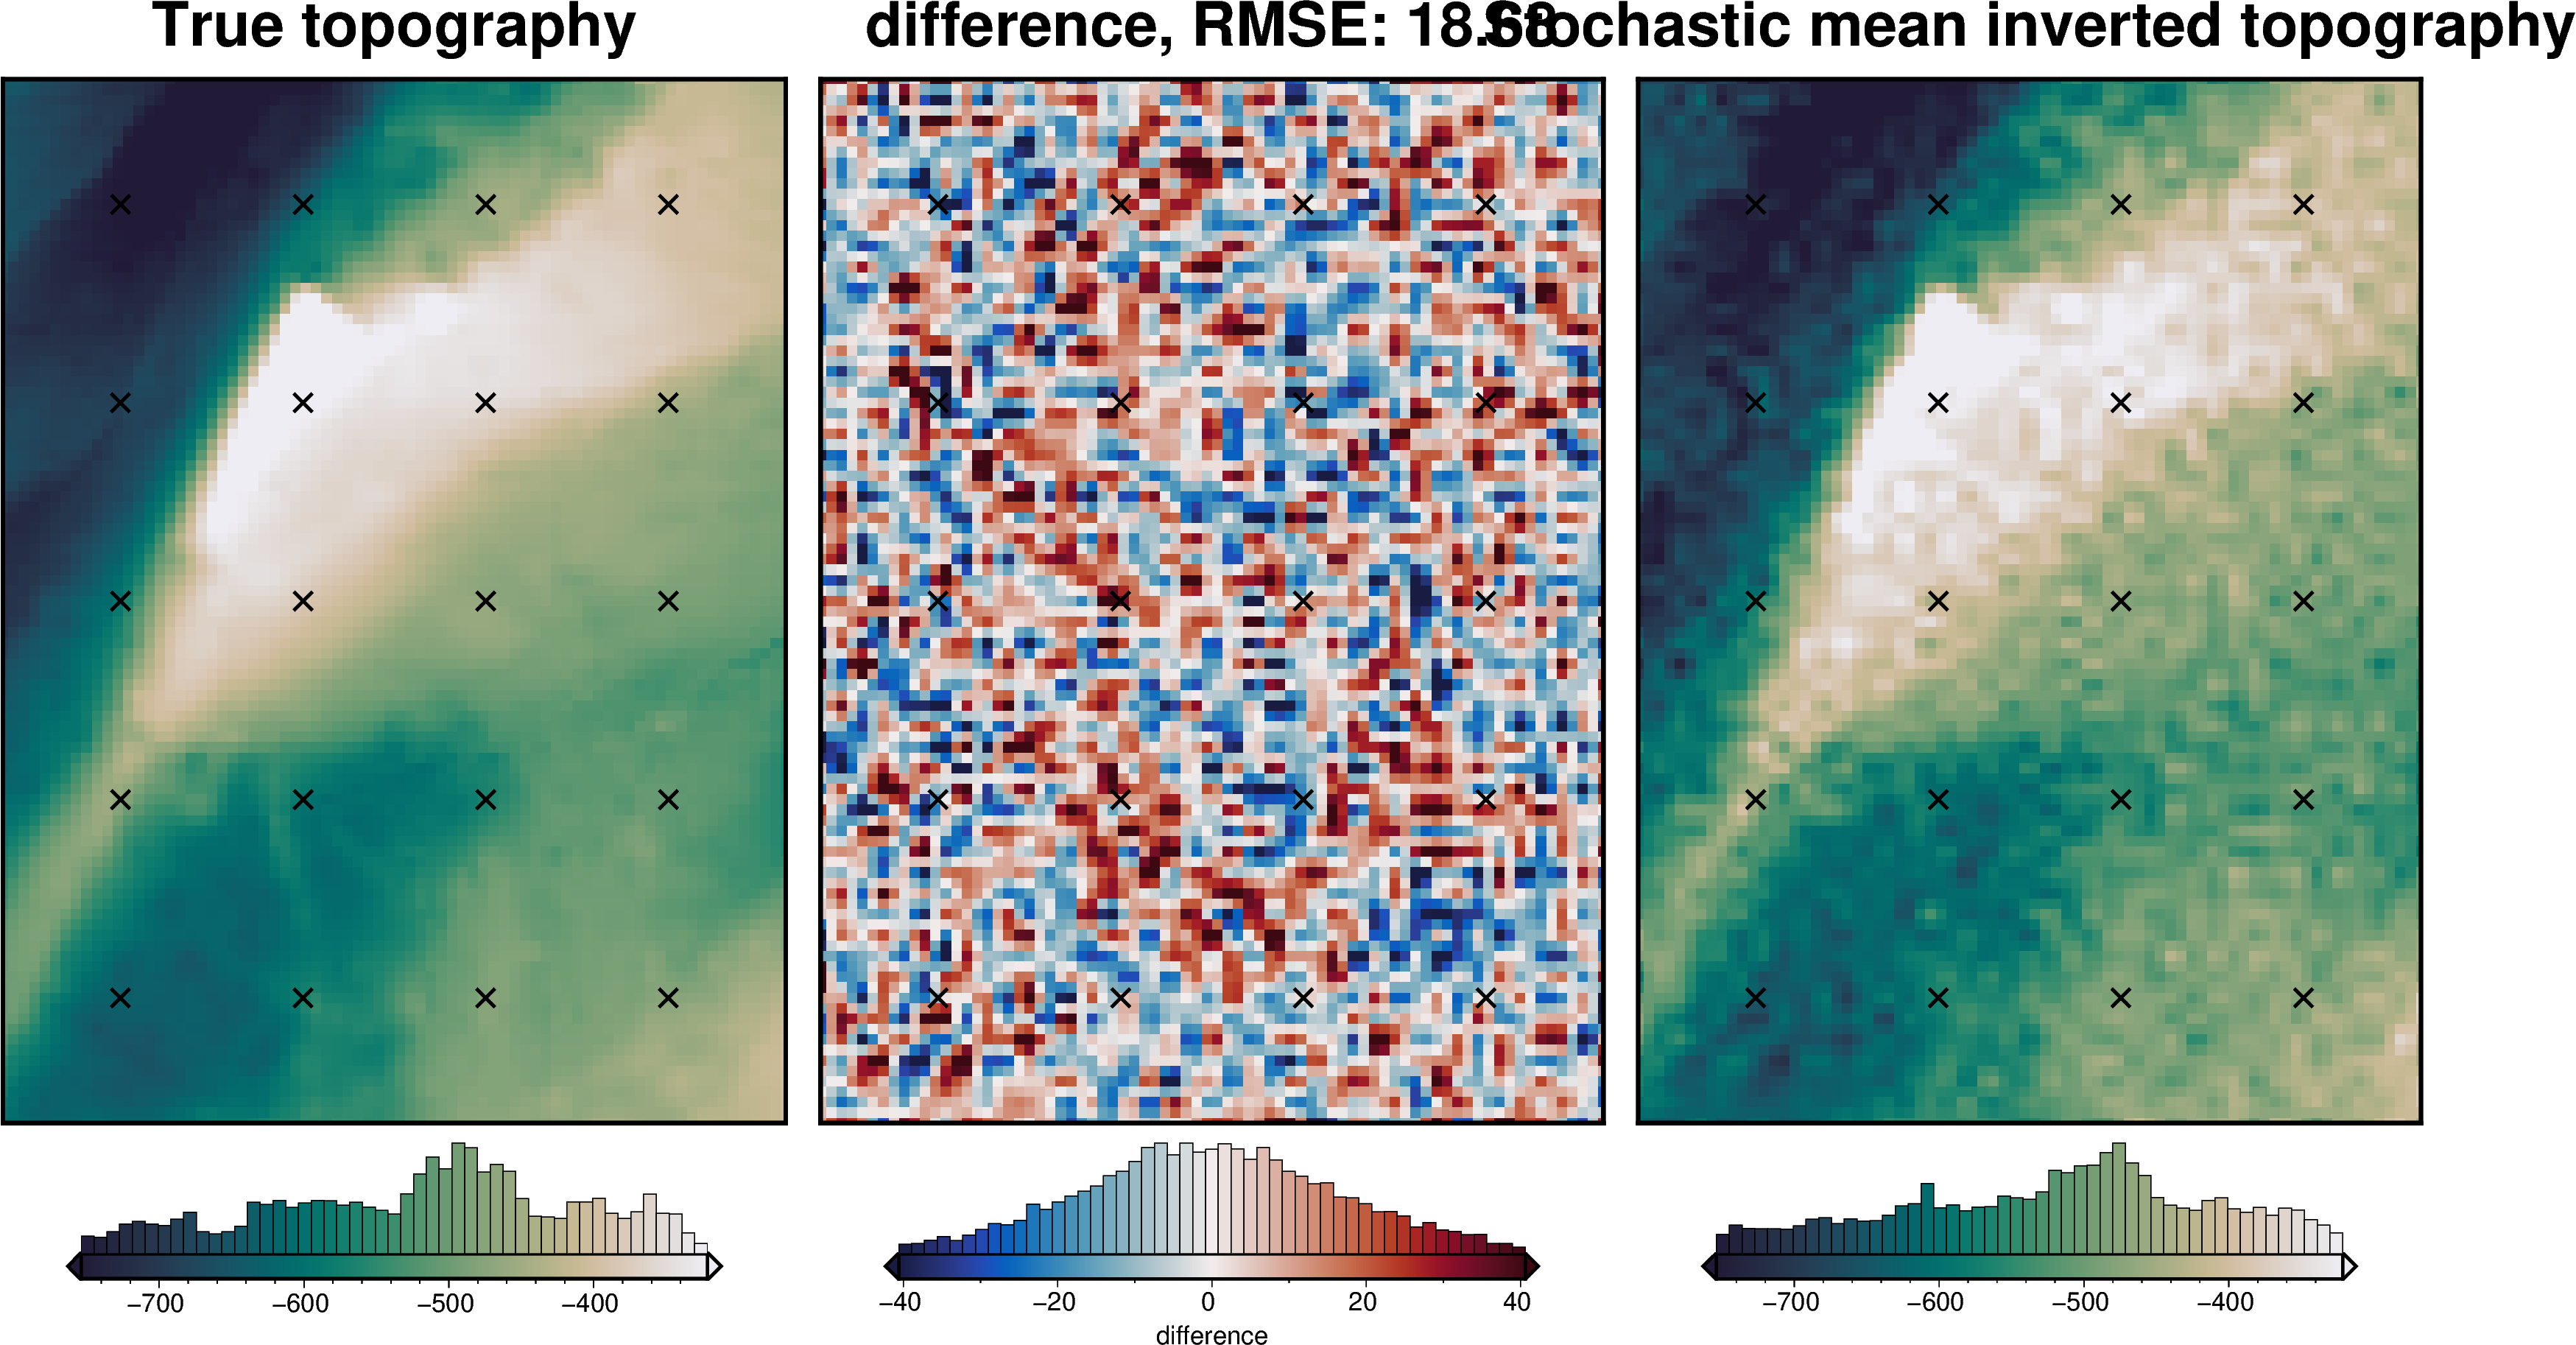

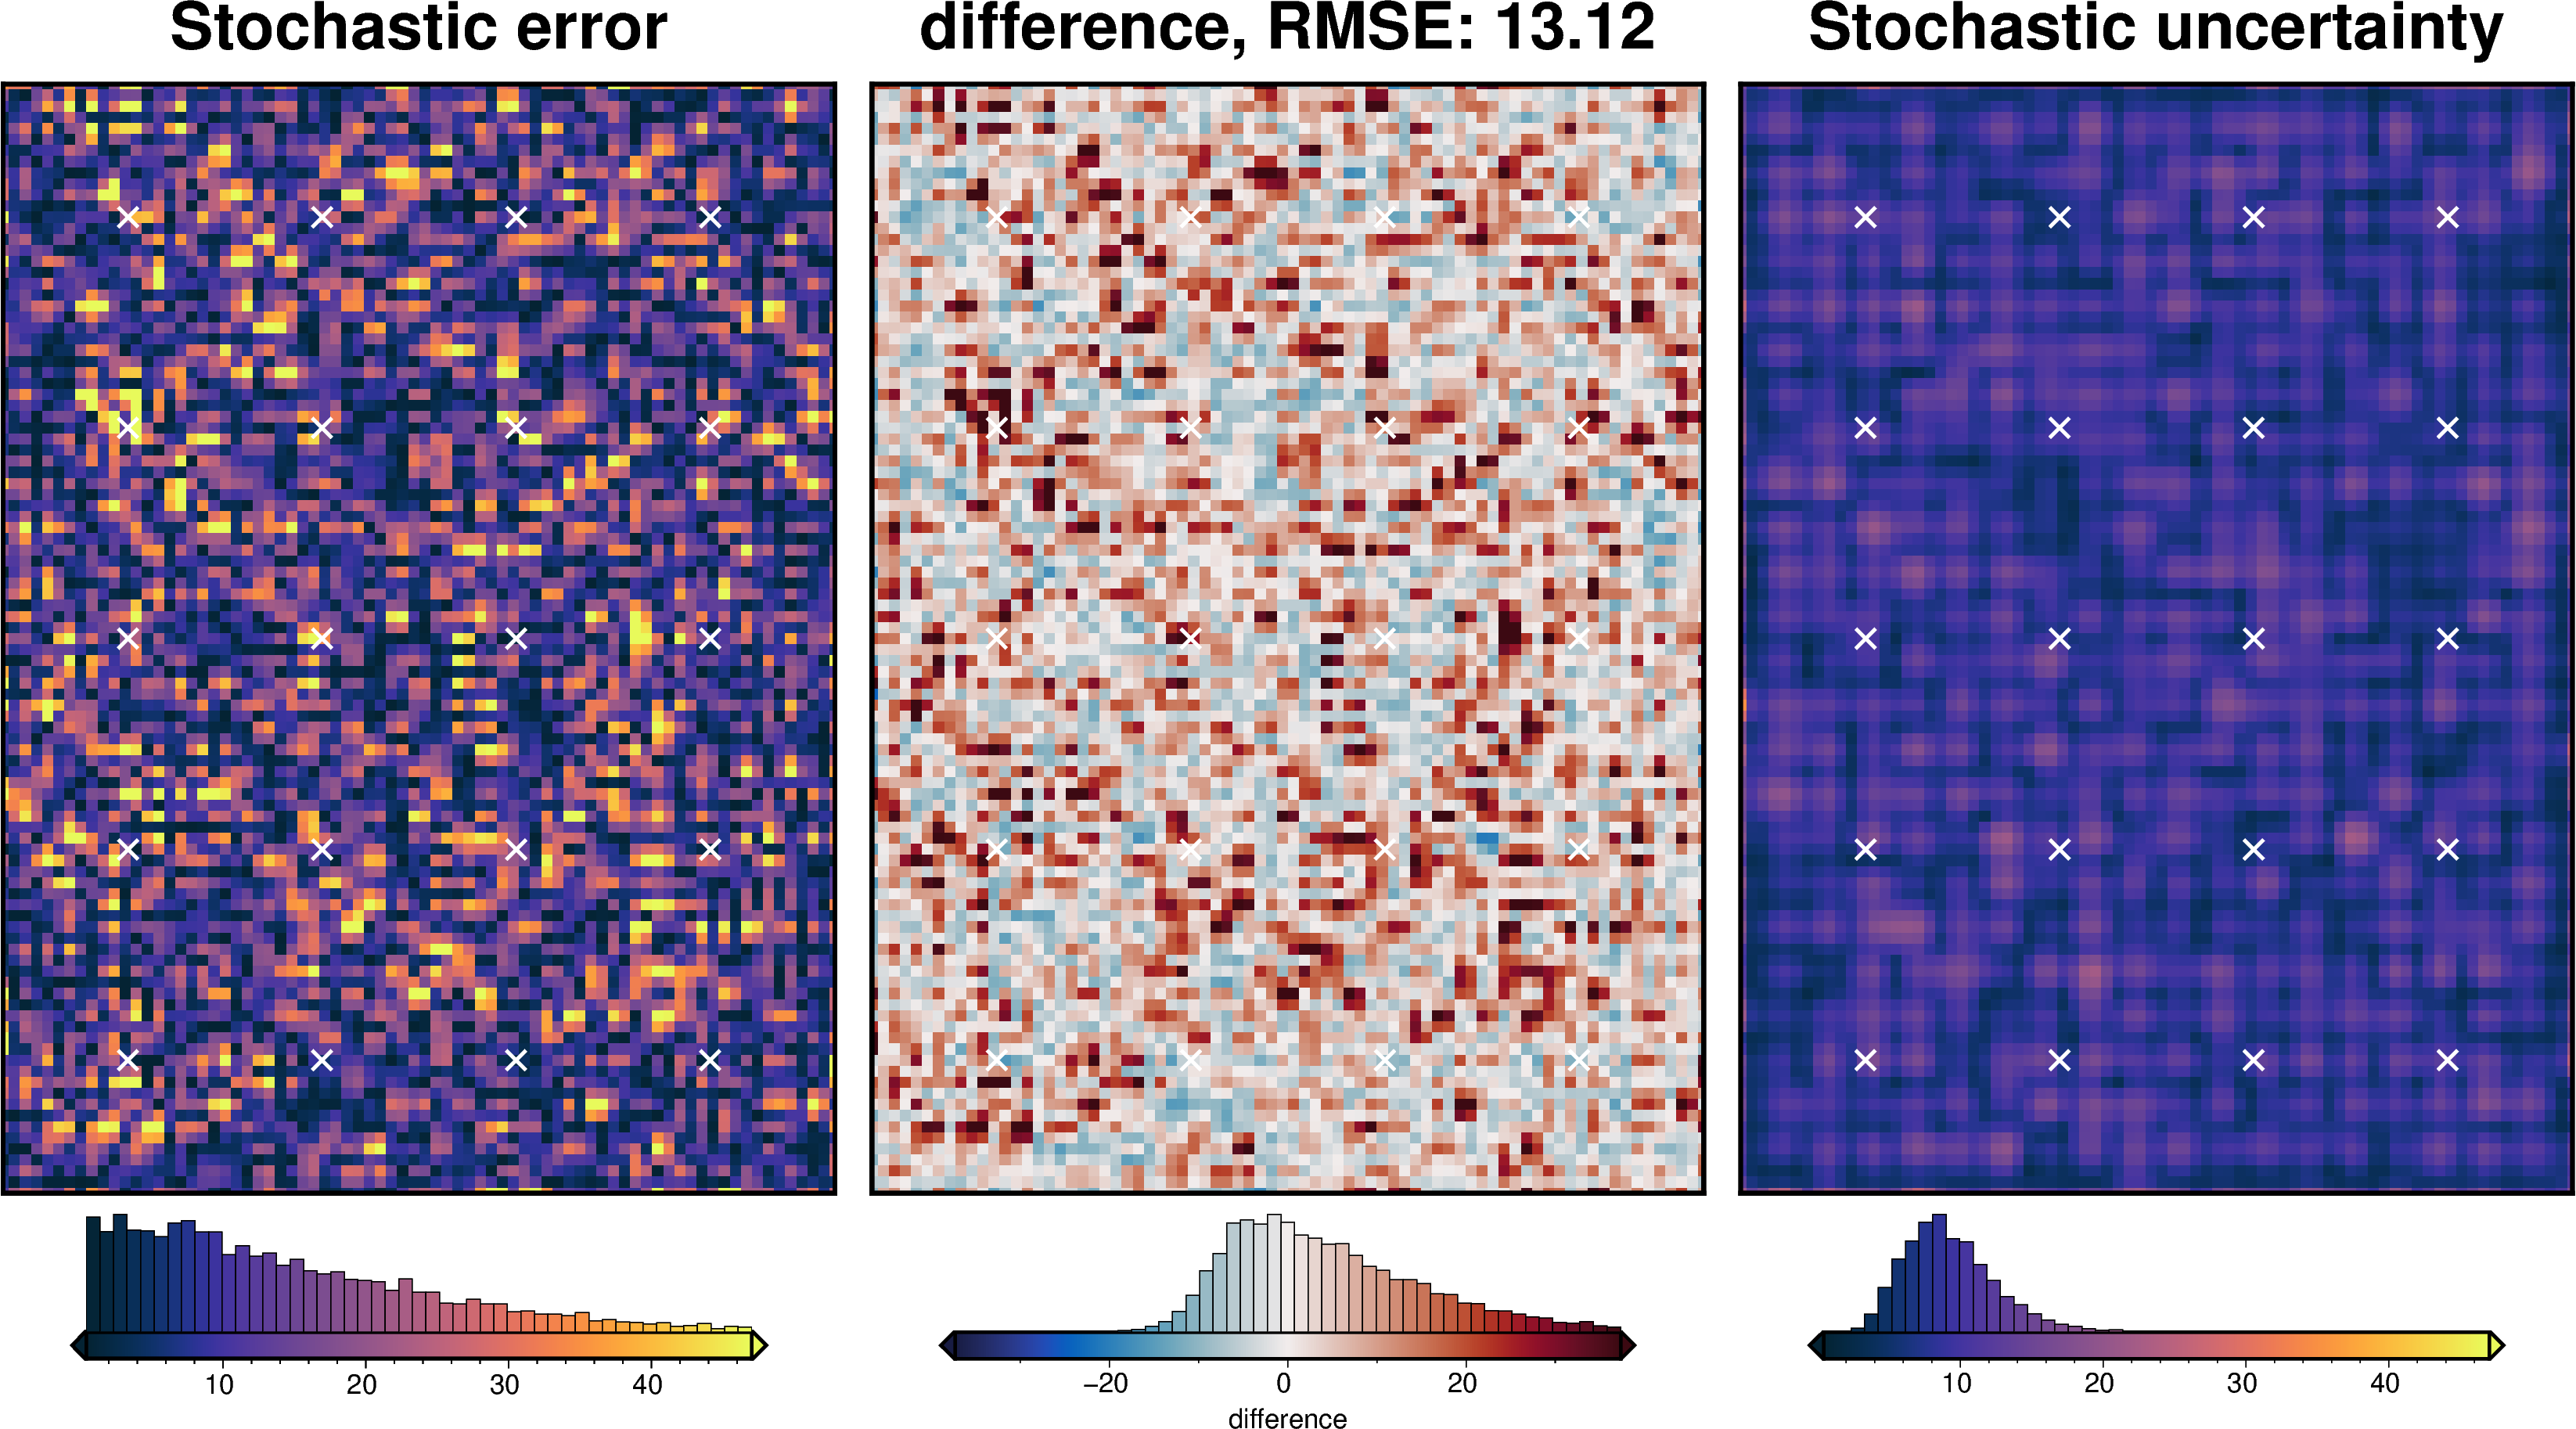

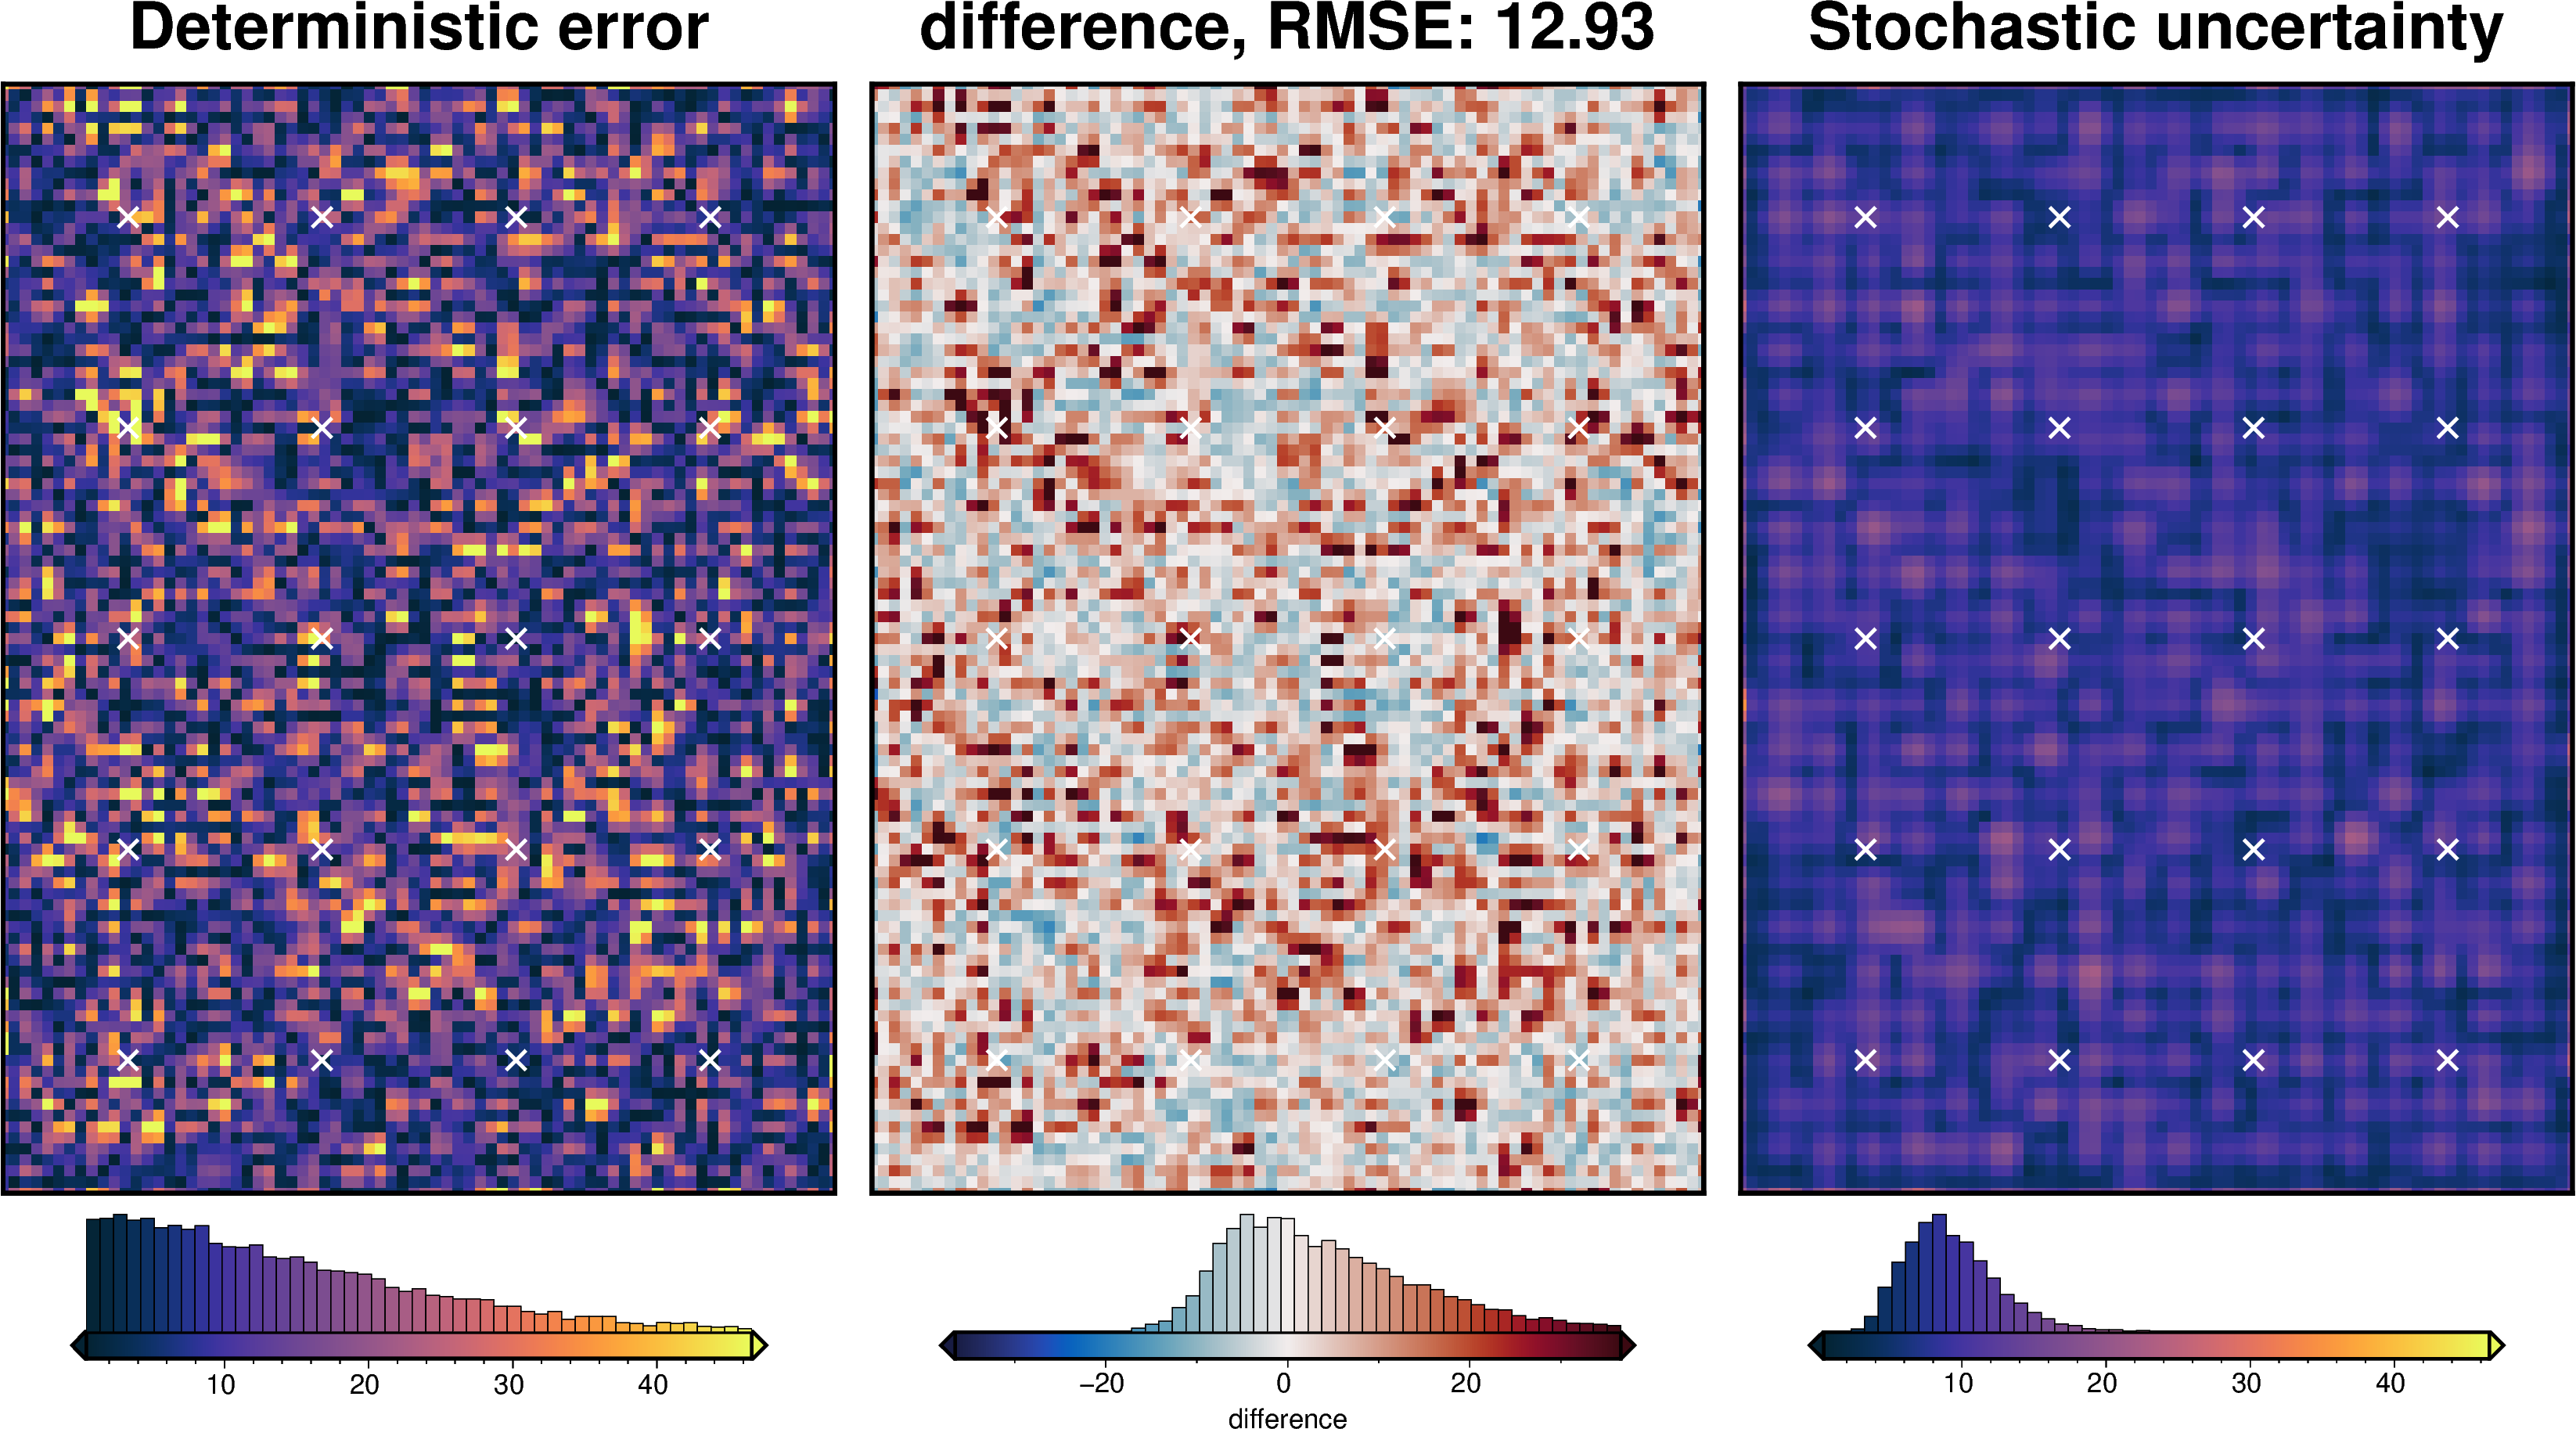

In [40]:
fname = "../../results/Ross_Sea_04_uncertainty_grav"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_grav_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    sample_gravity=True,
    **uncert_kwargs,
)

stats_ds = RIS_plotting.uncert_plots(
    uncert_grav_results,
    # vd.pad_region(inversion_region, -3*spacing),
    inversion_region,
    spacing,
    bathymetry,
    deterministic_bathymetry=final_topography,
    constraint_points=constraint_points[constraint_points.inside],
    weight_by="constraints",
    # weight_by="residual",
    # weight_by=None,
)

## Total uncertainty

INFO:invert4geom:Sampled 'solver_damping' parameter values; mean: 0.0110898206583217, min: 0.006384869180534387, max: 0.01803705506009188
INFO:invert4geom:Sampled 'density_contrast' parameter values; mean: 1478.0, min: 1477.7744931862128, max: 1478.2255068137872
INFO:invert4geom:No pickle files starting with '../../results/Ross_Sea_04_uncertainty_full' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: '../../results/Ross_Sea_04_uncertainty_full'



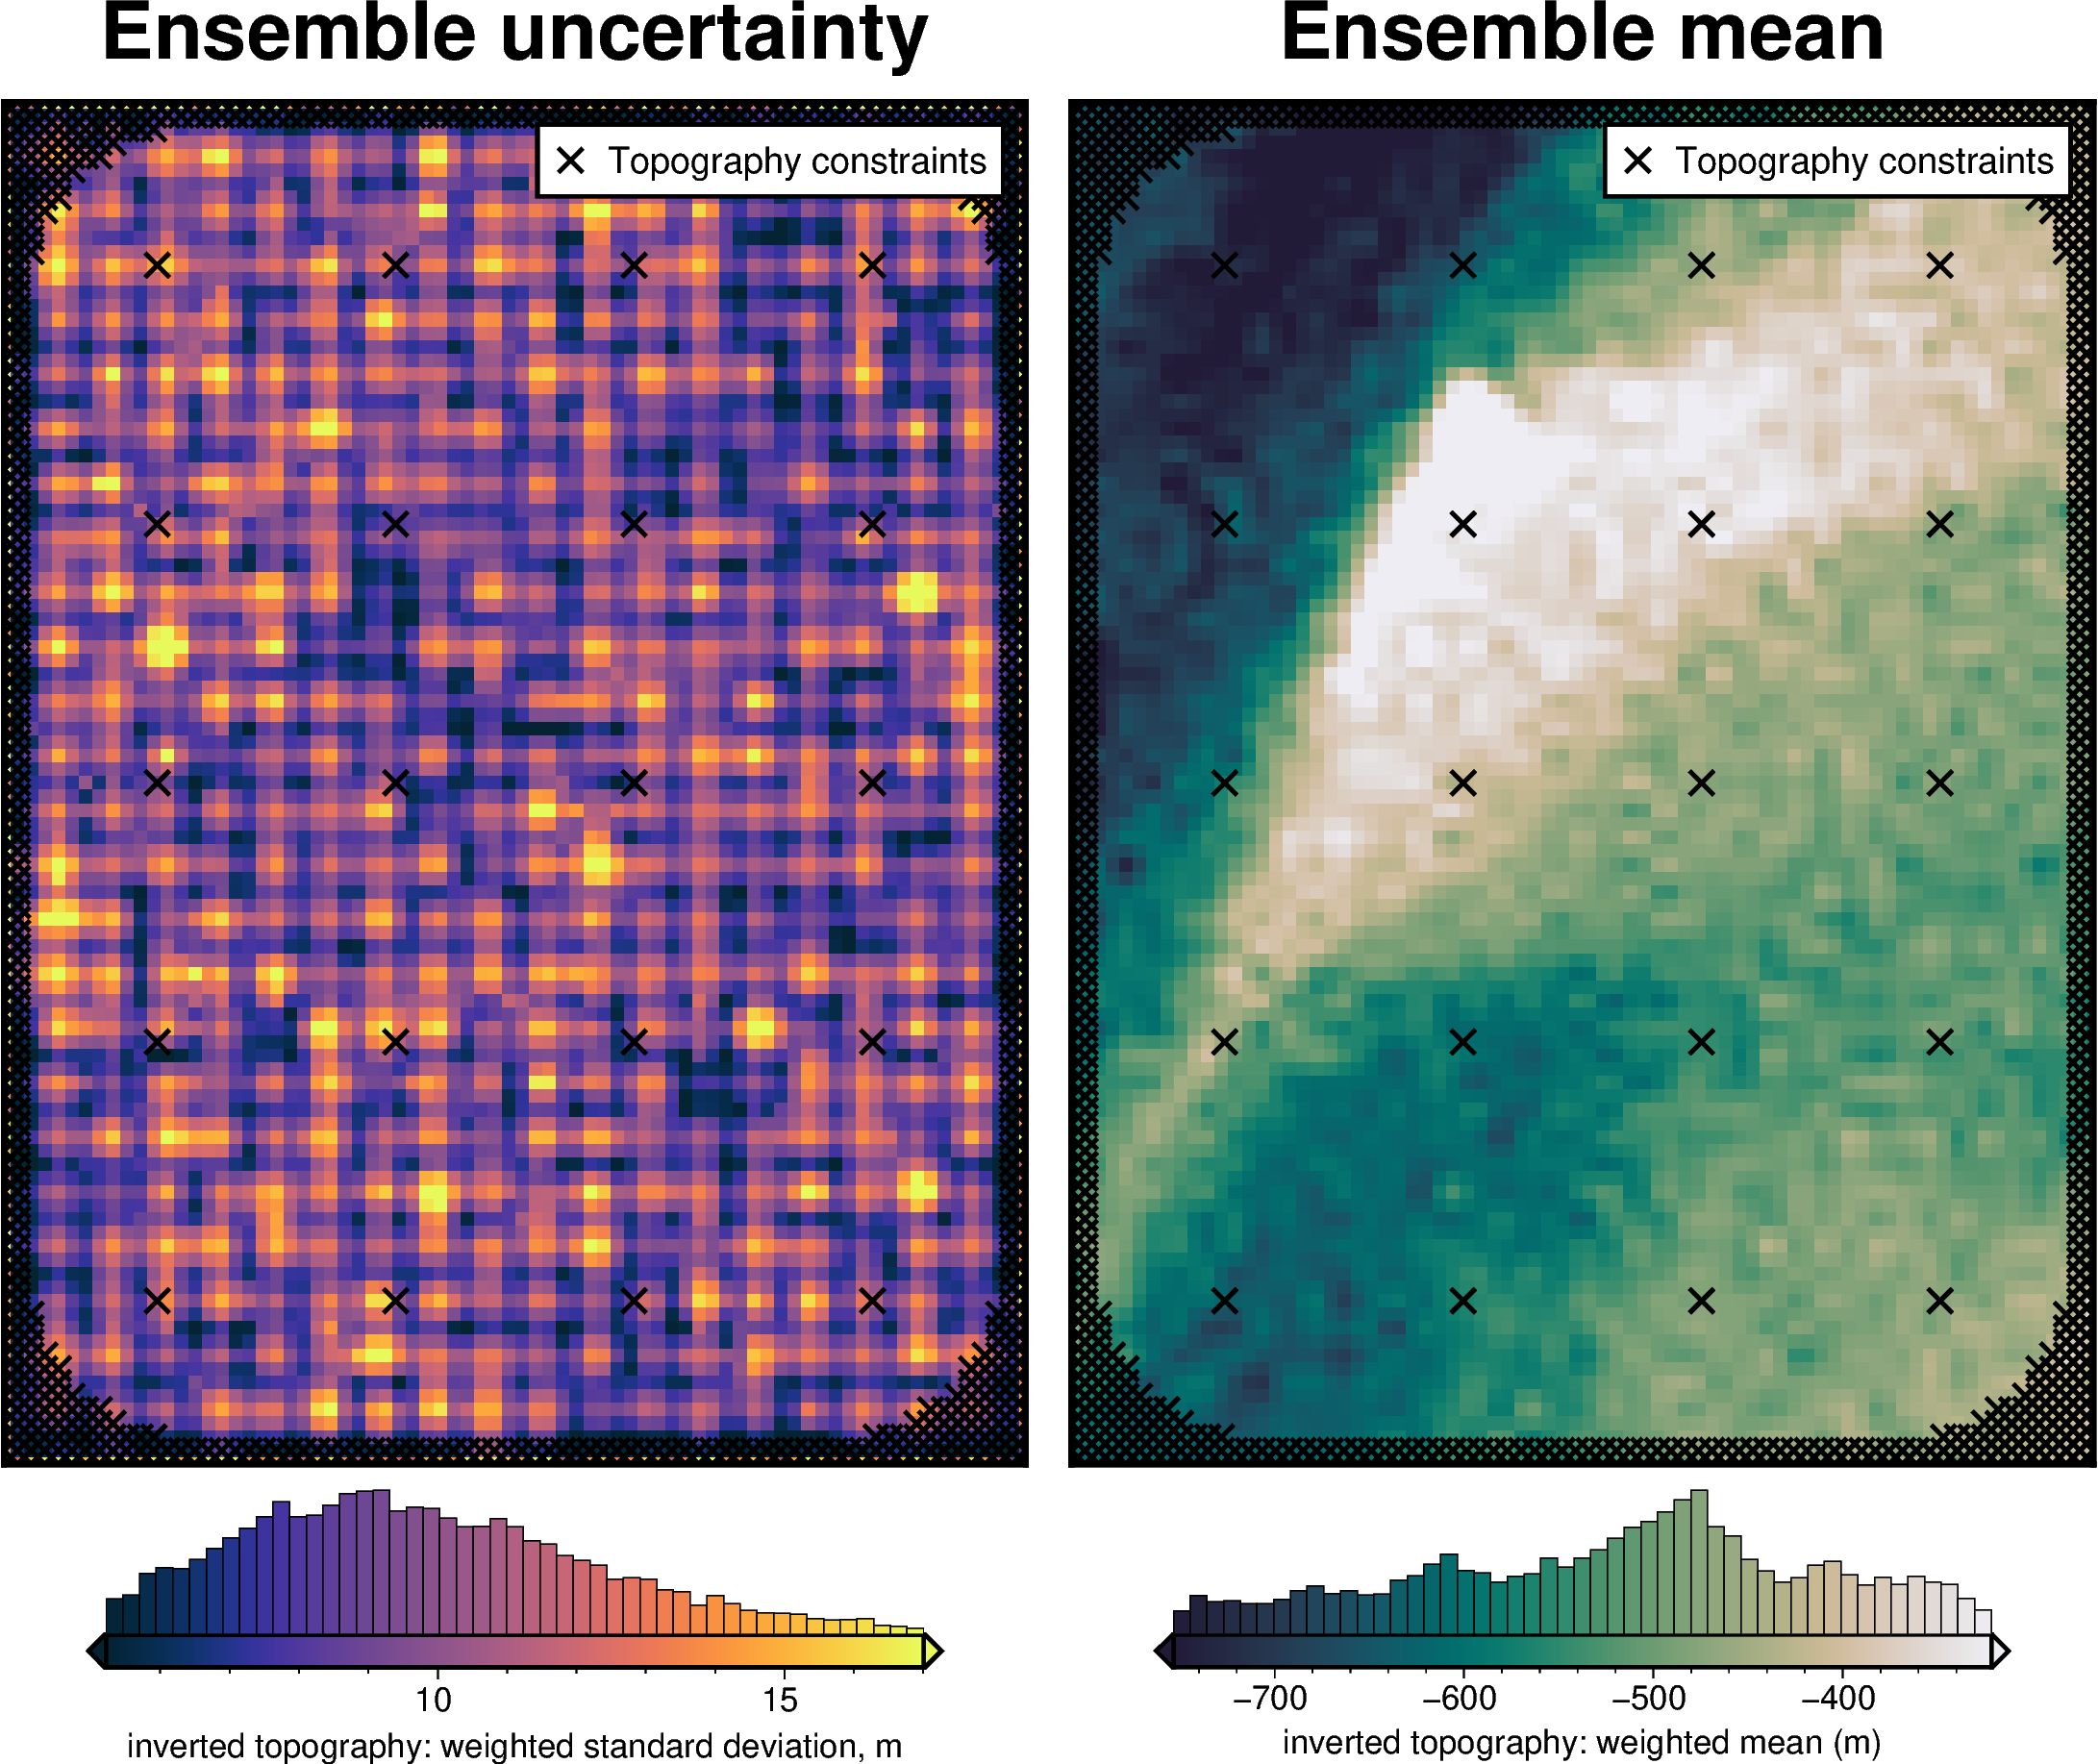

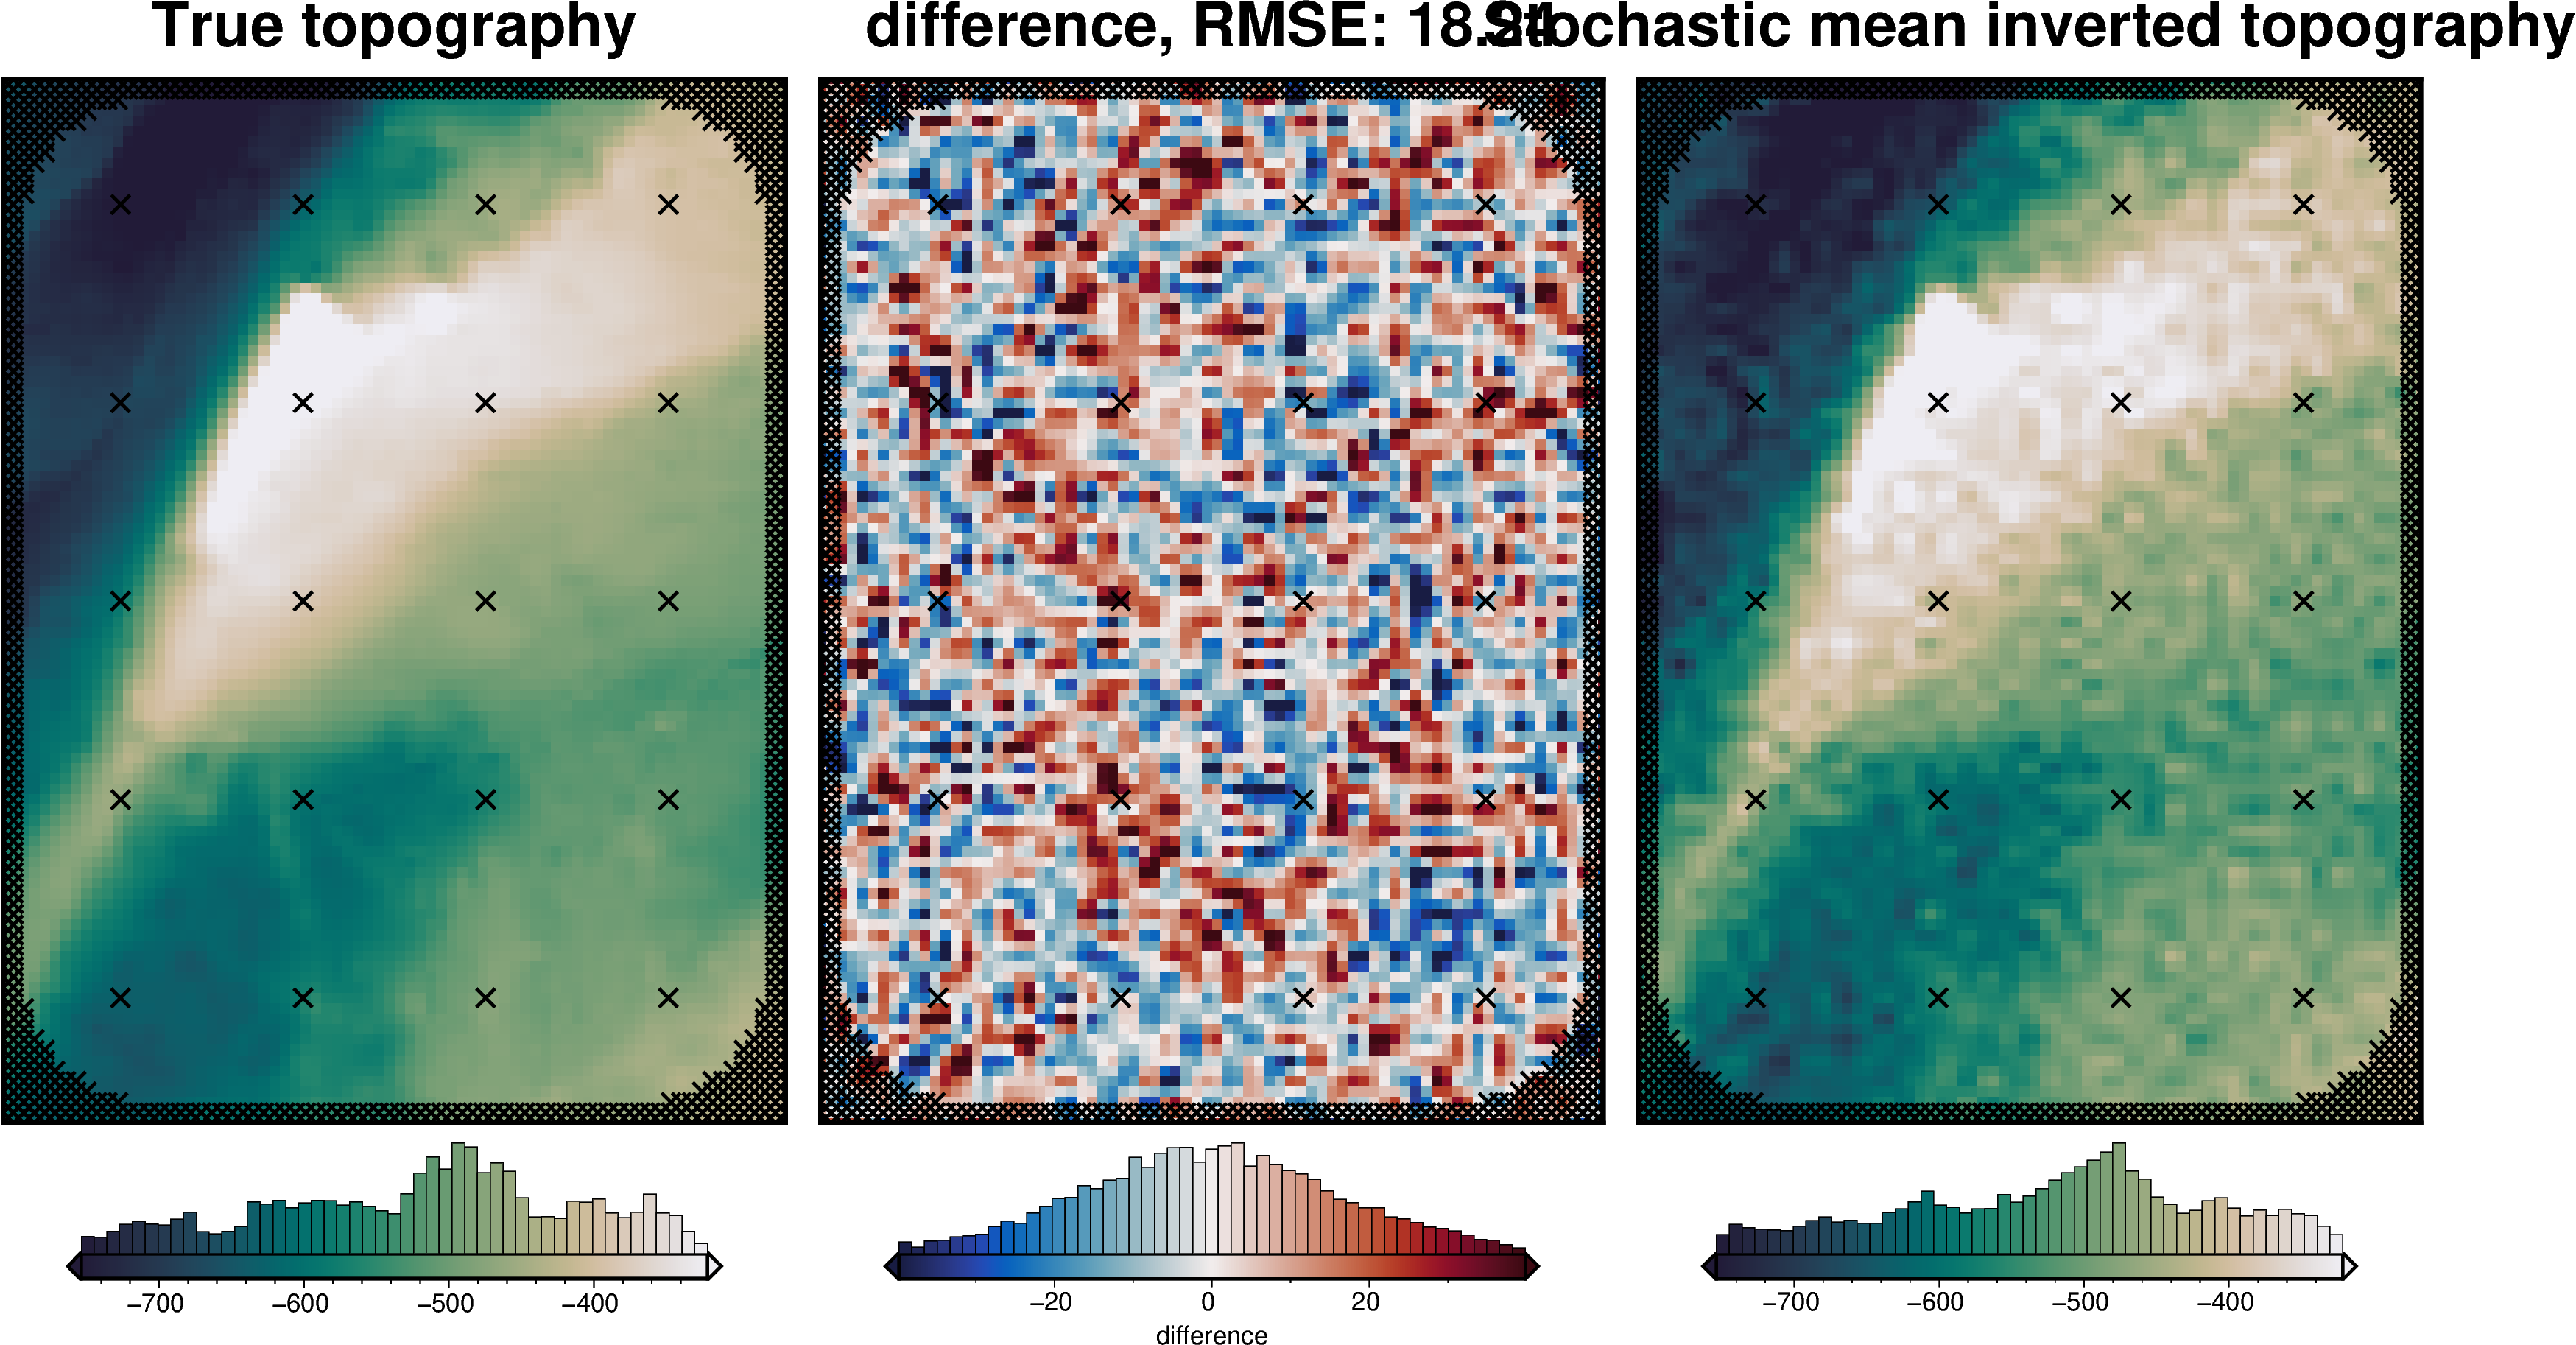

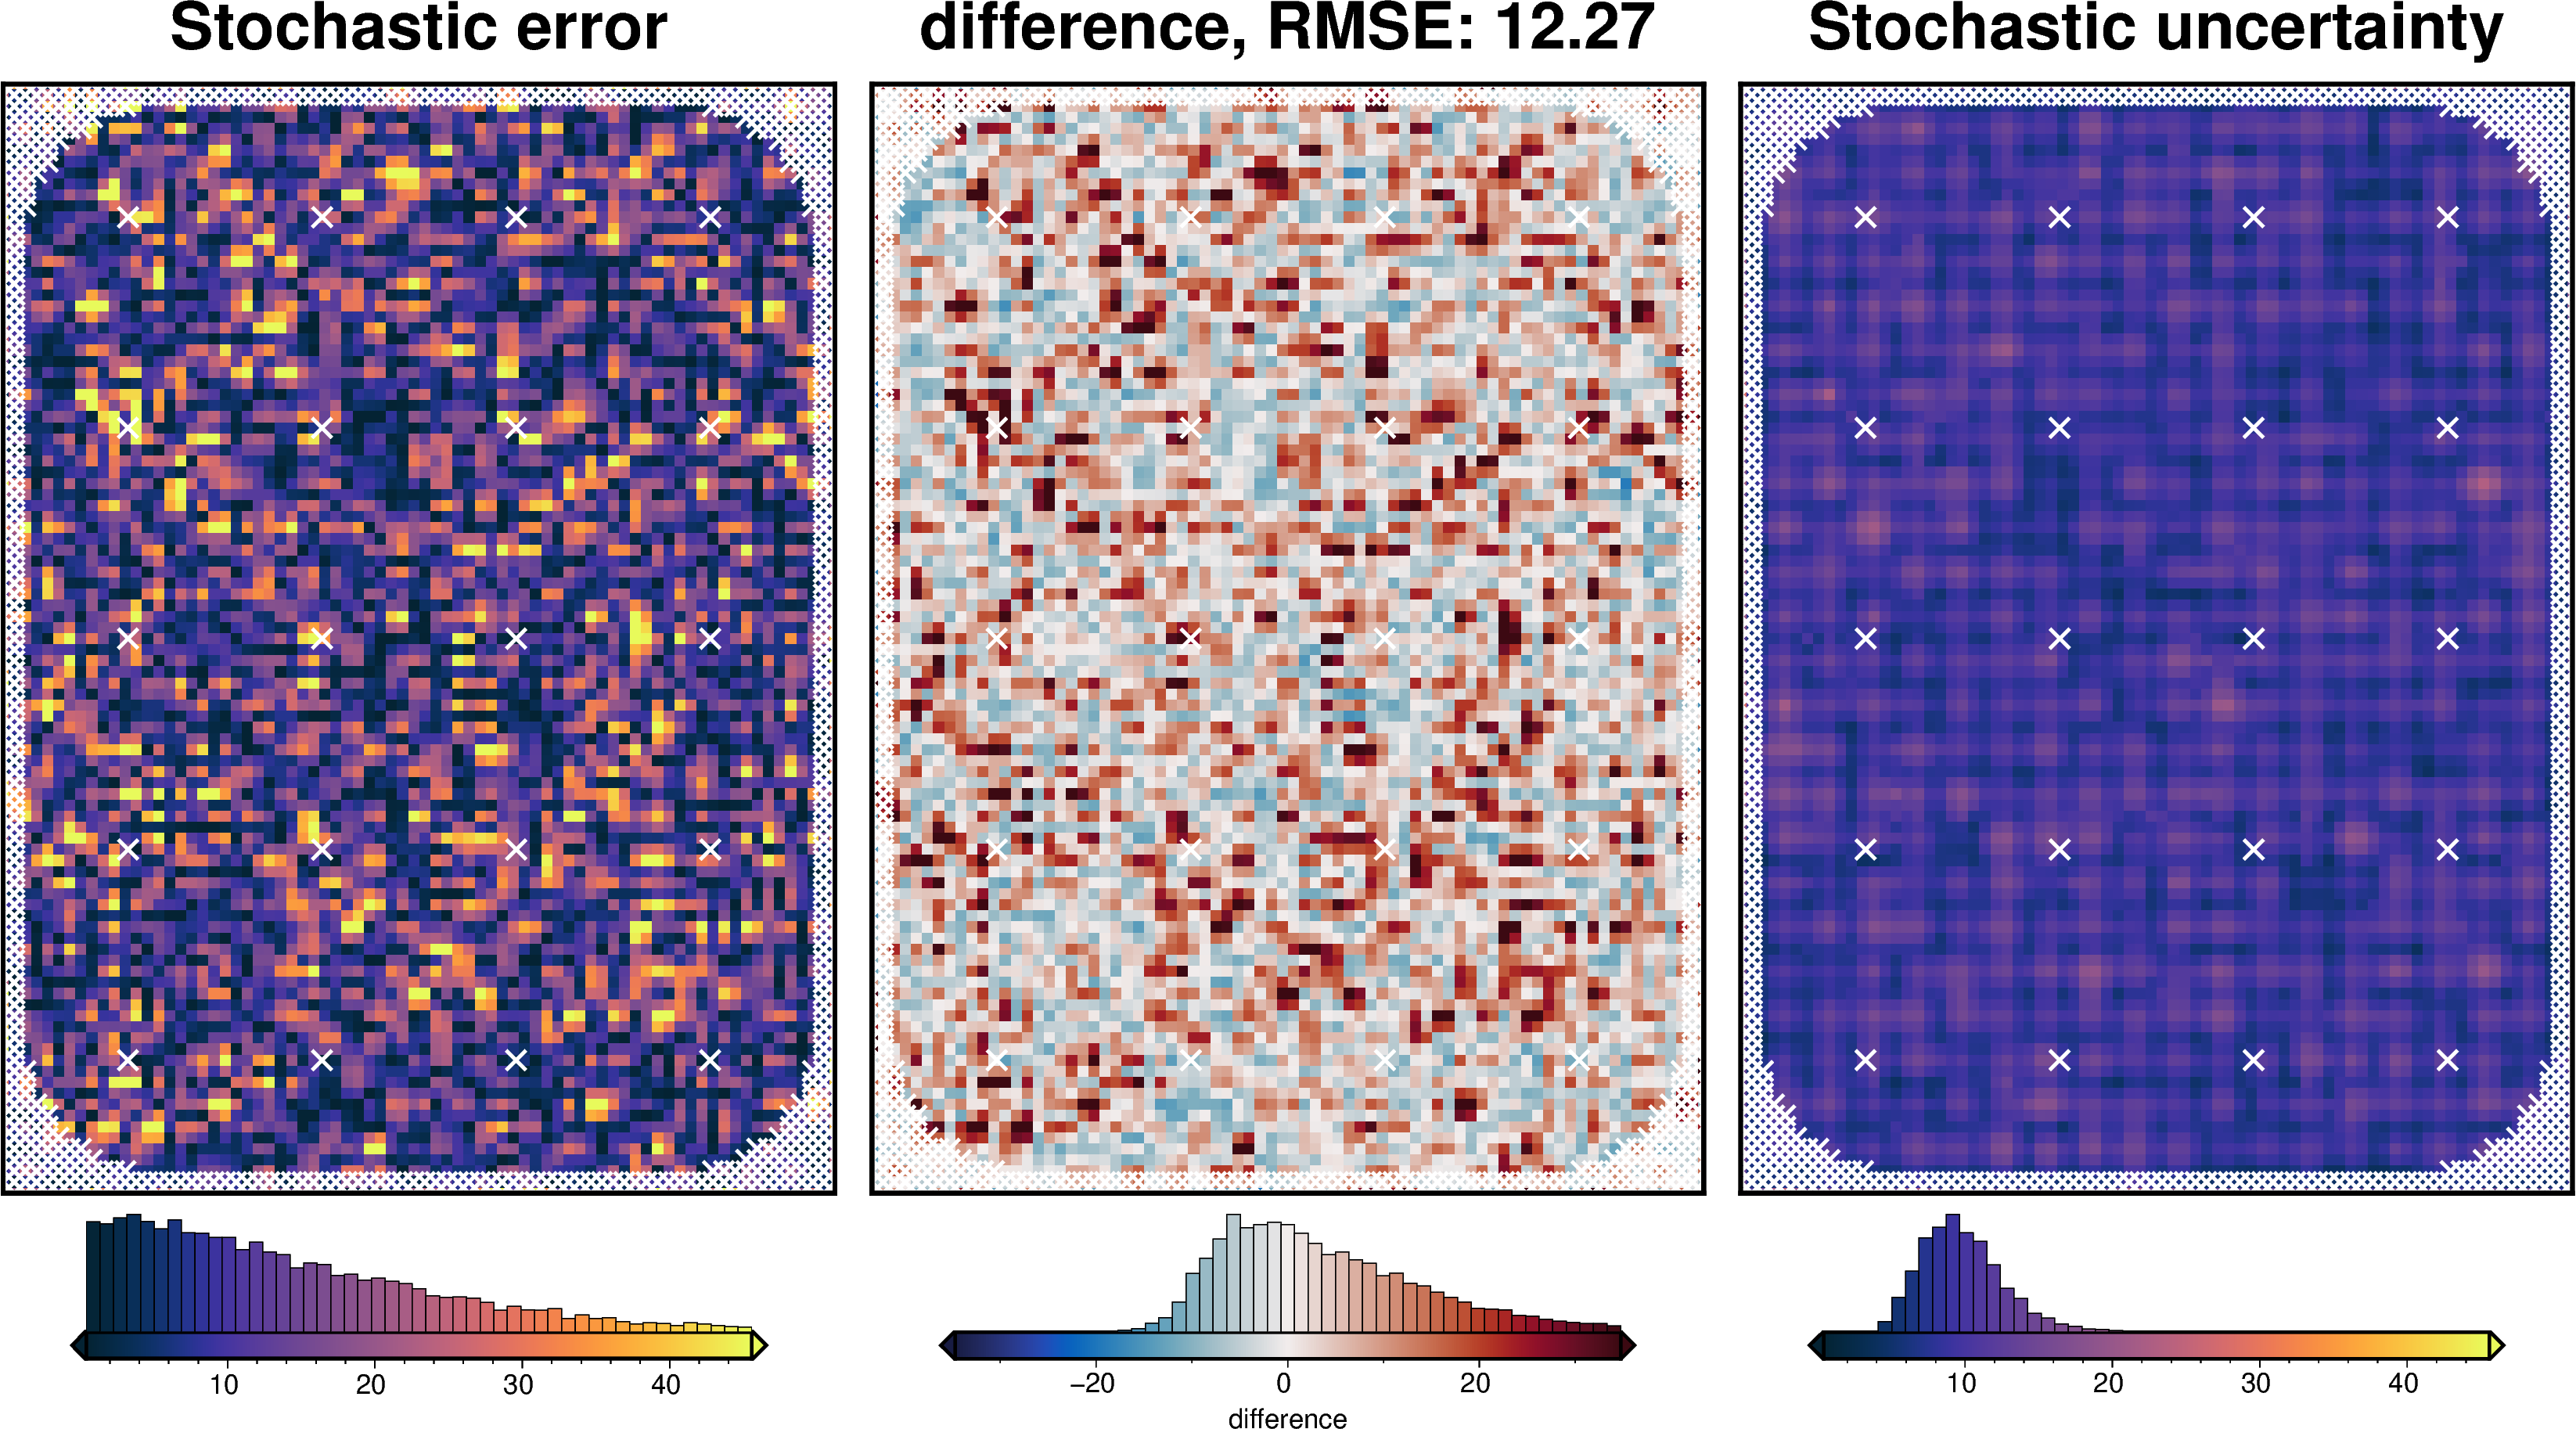

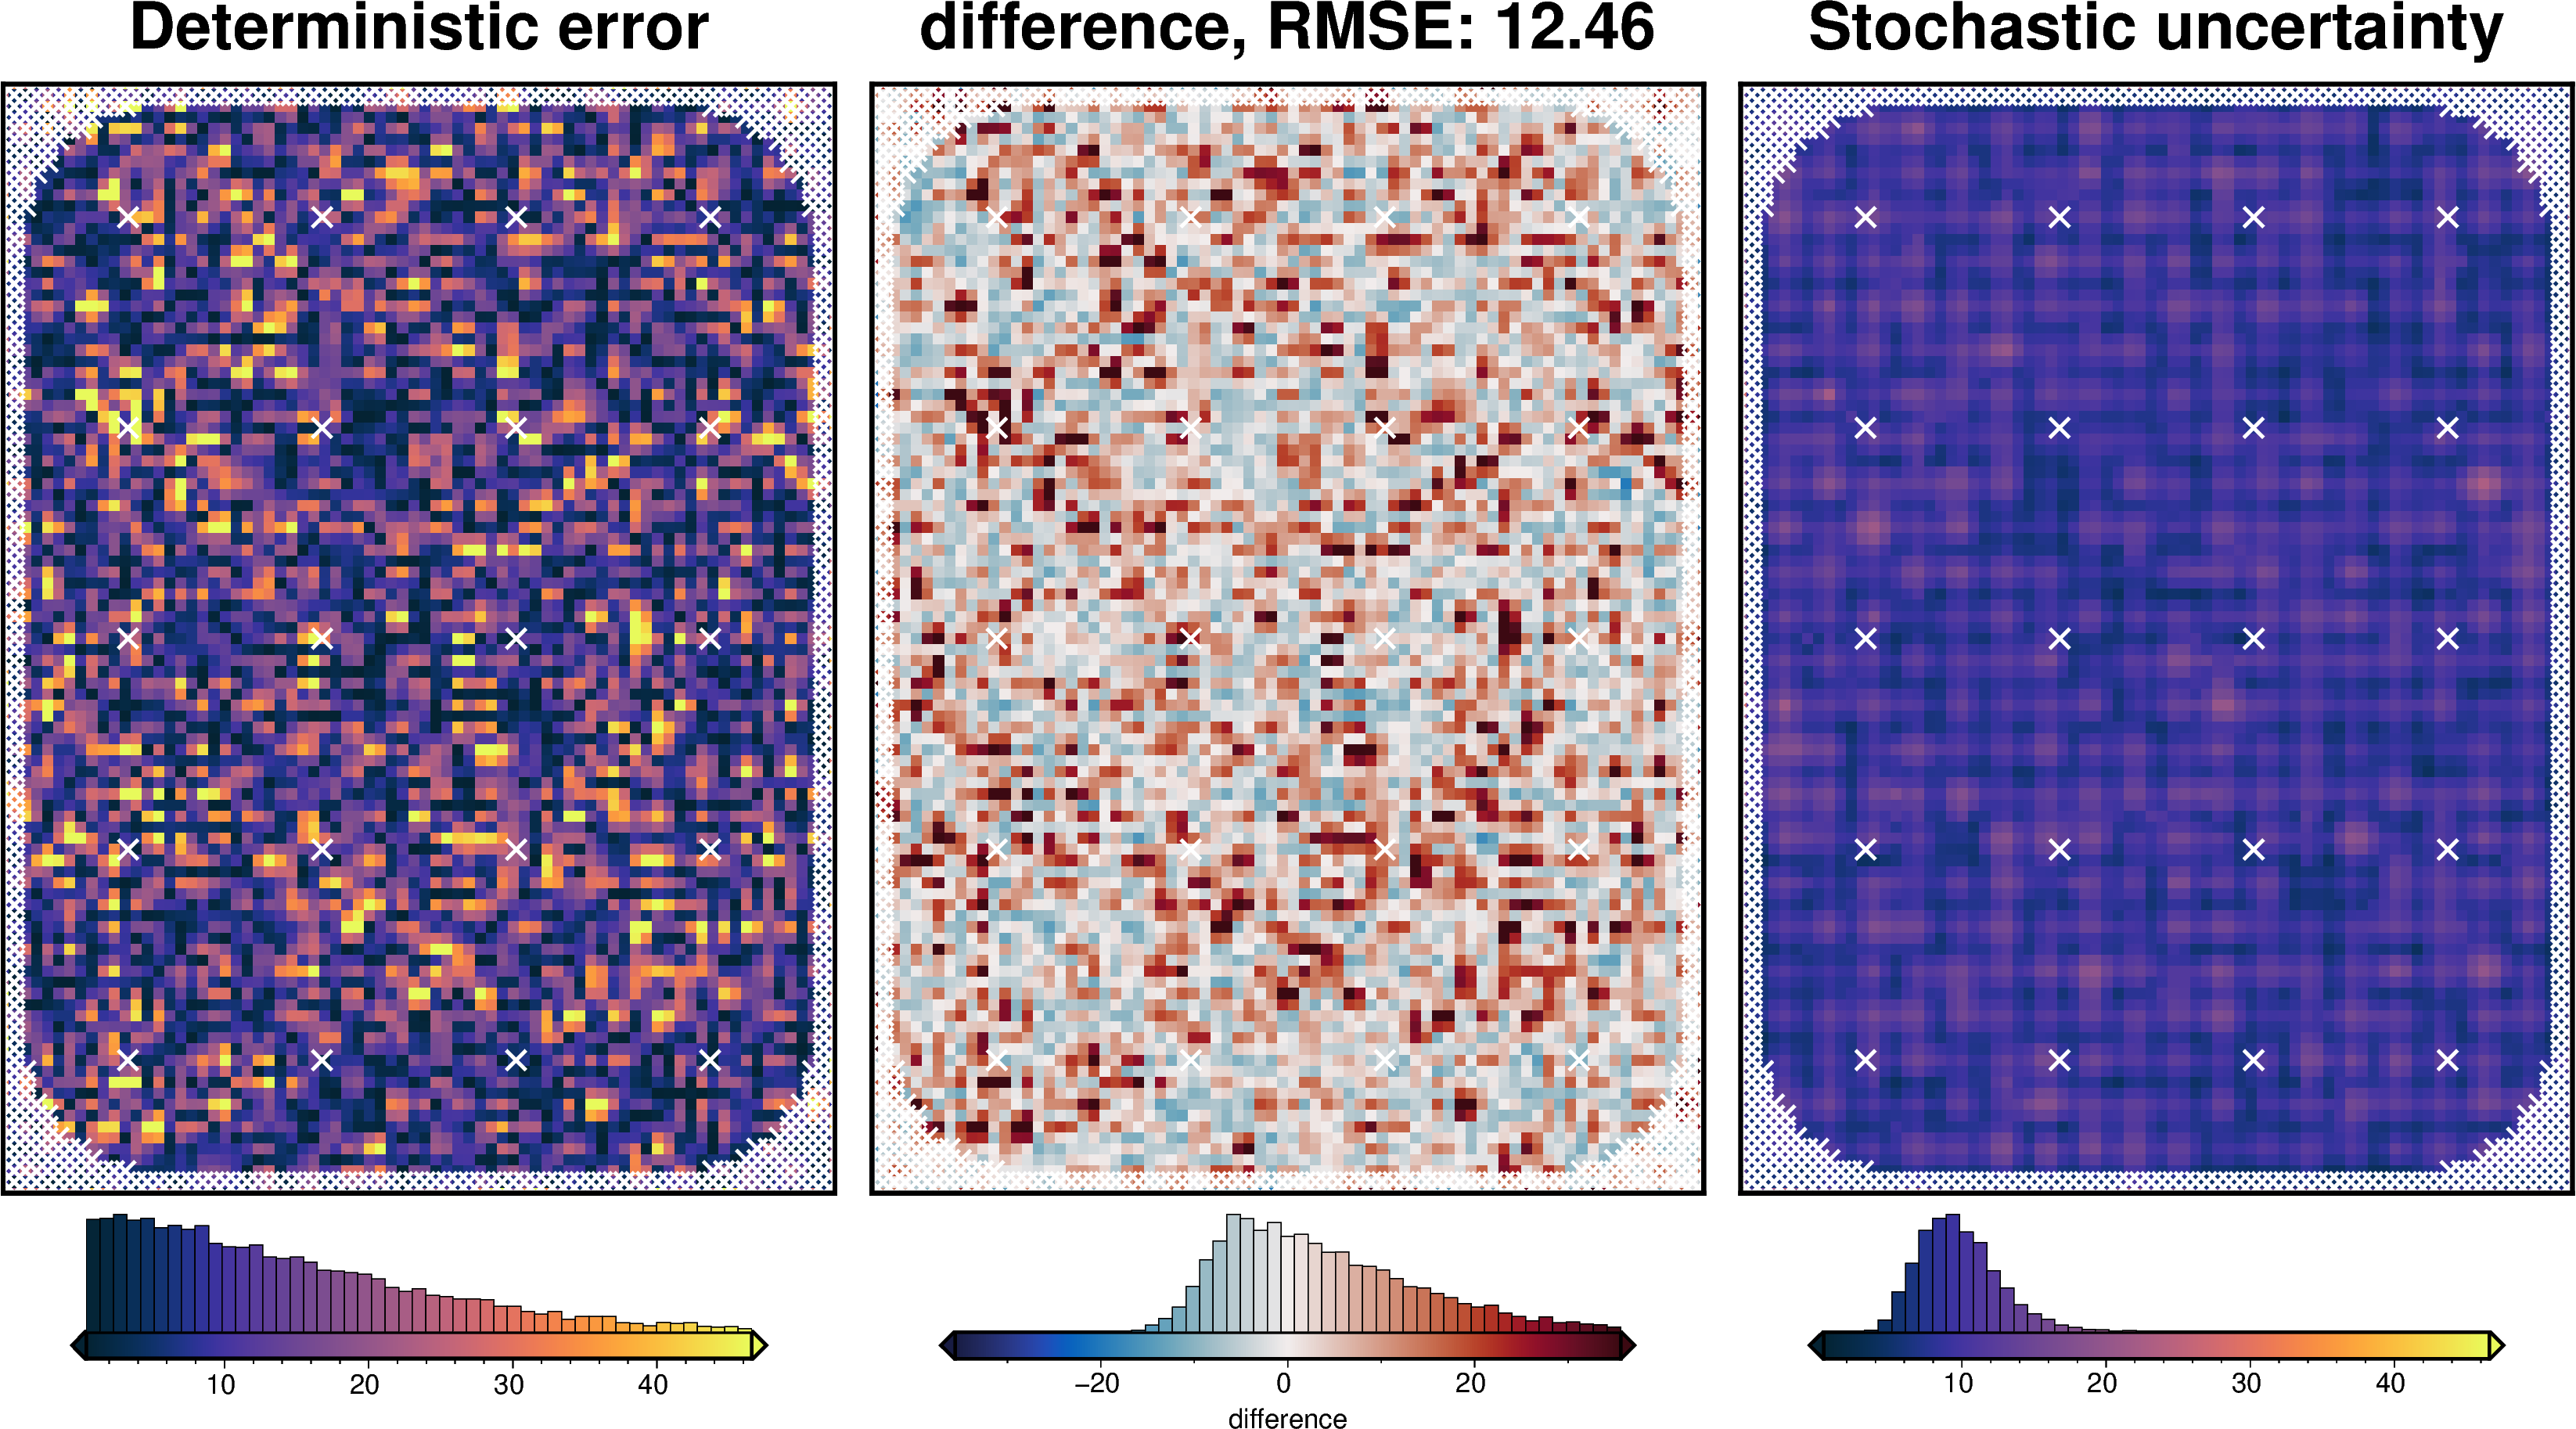

In [49]:
fname = "../../results/Ross_Sea_04_uncertainty_full"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    sample_gravity=True,
    parameter_dict=solver_dict | density_dict,
    **uncert_kwargs,
)

stats_ds = RIS_plotting.uncert_plots(
    uncert_results,
    # vd.pad_region(inversion_region, -3*spacing),
    inversion_region,
    spacing,
    bathymetry,
    deterministic_bathymetry=final_topography,
    constraint_points=constraint_points,
    weight_by="constraints",
    # weight_by="residual",
    # weight_by=None,
)

### Comparing results

In [50]:
results = [
    uncert_results,
    uncert_grav_results,
    uncert_density_results,
    uncert_damping_results,
]

# get cell-wise stats for each ensemble
stats = []
for r in results:
    ds = uncertainty.merged_stats(
        results=r,
        plot=False,
        constraints_df=constraint_points,
        weight_by="constraints",
        # region=vd.pad_region(inversion_region, -spacing),
        region=inversion_region,
    )
    stats.append(ds)

In [51]:
names = [
    "full",
    "gravity",
    "density",
    "damping",
]

# get the standard deviation of the ensemble of ensembles
stdevs = []
for i, s in enumerate(stats):
    stdevs.append(s.weighted_stdev.rename(f"{names[i]}_stdev"))

merged = xr.merge(stdevs)
merged

<xarray.Dataset> Size: 247kB
Dimensions:        (northing: 101, easting: 76)
Coordinates:
  * northing       (northing) float64 808B -1.6e+06 -1.598e+06 ... -1.4e+06
  * easting        (easting) float64 608B -4e+04 -3.8e+04 ... 1.08e+05 1.1e+05
Data variables:
    full_stdev     (northing, easting) float64 61kB 19.5 12.57 ... 10.03 16.0
    gravity_stdev  (northing, easting) float64 61kB 21.33 14.19 ... 7.63 10.82
    density_stdev  (northing, easting) float64 61kB 1.079 1.196 ... 2.464 2.813
    damping_stdev  (northing, easting) float64 61kB 0.3781 1.482 ... 1.017

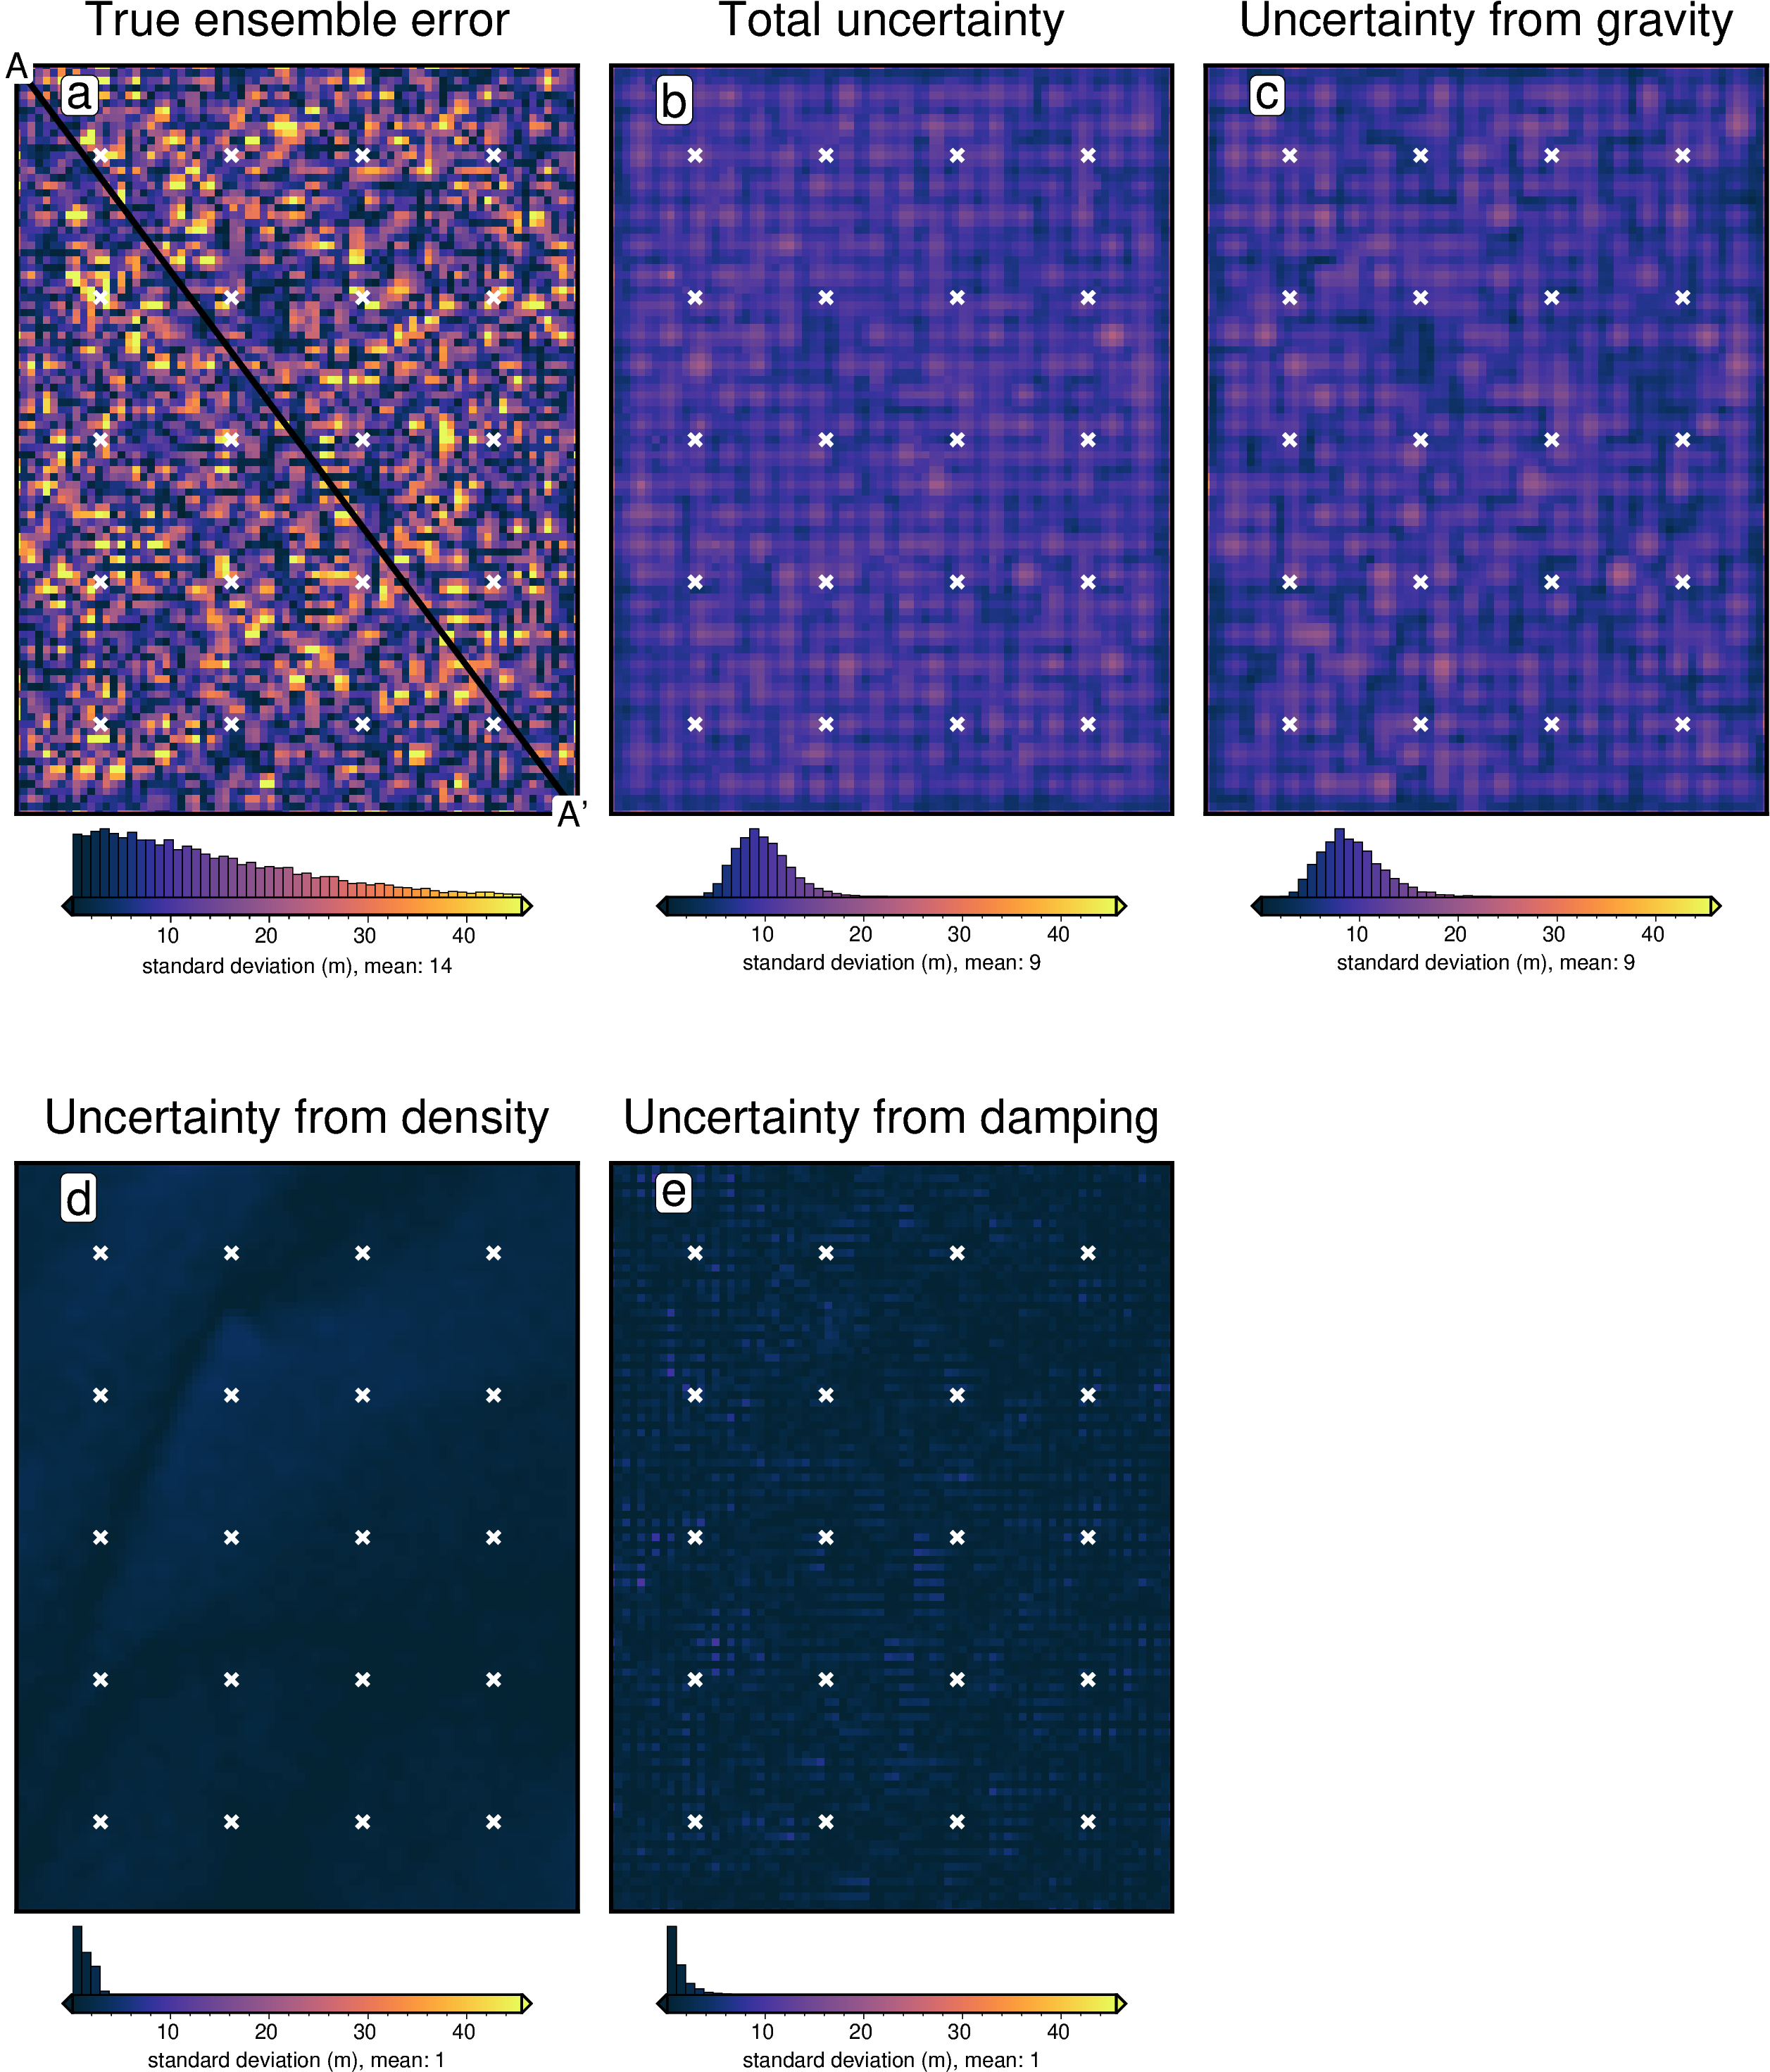

In [52]:
titles = [
    "True ensemble error",
    # "True indiv error",
    "Total uncertainty",
    "Uncertainty from gravity",
    "Uncertainty from density",
    "Uncertainty from damping",
]
grids = list(merged.data_vars.values())

grids.insert(0, np.abs(stats[0].weighted_mean - bathymetry))

# cpt_lims = polar_utils.get_min_max(grids[0], robust=True,)
cpt_lims = polar_utils.get_combined_min_max(grids, robust=True)

fig_height = 9
for i, g in enumerate(grids):
    xshift_amount = 1
    if i == 0:
        fig = None
        origin_shift = "initialize"
    elif i == 3:
        origin_shift = "both_shift"
        xshift_amount = -2
    else:
        origin_shift = "xshift"

    fig = maps.plot_grd(
        grid=g,
        fig_height=fig_height,
        # region=vd.pad_region(inversion_region, -3*spacing),
        title=titles[i],
        title_font="16p,Helvetica,black",
        cmap="thermal",
        cpt_lims=cpt_lims,
        robust=True,
        cbar_label=f"standard deviation (m), mean: {int(np.nanmean(g))}",
        hist=True,
        hist_bin_num=50,
        cbar_yoffset=1,
        fig=fig,
        origin_shift=origin_shift,
        xshift_amount=xshift_amount,
        yshift_amount=-1.1,
    )
    fig.plot(
        x=constraint_points[constraint_points.inside].easting,
        y=constraint_points[constraint_points.inside].northing,
        style="x.2c",
        fill="white",
        pen="1.5p,white",
    )
    fig.text(
        position="TL",
        text=f"{string.ascii_lowercase[i]}",
        fill="white",
        pen=True,
        font="16p,Helvetica,black",
        offset="j.6/.2",
        clearance="+tO",
        no_clip=True,
    )
    if i == 0:
        # plot profiles location, and endpoints on map
        start = [inversion_region[0], inversion_region[3]]
        stop = [inversion_region[1], inversion_region[2]]
        fig.plot(
            vd.line_coordinates(start, stop, size=100),
            pen="2p,black",
        )
        fig.text(
            x=start[0],
            y=start[1],
            text="A",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
        fig.text(
            x=stop[0],
            y=stop[1],
            text="A' ",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
fig.show()

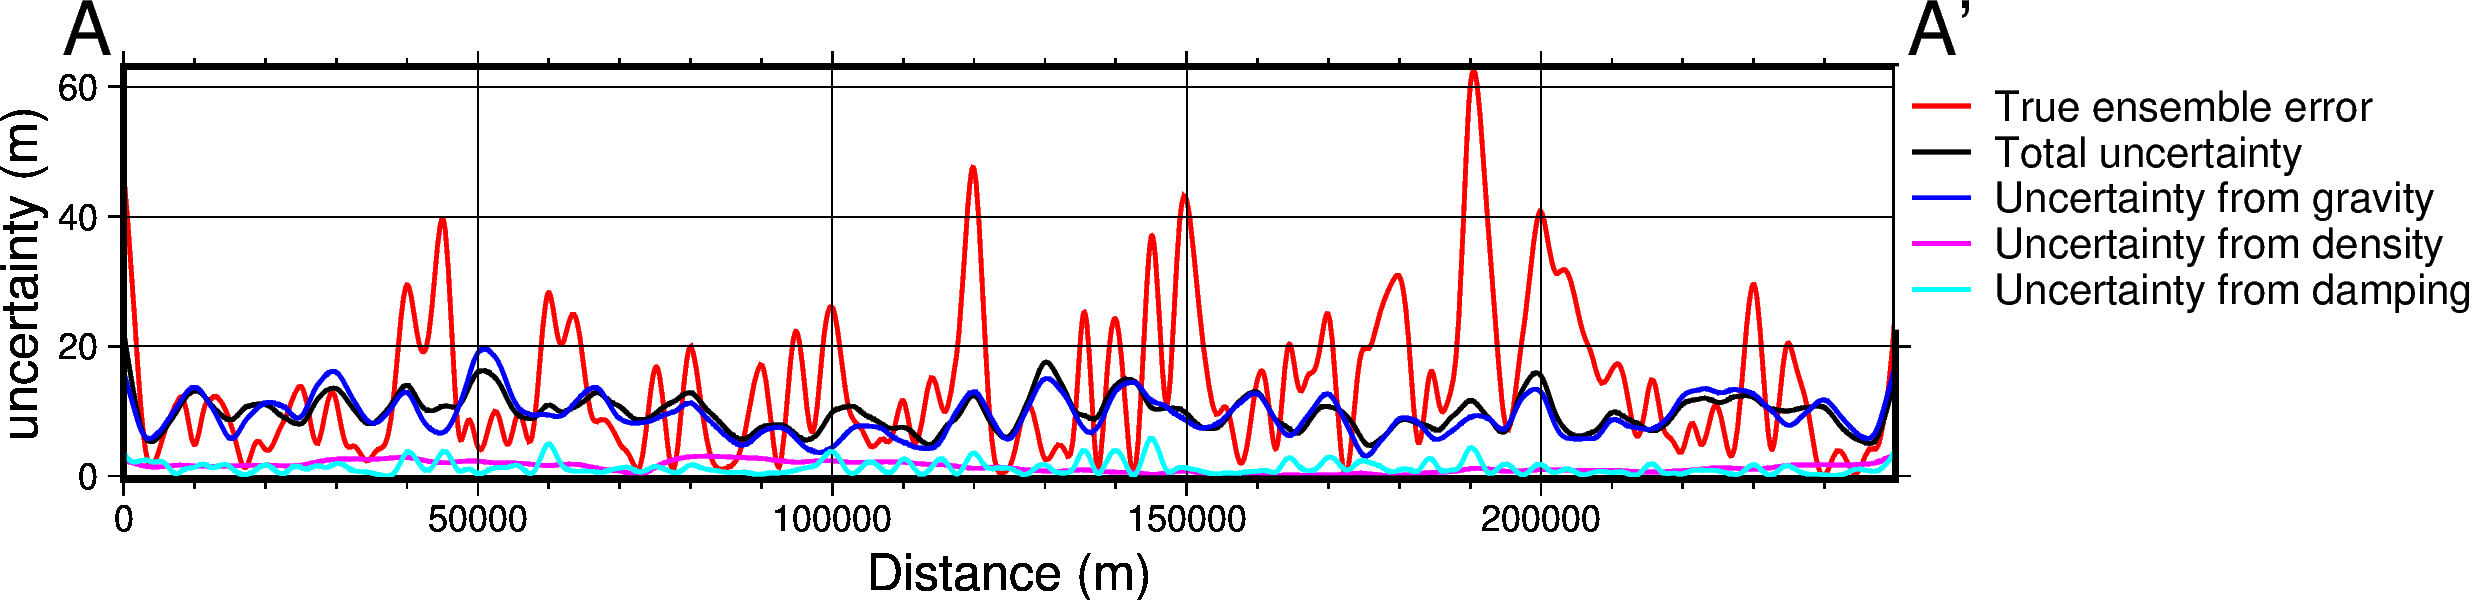

In [53]:
data_dict = profiles.make_data_dict(
    names=titles,
    grids=grids,
    colors=[
        "red",
        "black",
        "blue",
        "magenta",
        "cyan",
        "green",
        "purple",
    ],
)

fig, df_data = profiles.plot_data(
    "points",
    start=[inversion_region[0], inversion_region[3]],
    stop=[inversion_region[1], inversion_region[2]],
    num=10000,
    fig_height=4,
    fig_width=15,
    data_dict=data_dict,
    data_legend_loc="jTR+jTL",
    data_legend_box="+gwhite",
    data_buffer=0.01,
    data_frame=["neSW", "xafg+lDistance (m)", "yag+luncertainty (m)"],
    # data_pen_style=[None,None,"4_2:2p"],
    # data_pen_thickness=[1, 1.5, 1],
    share_yaxis=True,
    start_label="A",
    end_label="A' ",
)
fig.show()

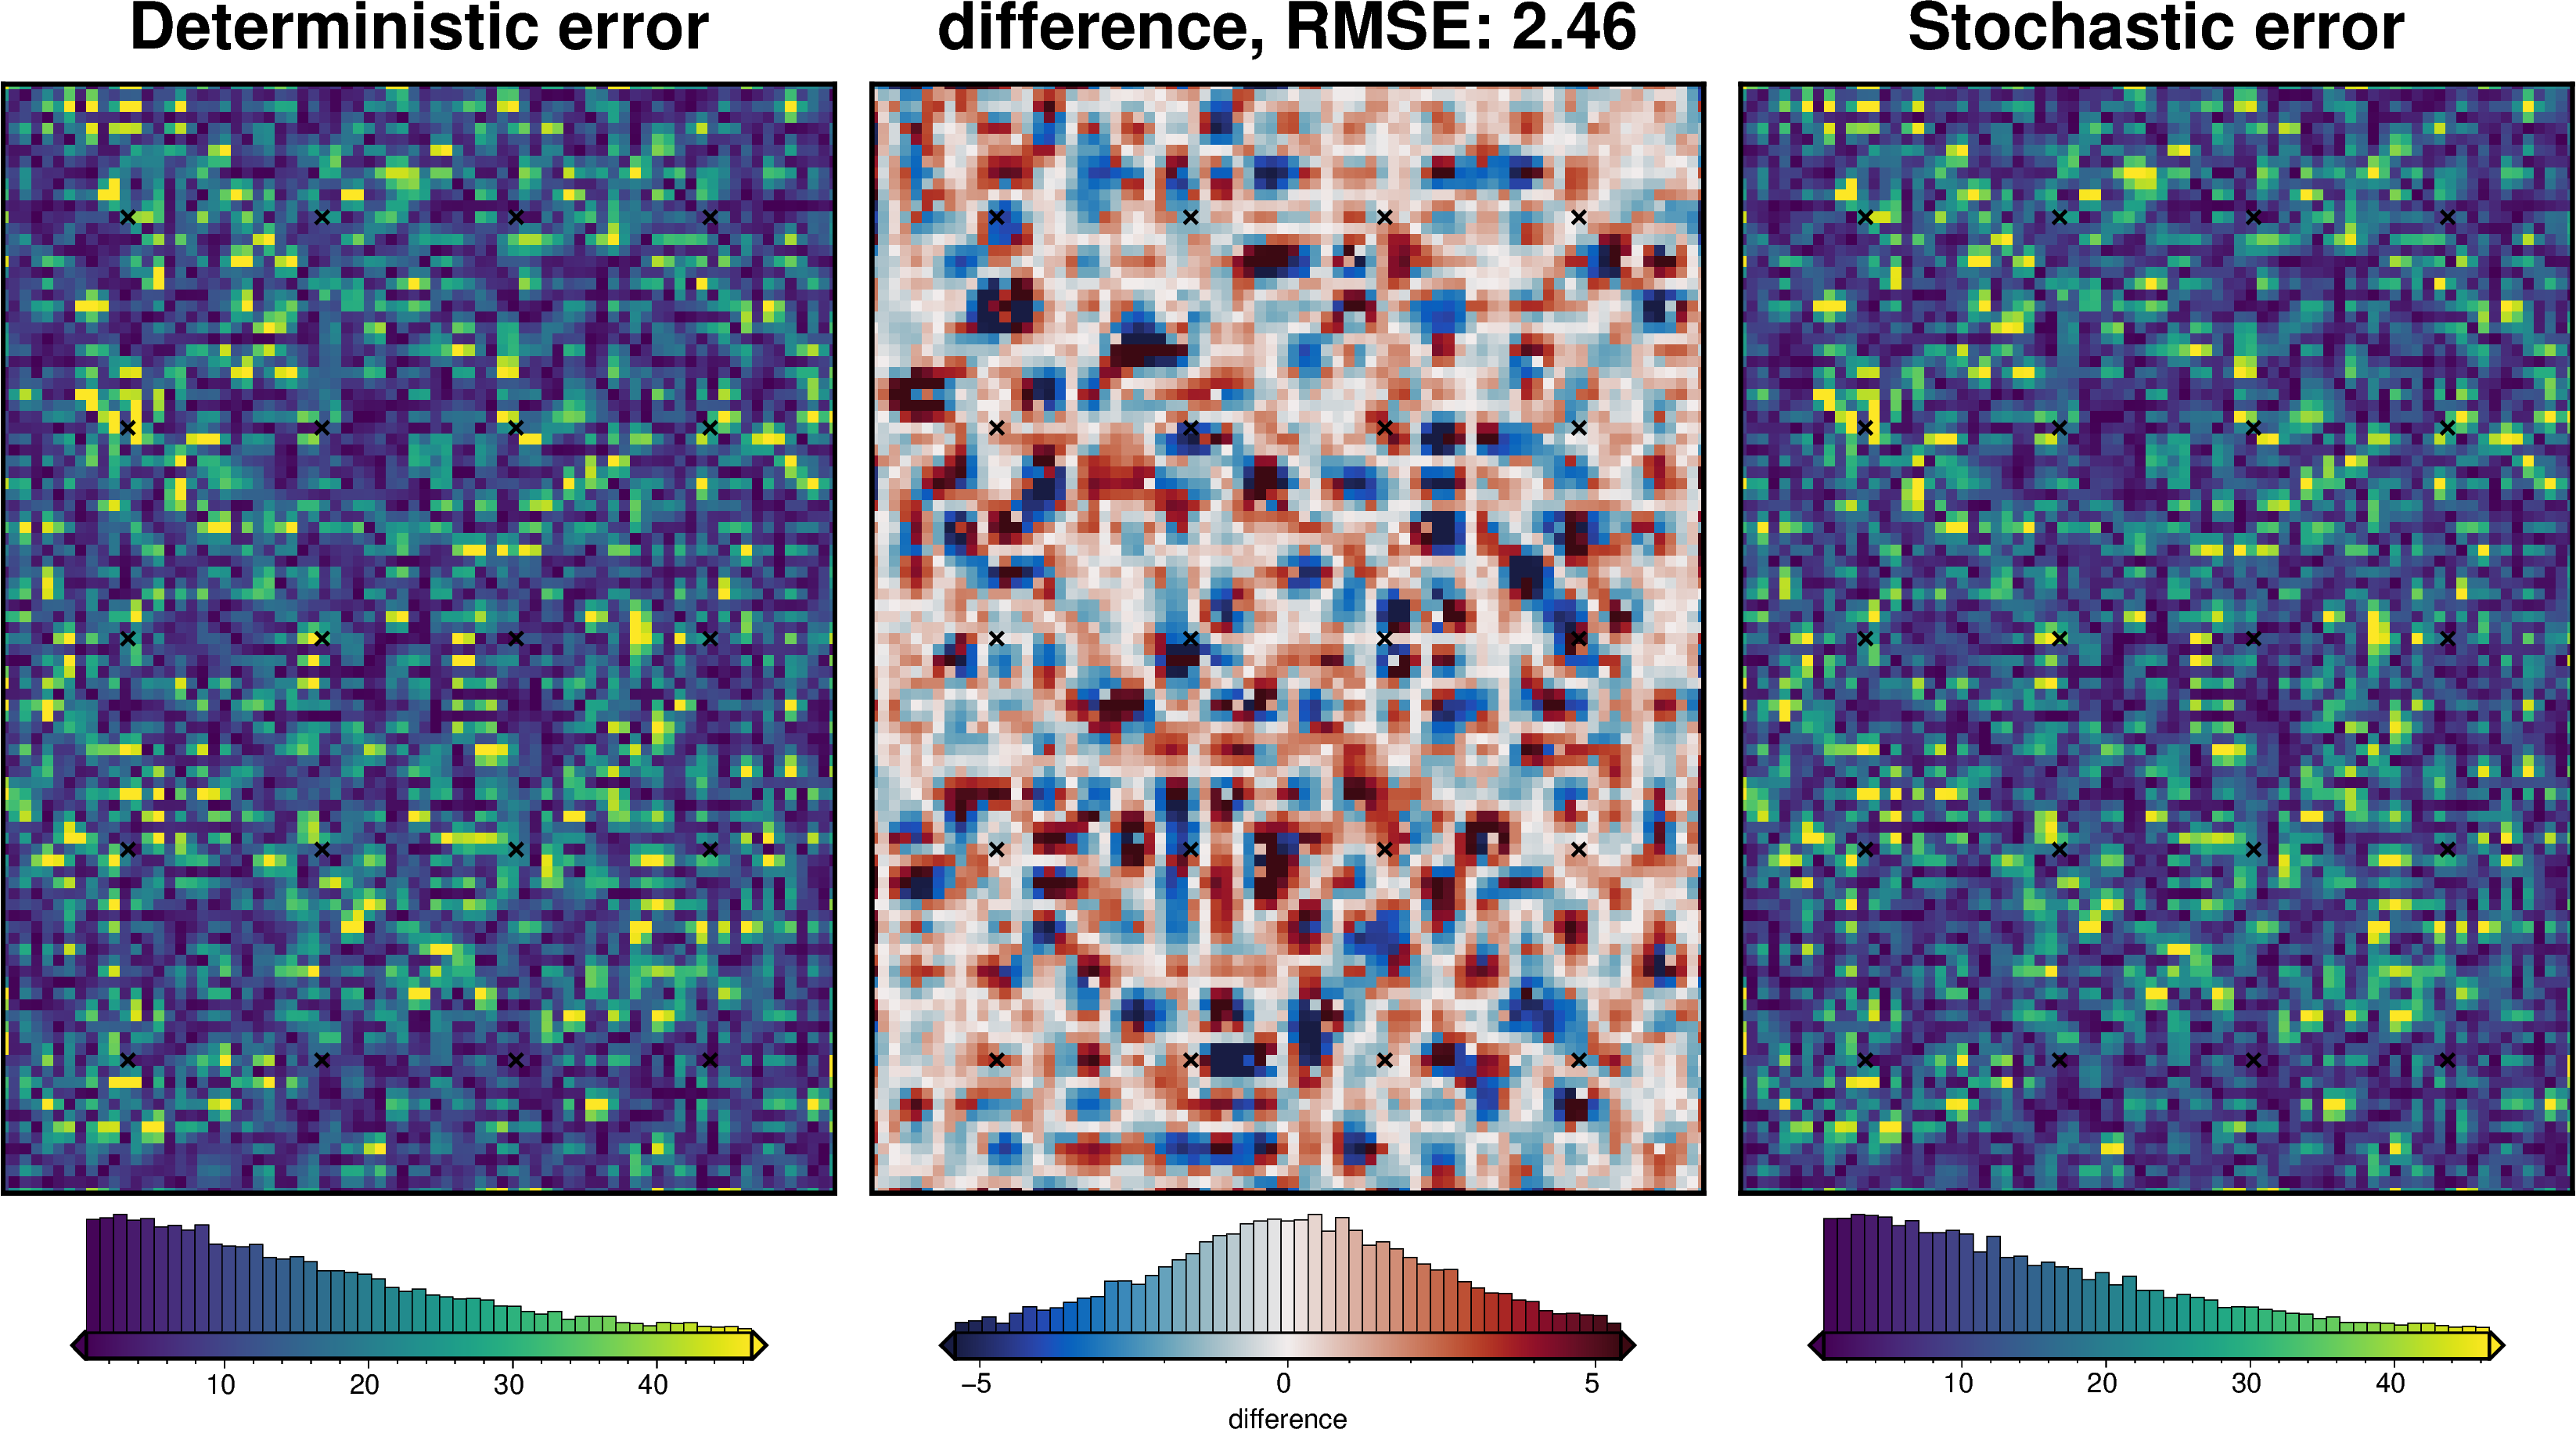

In [54]:
_ = polar_utils.grd_compare(
    inversion_error,
    np.abs(stats[0].weighted_mean - bathymetry),
    region=inversion_region,
    plot=True,
    grid1_name="Deterministic error",
    grid2_name="Stochastic error",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    points=constraint_points[constraint_points.inside],
    points_style="x.2c",
)

In [55]:
# save results
merged.to_netcdf("../../results/Ross_Sea_04_sensitivity.nc")

In [56]:
stats_ds.to_netcdf("../../results/Ross_Sea_04_uncertainty.nc")